In [1]:
from typing import Union
from urllib.parse import unquote, quote
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import inchi
from rdkit.Chem.MolStandardize import rdMolStandardize
import pickle
from mordred import Calculator, descriptors
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect
from sklearn.feature_selection import VarianceThreshold
from itertools import compress
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors as Descriptors
import os
from rdkit import Chem
from rdkit import RDPaths
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import MolDraw2DSVG

from bokeh.plotting import ColumnDataSource, figure, output_file, show
from sklearn.decomposition import PCA
from bokeh.io import output_notebook

import pandas as pd
from rdkit.Chem import inchi
from rdkit import Chem

import shap
shap.initjs()


import pandas as pd

from rdkit.Chem import AddHs
from rdkit.Chem import inchi
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.MolStandardize import Standardizer
from rdkit.Chem import MolStandardize
from collections import Counter

import subprocess

from pandarallel import pandarallel
# Initialize pandarallel
pandarallel.initialize(progress_bar=True)

import warnings

# To ignore all deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# To ignore all warnings (not recommended for development, but can be useful in production)
warnings.filterwarnings("ignore")


import logging
from rdkit import RDLogger

# Suppress RDKit warnings and informational messages
RDLogger.DisableLog('rdApp.*')

def standardized_smiles(smiles):
    standardizer = Standardizer()
    smiles_original = smiles

    # Read SMILES and convert it to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)
 
    try:
        smiles_clean_counter = Counter()
        mol_dict = {}
        is_finalize = False

        for _ in range(5):
            
            #This solved phosphate oxidation in most cases but introduces a problem for some compounds: eg. geldanamycin where the stable strcutre is returned
            inchi_standardised = Chem.MolToInchi(mol)
            mol = Chem.MolFromInchi(inchi_standardised)
            
            # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
            mol = rdMolStandardize.Cleanup(mol) 
            # if many fragments, get the "parent" (the actual mol we are interested in) 
            mol = rdMolStandardize.FragmentParent(mol)
            # try to neutralize molecule
            uncharger = rdMolStandardize.Uncharger() # annoying, but necessary as no convenience method exists
            
            mol = uncharger.uncharge(mol)# standardize molecules using MolVS and RDKit
            mol = standardizer.charge_parent(mol)
            mol = standardizer.isotope_parent(mol)
            mol = standardizer.stereo_parent(mol)
            
            #Normalize tautomers 
            #Method 1
            normalizer = MolStandardize.tautomer.TautomerCanonicalizer()
            mol = normalizer.canonicalize(mol)
            
            #Method 2
            te = rdMolStandardize.TautomerEnumerator() # idem
            mol = te.Canonicalize(mol)
            
            #Method 3
            mol = standardizer.tautomer_parent(mol)
       
    
            #Final Rules
            mol = standardizer.standardize(mol)
            mol_standardized = mol

            # convert mol object back to SMILES
            smiles_standardized = Chem.MolToSmiles(mol_standardized)

            if smiles == smiles_standardized:
                is_finalize = True
                break

            smiles_clean_counter[smiles_standardized] += 1
            if smiles_standardized not in mol_dict:
                mol_dict[smiles_standardized] = mol_standardized

            smiles = smiles_standardized
            mol = Chem.MolFromSmiles(smiles)

        if not is_finalize:
            # If the standardization process is not finalized, we choose the most common SMILES from the counter
            smiles_standardized = smiles_clean_counter.most_common()[0][0]
            # ... and the corresponding mol object
            #mol_standardized = mol_dict[smiles_standardized]
                
        return smiles_standardized 
    
    except:     
        
        return "Cannot_do"    
    
from dimorphite_dl.dimorphite_dl import DimorphiteDL

def protonate_smiles(smiles):

    dimorphite = DimorphiteDL(min_ph=7.0, max_ph=7.0, pka_precision=0)
    protonated_smiles = dimorphite.protonate(smiles)

    #print("protonated_smiles")

    if len(protonated_smiles) > 0:
                protonated_smiles = protonated_smiles[0]
            
    return protonated_smiles
    
def smiles_to_inchikey(smiles):
 
    try:
        
        # Convert SMILES to a molecule object
        mol = Chem.MolFromSmiles(smiles)
        # Convert the molecule object to an InChI string
        inchi_string = Chem.MolToInchi(mol)
        # Convert the InChI string to an InChIKey
        inchi_key = Chem.inchi.InchiToInchiKey(inchi_string)
        
        return inchi_key
    
    except:     
        
        return "Cannot_do"    
    
def MorganFingerprint(s):
    x = Chem.MolFromSmiles(s)
    return (AllChem.GetMorganFingerprintAsBitVect(x,2,2048))


def MACCSKeysFingerprint(s):
    x = Chem.MolFromSmiles(s)
    return (AllChem.GetMACCSKeysFingerprint(x))

def get_num_charged_atoms_neg(mol):
    mol_h = Chem.AddHs(mol)
    Chem.rdPartialCharges.ComputeGasteigerCharges(mol_h)
     
    positive = 0
    negative = 0
     
    for atom in mol_h.GetAtoms():
        if float(atom.GetProp('_GasteigerCharge')) <= 0:
            negative += 1
     
    return negative

def get_num_charged_atoms_pos(mol):
    mol_h = Chem.AddHs(mol)
    Chem.rdPartialCharges.ComputeGasteigerCharges(mol_h)
     
    positive = 0
    negative = 0
     
    for atom in mol_h.GetAtoms():
        if float(atom.GetProp('_GasteigerCharge')) >= 0:
            positive += 1
    return positive

def get_assembled_ring(mol):
    ring_info = mol.GetRingInfo()
    num_ring = ring_info.NumRings()
    ring_atoms = ring_info.AtomRings()
    num_assembled = 0
     
    for i in range(num_ring):
        for j in range(i+1, num_ring):
            x = set(ring_atoms[i])
            y = set(ring_atoms[j])
            if not x.intersection(y): # 2つの環が縮環でない場合に
                for x_id in x:
                    x_atom = mol.GetAtomWithIdx(x_id)
                    neighbors = [k.GetIdx() for k in x_atom.GetNeighbors()]
                    for x_n in neighbors:
                        if x_n in y: # 環同士を繋ぐ結合があるか否か
                            num_assembled += 1
     
    return num_assembled

def get_num_stereocenters(mol):
    return AllChem.CalcNumAtomStereoCenters(mol) + AllChem.CalcNumUnspecifiedAtomStereoCenters(mol)

def calc_descriptors(dataframe):
    mols = dataframe.smiles_r.apply(Chem.MolFromSmiles)
    #mols_fps=[AllChem.GetMorganFingerprintAsBitVect(x,2) for x in mols]
    descr = []
    for m in mols:
        descr.append([Descriptors.TPSA(m),
               Descriptors.NumRotatableBonds(m),
               AllChem.CalcNumRings(m),
               Descriptors.NumAromaticRings(m),
               Descriptors.NumHAcceptors(m),
               Descriptors.NumHDonors(m),
               Descriptors.FractionCSP3(m),
               Descriptors.MolLogP(m) ,
               Descriptors.NHOHCount(m),
               Descriptors.NOCount(m),
               Descriptors.NumHeteroatoms(m),
               get_num_charged_atoms_pos(m),
               get_num_charged_atoms_neg(m),
               get_assembled_ring(m),
               get_num_stereocenters(m)])
    descr = np.asarray(descr)
    return(descr)

descs = [ 'PSA', 'n_rot_bonds', 'n_rings', 'n_ar_rings',
         'n_HBA', 'n_HBD', 'Fsp3', 'logP', 'NHOHCount', 'NOCount', 'NumHeteroatoms',
        'n_positive', '_n_negative', 'n_ring_asmbl', 'n_stereo']

def calc_all_fp_desc(data):
   
    calc = Calculator(descriptors, ignore_3D=True)
    print(len(calc.descriptors))
    Ser_Mol = data['smiles_r'].apply(Chem.MolFromSmiles)
    # as pandas
    Mordred_table=  calc.pandas(Ser_Mol)
    Mordred_table = Mordred_table.astype('float')
    #Mordred_table['smiles_r'] = model_tox_data['smiles_r']
    
    MACCSfingerprint_array = np.stack(data['smiles_r'].apply(MACCSKeysFingerprint))
    MACCS_collection = []
    for x in np.arange(MACCSfingerprint_array.shape[1]):
        x = "MACCS"+str(x)
        MACCS_collection.append(x)
    MACCSfingerprint_table = pd.DataFrame(MACCSfingerprint_array, columns=MACCS_collection)


    MorganFingerprint_array = np.stack(data['smiles_r'].apply(MorganFingerprint))
    Morgan_fingerprint_collection = []
    for x in np.arange(MorganFingerprint_array.shape[1]):
        x = "Mfp"+str(x)
        Morgan_fingerprint_collection.append(x)
    Morgan_fingerprint_table = pd.DataFrame(MorganFingerprint_array, columns=Morgan_fingerprint_collection)

    
    a=calc_descriptors(data)
    descdf=pd.DataFrame(a, columns=descs)
    descdf_approved=descdf.reset_index(drop=True)
    descdf_approved
    
    tox_model_data= pd.concat([data, Morgan_fingerprint_table, MACCSfingerprint_table, descdf_approved, Mordred_table], axis=1)
    tox_model_data
    
    return(tox_model_data)
    
    
liv_data = [ "3",  "5",  "6",  "7",  "8",  "11", "14", "15", "16"]

def predict_individual_liv_data(data_dummy, features, endpoint):#predict animal data
    
    loaded_rf = pickle.load(open(f"bestlivmodel_{endpoint}_model.sav", 'rb'))
    X = data_dummy[features]
    X = X.values
    y_proba =  loaded_rf.predict_proba(X)[:,1]  
    
    return(y_proba)

def predict_individual_cmax_data(data_dummy, features, endpoint):#predict animal data
    
    regressor = pickle.load(open(f"bestlivmodel_{endpoint}_model.sav", 'rb'))

    X = data_dummy[features]
    X = X.values
    #Add predictions to held out test set dili
    y_pred = regressor.predict(X)
    
    return(y_pred)

def predict_liv_all(data):
    #Read columns needed for rat data
    file = open(f"./features_morgan_mordred_maccs_physc.txt", "r")
    file_lines = file.read()
    features = file_lines.split("\n")
    features = features[:-1]
    
    data_dummy = data

    for endpoint in liv_data:
        #print(endpoint)
        y_proba = predict_individual_liv_data(data_dummy, features, endpoint) 
        data[endpoint] = y_proba
        
    for endpoint in ["median pMolar unbound plasma concentration" ,
               "median pMolar total plasma concentration"]:
        y_proba = predict_individual_cmax_data(data_dummy, features, endpoint) 
        data[endpoint] = y_proba
    
    return(data)


def predict_DILI(data):#log human_VDss_L_kg model
    
    #Read columns needed for rat data
    file = open(f"./features_morgan_mordred_maccs_physc.txt", "r")
    file_lines = file.read()
    features = file_lines.split("\n")
    features = features[:-1]
    
    features = list(features) + ["median pMolar unbound plasma concentration", "median pMolar total plasma concentration"] + list(liv_data) 
    loaded_rf = pickle.load(open("./final_dili_model.sav", 'rb'))
    #Note this mode was trained on all data before releasing (not just ncv data)

    X = data[features]
    y_proba =  loaded_rf.predict_proba(X)[:,1]
    best_thresh = 0.612911
    print('Best Threshold=%f' % (best_thresh))
    
    y_pred  = [ 1 if y_proba>best_thresh  else 0] 
    
    explainer = shap.TreeExplainer(loaded_rf)
    shap_values = explainer.shap_values(X)
    

    shap.force_plot(explainer.expected_value[1], 
    shap_values[1], X.iloc[0],
    matplotlib=True)
    
    
    flat_shaplist = [item for sublist in shap_values[1] for item in sublist]
    
    interpret = pd.DataFrame()
    interpret["name"] = features
    interpret["SHAP"] = flat_shaplist#print(flat_shaplist)
    plt.show()
    # Explaining the 4th instance

    return(interpret, y_proba, y_pred)


def mol2svg(mol):
    d2d = rdMolDraw2D.MolDraw2DSVG(200, 100)
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    return d2d.GetDrawingText()


    

INFO: Pandarallel will run on 56 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
DILIdata= pd.read_csv("Test_data_DILIst_1111.csv")
DILIdata

smiles_r  TOXICITY  \
0        C#Cc1cccc(N=c2[nH]cnc3cc(OCCOC)c(OCCOC)cc23)c1         1   
1     COC1(NC(=O)CSC(F)F)C(=O)N2C(C(=O)O)=C(CSc3nnnn...         1   
2               CC(C)COCC(CN(Cc1ccccc1)c1ccccc1)N1CCCC1         1   
3     Cc1onc(-c2c(F)cccc2Cl)c1C(=O)NC1C(=O)N2C1SC(C)...         1   
4                                    CC1OC1[P](=O)(=O)O         1   
...                                                 ...       ...   
1106         COC(=O)N=c1[nH]c2ccc(C(=O)c3cccs3)cc2[nH]1         0   
1107  CC1CNc2c(cccc2S(=O)(=O)NC(CCCN=C(N)N)C(=O)N2CC...         0   
1108                         CCC(c1cccc(O)c1)C(C)CN(C)C         0   
1109                                     CC(N)Cc1ccccc1         0   
1110                              C[N+](C)(C)CC(=O)[O-]         0   

      Source_rank                              Source  Data  \
0               1         DILIst Classification  Oral  DILI   
1               1             DILIst Classification    DILI   
2               1             DILIst Classification    DILI   
3               1         DILIst Classification  oral  DILI   
4               1         DILIst Classification  Oral  DILI   
...           ...                                 ...   ...   
1106            1             DILIst Classification    DILI   
1107            1  DILIst Classification  Intravenous  DILI   
1108            1         DILIst Classification  Oral  DILI   
1109            1         DILIst Classification  Oral  DILI   
1110            1         DILIst Classification  Oral  DILI   

                         InChIKey      InChIKey14  \
0     AAKJLRGGTJKAMG-UHFFFAOYSA-N  AAKJLRGGTJKAMG   
1     UHRBTBZOWWGKMK-UHFFFAOYSA-N  UHRBTBZOWWGKMK   
2     UIEATEWHFDRYRU-UHFFFAOYSA-N  UIEATEWHFDRYRU   
3     UIOFUWFRIANQPC-UHFFFAOYSA-N  UIOFUWFRIANQPC   
4     UJNUDOLLRRCQDH-UHFFFAOYSA-N  UJNUDOLLRRCQDH   
...                           ...             ...   
1106  KYRVNWMVYQXFEU-UHFFFAOYSA-N  KYRVNWMVYQXFEU   
1107  KXNPVXPOPUZYGB-UHFFFAOYSA-N  KXNPVXPOPUZYGB   
1108  KWTWDQCKEHXFFR-UHFFFAOYSA-N  KWTWDQCKEHXFFR   
1109  KWTSXDURSIMDCE-UHFFFAOYSA-N  KWTSXDURSIMDCE   
1110  KWIUHFFTVRNATP-UHFFFAOYSA-N  KWIUHFFTVRNATP   

                                    protonated_smiles_r  Mfp0  Mfp1  ...  \
0        C#Cc1cccc(N=c2[nH]cnc3cc(OCCOC)c(OCCOC)cc23)c1     0     0  ...   
1     COC1(NC(=O)CSC(F)F)C(=O)[NH+]2C(C(=O)[O-])=C(C...     0     1  ...   
2           CC(C)COCC(CN(Cc1ccccc1)c1ccccc1)[NH+]1CCCC1     0     1  ...   
3     Cc1onc(-c2c(F)cccc2Cl)c1C(=O)NC1C(=O)[NH+]2C1S...     0     0  ...   
4                                    CC1OC1[P](=O)(=O)O     0     0  ...   
...                                                 ...   ...   ...  ...   
1106         COC(=O)N=c1[nH]c2ccc(C(=O)c3cccs3)cc2[nH]1     0     0  ...   
1107  CC1CNc2c(cccc2S(=O)(=O)NC(CCC[NH+]=C(N)N)C(=O)...     0     1  ...   
1108                     CCC(c1cccc(O)c1)C(C)C[NH+](C)C     0     1  ...   
1109                                CC([NH3+])Cc1ccccc1     0     1  ...   
1110                              C[N+](C)(C)CC(=O)[O-]     0     0  ...   

         SRW09      SRW10     TSRW10          MW       AMW   WPath  WPol  \
0     0.000000  10.116298  64.016835  393.168856  7.560940  2396.0  43.0   
1     6.555357  10.733545  82.269503  496.064645  9.921293  3113.0  51.0   
2     6.293419   9.845276  74.440588  367.274390  5.923780  1895.0  34.0   
3     7.853605  10.768843  83.380114  453.056148  9.639493  2402.0  53.0   
4     7.753194   9.180603  57.029675  137.000370  9.785741    61.0   7.0   
...        ...        ...        ...         ...       ...     ...   ...   
1106  7.285507   9.858333  70.378545  301.052112  9.407879   994.0  29.0   
1107  0.000000  10.488075  71.463013  509.254066  7.072973  3704.0  57.0   
1108  0.000000   9.353834  47.590867  222.185241  5.554631   448.0  21.0   
1109  0.000000   8.564268  38.519688  136.112076  5.671336   126.0   9.0   
1110  0.000000   8.379080  35.393001  117.078979  6.162052    66.0   5.0   

In [9]:
literature = pd.read_csv("literature.csv")
literature

name                                             smiles
0   2-Butoxyethanol                                           CCCCOCCO
1         Acitretin   COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)c(C)c1C
2           Alpidem  CCCN(CCC)C(=O)CC1=C(N=C2C=CC(Cl)=CN12)C1=CC=C(...
3        Amiodarone  CCCCC1=C(C(=O)C2=CC(I)=C(OCCN(CC)CC)C(I)=C2)C2...
4       Astaxanthin  O=C2\C(=C(\C=C\C(=C\C=C\C(=C\C=C\C=C(\C=C\C=C(...
5     Benzbromarone   CCC1=C(C(=O)C2=CC(Br)=C(O)C(Br)=C2)C2=CC=CC=C2O1
6         Bromfenac          NC1=C(CC(O)=O)C=CC=C1C(=O)C1=CC=C(Br)C=C1
7       Cabazitaxel  CO[C@H]1C[C@H]2OC[C@@]2(OC(C)=O)[C@H]2[C@H](OC...
8        Clomiphene  CCN(CC)CCOC1=CC=C(C=C1)C(=C(Cl)C1=CC=CC=C1)C1=...
9       Clopidogrel      COC(=O)[C@@H](N1CCC2=C(C1)C=CS2)C1=CC=CC=C1Cl
10       Cyclofenil  CC(=O)OC1=CC=C(C=C1)C(=C1CCCCC1)C1=CC=C(OC(C)=...
11        Docetaxel  [H][C@@]12C[C@H](O)[C@@]3(C)C(=O)[C@H](O)C4=C(...
12      Doxycycline  [H][C@@]12[C@@H](C)C3=C(C(O)=CC=C3)C(=O)C1=C(O...
13       Entacapone  CCN(CC)C(=O)C(=C\C1=CC(=C(O)C(O)=C1)[N+]([O-])...
14     Enzalutamide  CNC(=O)c1ccc(N2C(=S)N(c3ccc(C#N)c(C(F)(F)F)c3)...
15  Ethacrynic acid            CCC(=C)C(=O)C1=CC=C(OCC(O)=O)C(Cl)=C1Cl
16      Gemcitabine  NC1=NC(=O)N(C=C1)[C@@H]1O[C@H](CO)[C@@H](O)C1(F)F
17         Ibufenac                         CC(C)CC1=CC=C(CC(O)=O)C=C1
18        Ibuprofen                      CC(C)CC1=CC=C(C=C1)C(C)C(O)=O
19      Lumiracoxib           CC1=CC=C(NC2=C(F)C=CC=C2Cl)C(CC(O)=O)=C1
20    Methapyrilene                         CN(C)CCN(Cc1cccs1)c1ccccn1
21      Minocycline  CN(C)[C@H]1[C@@H]2C[C@@H]3CC4=C(C(O)=CC=C4N(C)...
22     Moxifloxacin  [H][C@]12CN(C[C@@]1([H])NCCC2)C1=C(F)C=C2C(=O)...
23       Nefazodone  CCC1=NN(CCCN2CCN(CC2)C2=CC(Cl)=CC=C2)C(=O)N1CC...
24       Paclitaxel  CC1=C2[C@@]([C@]([C@H]([C@@H]3[C@]4([C@H](OC4)...
25        Pazopanib  CN(C1=CC2=NN(C)C(C)=C2C=C1)C1=NC(NC2=CC(=C(C)C...
26     Pioglitazone      CCC1=CN=C(CCOC2=CC=C(CC3SC(=O)NC3=O)C=C2)C=C1
27       Sitaxentan  CC1=NOC(NS(=O)(=O)C2=C(SC=C2)C(=O)CC2=C(C)C=C3...
28      Ticlopidine                    ClC1=CC=CC=C1CN1CCC2=C(C1)C=CS2
29       Ticrynafen        OC(=O)COC1=C(Cl)C(Cl)=C(C=C1)C(=O)C1=CC=CS1
30        Tolcapone  CC1=CC=C(C=C1)C(=O)C1=CC(O)=C(O)C(=C1)[N+]([O-...
31     Troglitazone  CC1=C(O)C(C)=C2CCC(C)(COC3=CC=C(CC4SC(=O)NC4=O...
32    Trovafloxacin  [H][C@@]12CN(C[C@]1([H])[C@H]2N)C1=C(F)C=C2C(=...
33     Ximelagatran  CCOC(=O)CN[C@H](C1CCCCC1)C(=O)N1CC[C@H]1C(=O)N...
34         Zolpidem    CN(C)C(=O)CC1=C(N=C2C=CC(C)=CN12)C1=CC=C(C)C=C1

In [10]:
names = ["Acitretin",
"Cabazitaxel",
"Clopidogrel",
"Docetaxel",
"Doxycycline",
"Entacapone",
"Gemcitabine",
"Minocycline",
"Moxifloxacin",
"Paclitaxel",
"Trovafloxacin",
"Ximelagatran"]


In [13]:
literature = literature[literature.name.isin(names)].reset_index(drop=True)
literature

name                                             smiles
0       Acitretin   COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)c(C)c1C
1     Cabazitaxel  CO[C@H]1C[C@H]2OC[C@@]2(OC(C)=O)[C@H]2[C@H](OC...
2     Clopidogrel      COC(=O)[C@@H](N1CCC2=C(C1)C=CS2)C1=CC=CC=C1Cl
3       Docetaxel  [H][C@@]12C[C@H](O)[C@@]3(C)C(=O)[C@H](O)C4=C(...
4     Doxycycline  [H][C@@]12[C@@H](C)C3=C(C(O)=CC=C3)C(=O)C1=C(O...
5      Entacapone  CCN(CC)C(=O)C(=C\C1=CC(=C(O)C(O)=C1)[N+]([O-])...
6     Gemcitabine  NC1=NC(=O)N(C=C1)[C@@H]1O[C@H](CO)[C@@H](O)C1(F)F
7     Minocycline  CN(C)[C@H]1[C@@H]2C[C@@H]3CC4=C(C(O)=CC=C4N(C)...
8    Moxifloxacin  [H][C@]12CN(C[C@@]1([H])NCCC2)C1=C(F)C=C2C(=O)...
9      Paclitaxel  CC1=C2[C@@]([C@]([C@H]([C@@H]3[C@]4([C@H](OC4)...
10  Trovafloxacin  [H][C@@]12CN(C[C@]1([H])[C@H]2N)C1=C(F)C=C2C(=...
11   Ximelagatran  CCOC(=O)CN[C@H](C1CCCCC1)C(=O)N1CC[C@H]1C(=O)N...

In [14]:
literature['smiles_r']=literature['smiles'].parallel_apply(standardized_smiles)
literature['protonated_smiles_r']=literature['smiles_r'].parallel_apply(protonate_smiles)
literature

name                                             smiles  \
0       Acitretin   COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)c(C)c1C   
1     Cabazitaxel  CO[C@H]1C[C@H]2OC[C@@]2(OC(C)=O)[C@H]2[C@H](OC...   
2     Clopidogrel      COC(=O)[C@@H](N1CCC2=C(C1)C=CS2)C1=CC=CC=C1Cl   
3       Docetaxel  [H][C@@]12C[C@H](O)[C@@]3(C)C(=O)[C@H](O)C4=C(...   
4     Doxycycline  [H][C@@]12[C@@H](C)C3=C(C(O)=CC=C3)C(=O)C1=C(O...   
5      Entacapone  CCN(CC)C(=O)C(=C\C1=CC(=C(O)C(O)=C1)[N+]([O-])...   
6     Gemcitabine  NC1=NC(=O)N(C=C1)[C@@H]1O[C@H](CO)[C@@H](O)C1(F)F   
7     Minocycline  CN(C)[C@H]1[C@@H]2C[C@@H]3CC4=C(C(O)=CC=C4N(C)...   
8    Moxifloxacin  [H][C@]12CN(C[C@@]1([H])NCCC2)C1=C(F)C=C2C(=O)...   
9      Paclitaxel  CC1=C2[C@@]([C@]([C@H]([C@@H]3[C@]4([C@H](OC4)...   
10  Trovafloxacin  [H][C@@]12CN(C[C@]1([H])[C@H]2N)C1=C(F)C=C2C(=...   
11   Ximelagatran  CCOC(=O)CN[C@H](C1CCCCC1)C(=O)N1CC[C@H]1C(=O)N...   

                                             smiles_r  \
0         COc1cc(C)c(C=CC(C)=CC=CC(C)=CC(=O)O)c(C)c1C   
1   COC1=C2C(C)C(OC(=O)C(O)C(NC(=O)OC(C)(C)C)c3ccc...   
2                   COC(=O)C(c1ccccc1Cl)N1CCc2sccc2C1   
3   CC(=O)OC12COC1CC(O)C1(C)C(=O)C(=O)C3C(C)C(OC(=...   
4   CC1c2cccc(O)c2C(=O)C2C(=O)C3(O)C(=O)C(C(N)=O)C...   
5    CCN(CC)C(=O)C(C#N)=Cc1cc(O)c(O)c([N+](=O)[O-])c1   
6               N=c1ccn(C2OC(CO)C(O)C2(F)F)c(=O)[nH]1   
7   CN(C)c1ccc(O)c2c1CC1CC3C(N(C)C)C(=O)C(C(N)=O)C...   
8   COc1c(N2CC3CCCNC3C2)c(F)cc2c(=O)c(C(=O)O)cn(C3...   
9   CC(=O)OC1=C2C(C)C(OC(=O)C(O)C(NC(=O)c3ccccc3)c...   
10  NC1C2CN(c3nc4c(cc3F)c(=O)c(C(=O)O)cn4-c3ccc(F)...   
11  CCOC(=O)CNC(C(=O)N1CCC1C(=O)NCc1ccc(C(N)=NO)cc...   

                                  protonated_smiles_r  
0      COc1cc(C)c(C=CC(C)=CC=CC(C)=CC(=O)[O-])c(C)c1C  
1   COC1=C2C(C)C(OC(=O)C(O)C(NC(=O)OC(C)(C)C)c3ccc...  
2               COC(=O)C(c1ccccc1Cl)[NH+]1CCc2sccc2C1  
3   CC(=O)OC12COC1CC(O)C1(C)C(=O)C(=O)C3C(C)C(OC(=...  
4   CC1c2cccc(O)c2C(=O)C2C(=O)C3(O)C(=O)C(C(N)=O)C...  
5   CC[NH+](CC)C(=O)C(C#N)=Cc1cc(O)c(O)c([N+](=O)[...  
6               N=c1ccn(C2OC(CO)C(O)C2(F)F)c(=O)[nH]1  
7   CN(C)c1ccc(O)c2c1CC1CC3C([NH+](C)C)C(=O)C(C(N)...  
8   COc1c(N2CC3CCC[NH2+]C3C2)c(F)cc2c(=O)c(C(=O)[O...  
9   CC(=O)OC1=C2C(C)C(OC(=O)C(O)C(NC(=O)c3ccccc3)c...  
10  [NH3+]C1C2CN(c3nc4c(cc3F)c(=O)c(C(=O)[O-])cn4-...  
11  CCOC(=O)C[NH2+]C(C(=O)[NH+]1CCC1C(=O)NCc1ccc(C...

In [15]:
liv_data

['3', '5', '6', '7', '8', '11', '14', '15', '16']

In [16]:
source = ["Human hepatotoxicity",
"Animal hepatotoxicity A",
"Animal hepatotoxicity B",
"Preclinical hepatotoxicity",
"Diverse DILI A",
"Diverse DILI C",
"BESP",
"Mitotox",
"Reactive Metabolite"]


assaytype = ["Human hepatotoxicity",
"Animal hepatotoxicity",
"Animal hepatotoxicity",
"Animal hepatotoxicity",
"Heterogenous Data ",
"Heterogenous Data ",
"Mechanisms of Liver Toxicity",
"Mechanisms of Liver Toxicity",
"Mechanisms of Liver Toxicity"]


info = pd.DataFrame({"name": liv_data, "source": source, "assaytype": assaytype})
info

#info=pd.read_csv("proxyDILI_labels.csv")

name                      source                     assaytype
0    3        Human hepatotoxicity          Human hepatotoxicity
1    5     Animal hepatotoxicity A         Animal hepatotoxicity
2    6     Animal hepatotoxicity B         Animal hepatotoxicity
3    7  Preclinical hepatotoxicity         Animal hepatotoxicity
4    8              Diverse DILI A            Heterogenous Data 
5   11              Diverse DILI C            Heterogenous Data 
6   14                        BESP  Mechanisms of Liver Toxicity
7   15                     Mitotox  Mechanisms of Liver Toxicity
8   16         Reactive Metabolite  Mechanisms of Liver Toxicity

In [17]:
info.dtypes

name         object
source       object
assaytype    object
dtype: object

In [18]:
literature

name                                             smiles  \
0       Acitretin   COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)c(C)c1C   
1     Cabazitaxel  CO[C@H]1C[C@H]2OC[C@@]2(OC(C)=O)[C@H]2[C@H](OC...   
2     Clopidogrel      COC(=O)[C@@H](N1CCC2=C(C1)C=CS2)C1=CC=CC=C1Cl   
3       Docetaxel  [H][C@@]12C[C@H](O)[C@@]3(C)C(=O)[C@H](O)C4=C(...   
4     Doxycycline  [H][C@@]12[C@@H](C)C3=C(C(O)=CC=C3)C(=O)C1=C(O...   
5      Entacapone  CCN(CC)C(=O)C(=C\C1=CC(=C(O)C(O)=C1)[N+]([O-])...   
6     Gemcitabine  NC1=NC(=O)N(C=C1)[C@@H]1O[C@H](CO)[C@@H](O)C1(F)F   
7     Minocycline  CN(C)[C@H]1[C@@H]2C[C@@H]3CC4=C(C(O)=CC=C4N(C)...   
8    Moxifloxacin  [H][C@]12CN(C[C@@]1([H])NCCC2)C1=C(F)C=C2C(=O)...   
9      Paclitaxel  CC1=C2[C@@]([C@]([C@H]([C@@H]3[C@]4([C@H](OC4)...   
10  Trovafloxacin  [H][C@@]12CN(C[C@]1([H])[C@H]2N)C1=C(F)C=C2C(=...   
11   Ximelagatran  CCOC(=O)CN[C@H](C1CCCCC1)C(=O)N1CC[C@H]1C(=O)N...   

                                             smiles_r  \
0         COc1cc(C)c(C=CC(C)=CC=CC(C)=CC(=O)O)c(C)c1C   
1   COC1=C2C(C)C(OC(=O)C(O)C(NC(=O)OC(C)(C)C)c3ccc...   
2                   COC(=O)C(c1ccccc1Cl)N1CCc2sccc2C1   
3   CC(=O)OC12COC1CC(O)C1(C)C(=O)C(=O)C3C(C)C(OC(=...   
4   CC1c2cccc(O)c2C(=O)C2C(=O)C3(O)C(=O)C(C(N)=O)C...   
5    CCN(CC)C(=O)C(C#N)=Cc1cc(O)c(O)c([N+](=O)[O-])c1   
6               N=c1ccn(C2OC(CO)C(O)C2(F)F)c(=O)[nH]1   
7   CN(C)c1ccc(O)c2c1CC1CC3C(N(C)C)C(=O)C(C(N)=O)C...   
8   COc1c(N2CC3CCCNC3C2)c(F)cc2c(=O)c(C(=O)O)cn(C3...   
9   CC(=O)OC1=C2C(C)C(OC(=O)C(O)C(NC(=O)c3ccccc3)c...   
10  NC1C2CN(c3nc4c(cc3F)c(=O)c(C(=O)O)cn4-c3ccc(F)...   
11  CCOC(=O)CNC(C(=O)N1CCC1C(=O)NCc1ccc(C(N)=NO)cc...   

                                  protonated_smiles_r  
0      COc1cc(C)c(C=CC(C)=CC=CC(C)=CC(=O)[O-])c(C)c1C  
1   COC1=C2C(C)C(OC(=O)C(O)C(NC(=O)OC(C)(C)C)c3ccc...  
2               COC(=O)C(c1ccccc1Cl)[NH+]1CCc2sccc2C1  
3   CC(=O)OC12COC1CC(O)C1(C)C(=O)C(=O)C3C(C)C(OC(=...  
4   CC1c2cccc(O)c2C(=O)C2C(=O)C3(O)C(=O)C(C(N)=O)C...  
5   CC[NH+](CC)C(=O)C(C#N)=Cc1cc(O)c(O)c([N+](=O)[...  
6               N=c1ccn(C2OC(CO)C(O)C2(F)F)c(=O)[nH]1  
7   CN(C)c1ccc(O)c2c1CC1CC3C([NH+](C)C)C(=O)C(C(N)...  
8   COc1c(N2CC3CCC[NH2+]C3C2)c(F)cc2c(=O)c(C(=O)[O...  
9   CC(=O)OC1=C2C(C)C(OC(=O)C(O)C(NC(=O)c3ccccc3)c...  
10  [NH3+]C1C2CN(c3nc4c(cc3F)c(=O)c(C(=O)[O-])cn4-...  
11  CCOC(=O)C[NH2+]C(C(=O)[NH+]1CCC1C(=O)NCc1ccc(C...

In [22]:
smiles_r = "COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)c(C)c1C"

1613


100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Best Threshold=0.612911


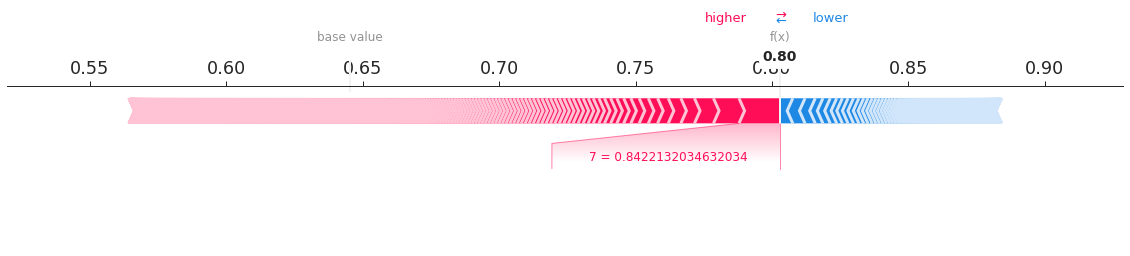

0.8029690107536119
1
The compound is predicted DILI-Positive
unbound Cmax:  0.08 uM
total Cmax:  0.64 uM
Most contributing MACCS substructure to DILI toxicity
Presence of this substructure contributes 0.0007 to prediction
Most contributing MACCS substructure to DILI safety
Presence of this substructure contributes -0.0003 to prediction


In [23]:
        test = {'smiles_r':  [smiles_r]
                    }
        test = pd.DataFrame(test)

        desc=pd.read_csv("all_features_desc.csv", encoding='windows-1252')


        molecule = Chem.MolFromSmiles(smiles_r)     
        #st.image(Draw.MolToImage(molecule), width=200)
                
        test_mfp_Mordred = calc_all_fp_desc(test)
        test_mfp_Mordred_liv = predict_liv_all(test_mfp_Mordred)
        test_mfp_Mordred_liv_values = test_mfp_Mordred_liv.T.reset_index().rename(columns={"index":"name", 0: "value"})

        interpret, y_proba, y_pred = predict_DILI(test_mfp_Mordred_liv)   
        interpret = pd.merge(interpret, desc, right_on="name", left_on="name", how="outer")
        interpret = pd.merge(interpret, test_mfp_Mordred_liv_values, right_on="name", left_on="name", how="inner") 

        print(y_proba[0])
        print(y_pred[0]) 
        
        if(y_pred[0]==1):
            print("The compound is predicted DILI-Positive")
        if(y_pred[0]==0):
            print("The compound is predicted DILI-Negative")
        
        print("unbound Cmax: ", np.round(10**-test_mfp_Mordred_liv["median pMolar unbound plasma concentration"][0] *10**6, 2), "uM")
        print("total Cmax: ", np.round(10**-test_mfp_Mordred_liv["median pMolar total plasma concentration"][0] *10**6, 2), "uM")
        print("Most contributing MACCS substructure to DILI toxicity")
        
        top = interpret[interpret["SHAP"]>0].sort_values(by=["SHAP"], ascending=False)
        proxy_DILI_SHAP_top = pd.merge(info, top[top["name"].isin(liv_data)])
        proxy_DILI_SHAP_top["pred"] = proxy_DILI_SHAP_top["value"]>0.50
        proxy_DILI_SHAP_top["SHAP contribution to Toxicity"] = "Positive"
        proxy_DILI_SHAP_top["smiles"] = smiles_r
        
        top_positives = top[top["value"]==1]
        top_MACCS= top_positives[top_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["description"].values[0]
        top_MACCS_value= top_positives[top_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["value"].values[0]
        top_MACCS_shap= top_positives[top_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["SHAP"].values[0] 
        top_MACCSsubstructure = Chem.MolFromSmarts(top_MACCS)
        
        Draw.MolToImage(molecule, highlightAtoms=molecule.GetSubstructMatch(top_MACCSsubstructure), width=400)        
        print("Presence of this substructure contributes", np.round(top_MACCS_shap, 4), "to prediction")
                     
                 
        print("Most contributing MACCS substructure to DILI safety")
        bottom = interpret[interpret["SHAP"]<0].sort_values(by=["SHAP"], ascending=True)
        proxy_DILI_SHAP_bottom = pd.merge(info, bottom[bottom["name"].isin(liv_data)])
        proxy_DILI_SHAP_bottom["pred"] = proxy_DILI_SHAP_bottom["value"]>0.50
        proxy_DILI_SHAP_bottom["SHAP contribution to Toxicity"] = "Negative"
        proxy_DILI_SHAP_bottom["smiles"] = smiles_r
        
        bottom_positives = bottom[bottom["value"]==1]
        bottom_MACCS= bottom_positives[bottom_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["description"].values[0]
        bottom_MACCS_value= bottom_positives[bottom_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["value"].values[0]
        bottom_MACCS_shap= bottom_positives[bottom_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["SHAP"].values[0]     
        bottom_MACCSsubstructure = Chem.MolFromSmarts(bottom_MACCS)
                 
                                  
        Draw.MolToImage(molecule, highlightAtoms=molecule.GetSubstructMatch(bottom_MACCSsubstructure), width=400) 
        print("Presence of this substructure contributes", np.round(bottom_MACCS_shap, 4), "to prediction")

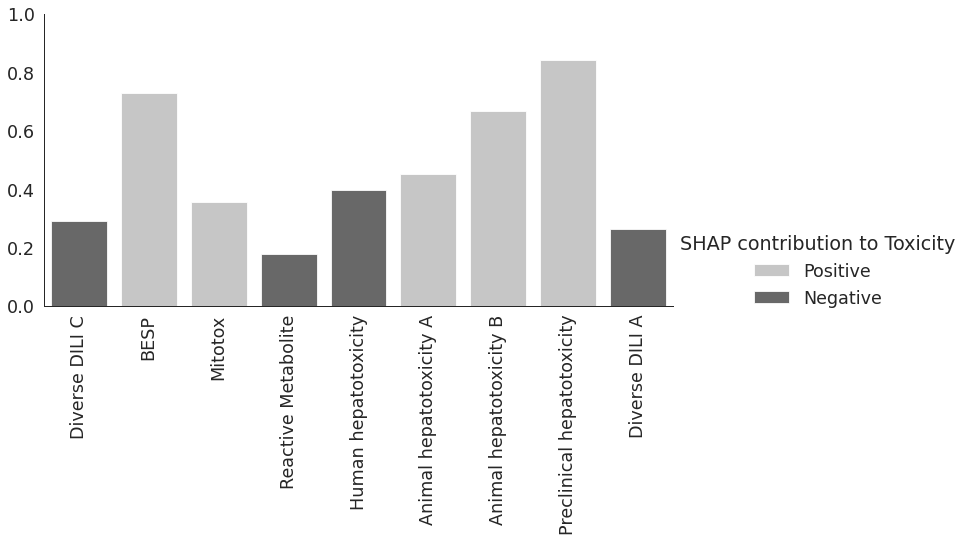

In [24]:
import seaborn as sns
SHAP =pd.DataFrame(columns=['name', 'source', 'assaytype', 'SHAP', 'description', 'value', 'pred','influence', 'smiles'])
SHAP = pd.concat([SHAP, proxy_DILI_SHAP_top])
SHAP = pd.concat([SHAP, proxy_DILI_SHAP_bottom])
SHAP["name"] = SHAP["name"].astype(str)
SHAP = SHAP.sort_values(by=["name"], ascending=True)
#fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
sns.set_style('white')
sns.set_context('paper', font_scale=2)
hue_order = ['Positive', 'Negative']
#sns.barplot(data=compound, x="source", y="value", color='grey')
g = sns.catplot(data=SHAP, x="source", y="value", kind="bar", hue_order=hue_order,  hue="SHAP contribution to Toxicity",  
                palette="Greys", height=5, aspect=2, dodge=False, legend=True)
#plt.axhline(y=0.5, color='r', linestyle='--')
g.set_xticklabels(rotation=90)
g.set(ylabel=None)
g.set(xlabel=None)
g.set(ylim=(0, 1))
plt.show()

In [25]:
SHAP

name                      source                     assaytype      SHAP  \
2   11              Diverse DILI C            Heterogenous Data  -0.004658   
3   14                        BESP  Mechanisms of Liver Toxicity  0.000195   
4   15                     Mitotox  Mechanisms of Liver Toxicity  0.009352   
3   16         Reactive Metabolite  Mechanisms of Liver Toxicity -0.000182   
0    3        Human hepatotoxicity          Human hepatotoxicity -0.002804   
0    5     Animal hepatotoxicity A         Animal hepatotoxicity  0.002067   
1    6     Animal hepatotoxicity B         Animal hepatotoxicity   0.00145   
2    7  Preclinical hepatotoxicity         Animal hepatotoxicity  0.015049   
1    8              Diverse DILI A            Heterogenous Data  -0.004488   

                                         description     value   pred  \
2  Transient liver function abnormalities, advers...  0.291598  False   
3              BESP Bile Salt Export Pump Inhibition  0.727052   True   
4                                           Mitotox   0.357161  False   
3                      Reactive Metabolite Formation  0.176949  False   
0                Human hepatotoxicity, hepatobiallry  0.397658  False   
0  Rat, chronic oral administration, Hepatic hist...  0.449865  False   
1       Hepatocellular hypertrophy, rats, ORAD, HESS  0.665545   True   
2  Preclinical hepatotoxicity data from PharmaPen...  0.842213   True   
1  Large-scale and diverse ddrug induced liver in...  0.261737  False   

  influence                                            smiles  \
2       NaN  COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)c(C)c1C   
3       NaN  COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)c(C)c1C   
4       NaN  COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)c(C)c1C   
3       NaN  COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)c(C)c1C   
0       NaN  COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)c(C)c1C   
0       NaN  COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)c(C)c1C   
1       NaN  COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)c(C)c1C   
2       NaN  COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)c(C)c1C   
1       NaN  COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)c(C)c1C   

  SHAP contribution to Toxicity  
2                      Negative  
3                      Positive  
4                      Positive  
3                      Negative  
0                      Negative  
0                      Positive  
1                      Positive  
2                      Positive  
1                      Negative

In [26]:
SHAP

name                      source                     assaytype      SHAP  \
2   11              Diverse DILI C            Heterogenous Data  -0.004658   
3   14                        BESP  Mechanisms of Liver Toxicity  0.000195   
4   15                     Mitotox  Mechanisms of Liver Toxicity  0.009352   
3   16         Reactive Metabolite  Mechanisms of Liver Toxicity -0.000182   
0    3        Human hepatotoxicity          Human hepatotoxicity -0.002804   
0    5     Animal hepatotoxicity A         Animal hepatotoxicity  0.002067   
1    6     Animal hepatotoxicity B         Animal hepatotoxicity   0.00145   
2    7  Preclinical hepatotoxicity         Animal hepatotoxicity  0.015049   
1    8              Diverse DILI A            Heterogenous Data  -0.004488   

                                         description     value   pred  \
2  Transient liver function abnormalities, advers...  0.291598  False   
3              BESP Bile Salt Export Pump Inhibition  0.727052   True   
4                                           Mitotox   0.357161  False   
3                      Reactive Metabolite Formation  0.176949  False   
0                Human hepatotoxicity, hepatobiallry  0.397658  False   
0  Rat, chronic oral administration, Hepatic hist...  0.449865  False   
1       Hepatocellular hypertrophy, rats, ORAD, HESS  0.665545   True   
2  Preclinical hepatotoxicity data from PharmaPen...  0.842213   True   
1  Large-scale and diverse ddrug induced liver in...  0.261737  False   

  influence                                            smiles  \
2       NaN  COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)c(C)c1C   
3       NaN  COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)c(C)c1C   
4       NaN  COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)c(C)c1C   
3       NaN  COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)c(C)c1C   
0       NaN  COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)c(C)c1C   
0       NaN  COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)c(C)c1C   
1       NaN  COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)c(C)c1C   
2       NaN  COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)c(C)c1C   
1       NaN  COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)c(C)c1C   

  SHAP contribution to Toxicity  
2                      Negative  
3                      Positive  
4                      Positive  
3                      Negative  
0                      Negative  
0                      Positive  
1                      Positive  
2                      Positive  
1                      Negative

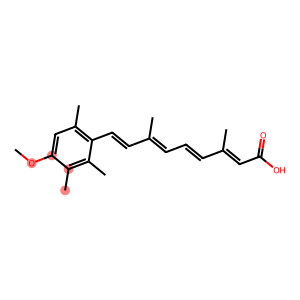

In [27]:
Draw.MolToImage(molecule, highlightAtoms=molecule.GetSubstructMatch(top_MACCSsubstructure), width=40)

In [28]:
test_mfp_Mordred_liv

smiles_r  Mfp0  Mfp1  Mfp2  Mfp3  \
0  COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)c(C)c1C     0     0     0     0   

   Mfp4  Mfp5  Mfp6  Mfp7  Mfp8  ...         5         6         7         8  \
0     0     0     0     0     0  ...  0.449865  0.665545  0.842213  0.261737   

         11        14        15        16  \
0  0.291598  0.727052  0.357161  0.176949   

   median pMolar unbound plasma concentration  \
0                                    7.111403   

   median pMolar total plasma concentration  
0                                   6.19151  

[1 rows x 3855 columns]

In [29]:
test_mfp_Mordred_liv_values

name  \
0                                       smiles_r   
1                                           Mfp0   
2                                           Mfp1   
3                                           Mfp2   
4                                           Mfp3   
...                                          ...   
3850                                          14   
3851                                          15   
3852                                          16   
3853  median pMolar unbound plasma concentration   
3854    median pMolar total plasma concentration   

                                                 value  
0     COc1cc(C)c(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)c(C)c1C  
1                                                    0  
2                                                    0  
3                                                    0  
4                                                    0  
...                                                ...  
3850                                          0.727052  
3851                                          0.357161  
3852                                          0.176949  
3853                                          7.111403  
3854                                           6.19151  

[3855 rows x 2 columns]

In [30]:
smiles_list = literature.smiles_r.to_list()
smiles_list

['COc1cc(C)c(C=CC(C)=CC=CC(C)=CC(=O)O)c(C)c1C',
 'COC1=C2C(C)C(OC(=O)C(O)C(NC(=O)OC(C)(C)C)c3ccccc3)CC(O)(C(OC(=O)c3ccccc3)C3C4(OC(C)=O)COC4CC(OC)C3(C)C1=O)C2(C)C',
 'COC(=O)C(c1ccccc1Cl)N1CCc2sccc2C1',
 'CC(=O)OC12COC1CC(O)C1(C)C(=O)C(=O)C3C(C)C(OC(=O)C(O)C(NC(=O)OC(C)(C)C)c4ccccc4)CC(O)(C(OC(=O)c4ccccc4)C21)C3(C)C',
 'CC1c2cccc(O)c2C(=O)C2C(=O)C3(O)C(=O)C(C(N)=O)C(=O)C(N(C)C)C3C(O)C21',
 'CCN(CC)C(=O)C(C#N)=Cc1cc(O)c(O)c([N+](=O)[O-])c1',
 'N=c1ccn(C2OC(CO)C(O)C2(F)F)c(=O)[nH]1',
 'CN(C)c1ccc(O)c2c1CC1CC3C(N(C)C)C(=O)C(C(N)=O)C(=O)C3(O)C(=O)C1C2=O',
 'COc1c(N2CC3CCCNC3C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC3)c12',
 'CC(=O)OC1=C2C(C)C(OC(=O)C(O)C(NC(=O)c3ccccc3)c3ccccc3)CC(O)(C(OC(=O)c3ccccc3)C3C4(OC(C)=O)COC4CC(O)C3(C)C1=O)C2(C)C',
 'NC1C2CN(c3nc4c(cc3F)c(=O)c(C(=O)O)cn4-c3ccc(F)cc3F)CC12',
 'CCOC(=O)CNC(C(=O)N1CCC1C(=O)NCc1ccc(C(N)=NO)cc1)C1CCCCC1']

In [31]:
names= literature.name.to_list()
names

['Acitretin',
 'Cabazitaxel',
 'Clopidogrel',
 'Docetaxel',
 'Doxycycline',
 'Entacapone',
 'Gemcitabine',
 'Minocycline',
 'Moxifloxacin',
 'Paclitaxel',
 'Trovafloxacin',
 'Ximelagatran']

In [32]:
for name in names:
    print(name)

Acitretin
Cabazitaxel
Clopidogrel
Docetaxel
Doxycycline
Entacapone
Gemcitabine
Minocycline
Moxifloxacin
Paclitaxel
Trovafloxacin
Ximelagatran


COc1cc(C)c(C=CC(C)=CC=CC(C)=CC(=O)O)c(C)c1C
Acitretin
1613


100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.33it/s]


Best Threshold=0.612911


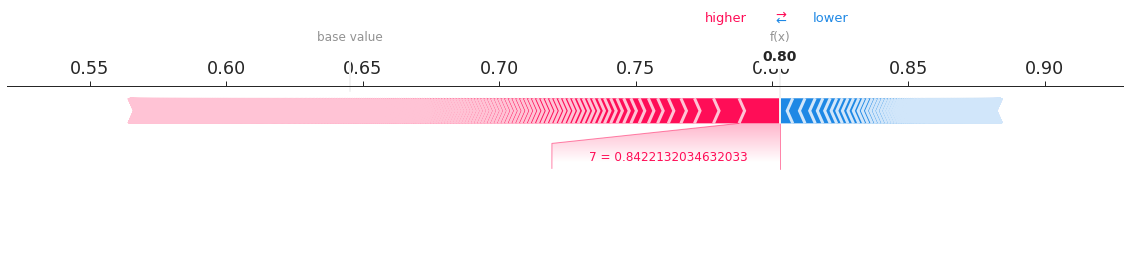

0.8029690107536119
1
Positive
unbound Cmax:  0.08 uM
total Cmax:  0.64 uM
Most contributing MACCS substructure to DILI toxicity
*!@*@*!@*
[O;!H0]
COC1=C2C(C)C(OC(=O)C(O)C(NC(=O)OC(C)(C)C)c3ccccc3)CC(O)(C(OC(=O)c3ccccc3)C3C4(OC(C)=O)COC4CC(OC)C3(C)C1=O)C2(C)C
Cabazitaxel
1613


100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


Best Threshold=0.612911


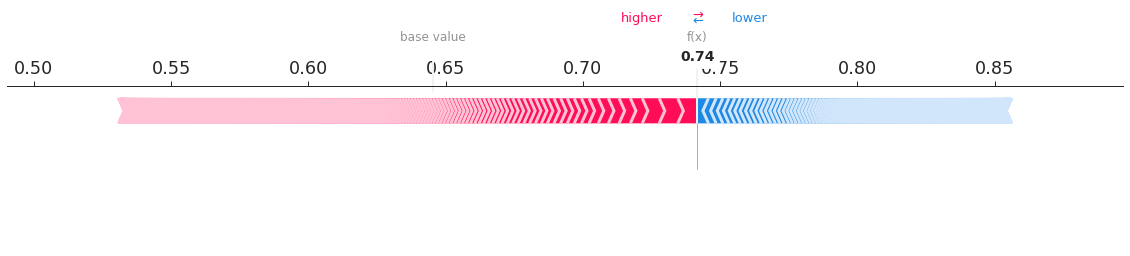

0.7416151409272655
1
Positive
unbound Cmax:  0.14 uM
total Cmax:  0.64 uM
Most contributing MACCS substructure to DILI toxicity
*!@*@*!@*
[!#6;!#1;!H0]~*~[CH2]~*
COC(=O)C(c1ccccc1Cl)N1CCc2sccc2C1
Clopidogrel
1613


100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


Best Threshold=0.612911


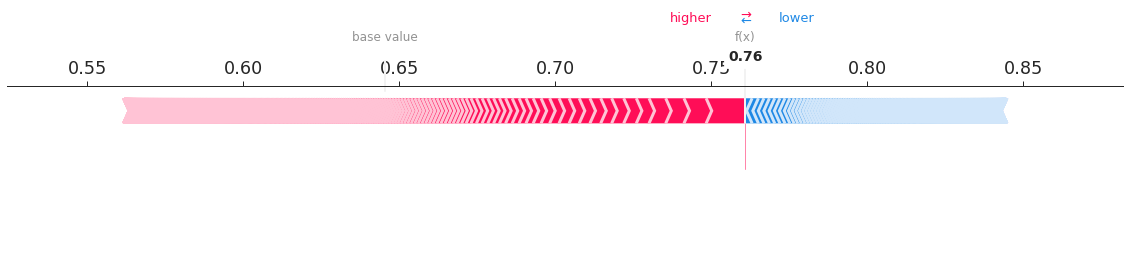

0.7609516807373925
1
Positive
unbound Cmax:  0.05 uM
total Cmax:  0.85 uM
Most contributing MACCS substructure to DILI toxicity
[#16]
*~[CH2]~[#7]
CC(=O)OC12COC1CC(O)C1(C)C(=O)C(=O)C3C(C)C(OC(=O)C(O)C(NC(=O)OC(C)(C)C)c4ccccc4)CC(O)(C(OC(=O)c4ccccc4)C21)C3(C)C
Docetaxel
1613


100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]


Best Threshold=0.612911


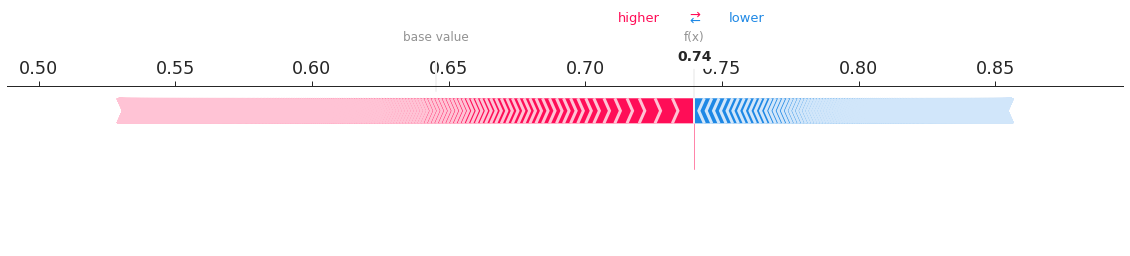

0.7398619659775268
1
Positive
unbound Cmax:  0.17 uM
total Cmax:  1.21 uM
Most contributing MACCS substructure to DILI toxicity
*!@*@*!@*
[!#6;!#1;!H0]~*~[CH2]~*
CC1c2cccc(O)c2C(=O)C2C(=O)C3(O)C(=O)C(C(N)=O)C(=O)C(N(C)C)C3C(O)C21
Doxycycline
1613


100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.24it/s]


Best Threshold=0.612911


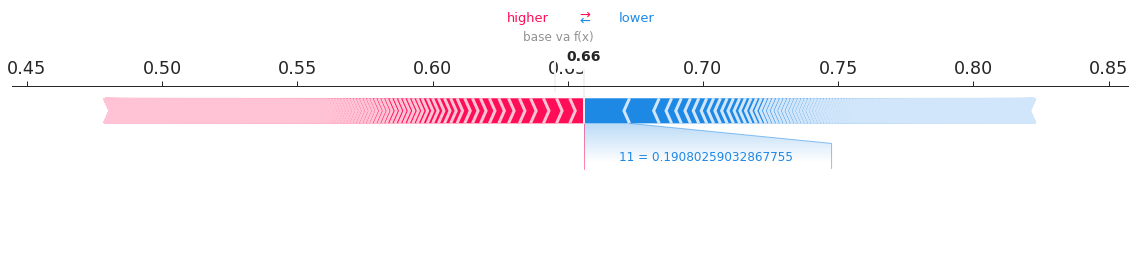

0.6560019565062682
1
Positive
unbound Cmax:  1.53 uM
total Cmax:  8.36 uM
Most contributing MACCS substructure to DILI toxicity
*!@*@*!@*
[!#6;!#1;!H0]~*~*~*~[!#6;!#1;!H0]
CCN(CC)C(=O)C(C#N)=Cc1cc(O)c(O)c([N+](=O)[O-])c1
Entacapone
1613


100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Best Threshold=0.612911


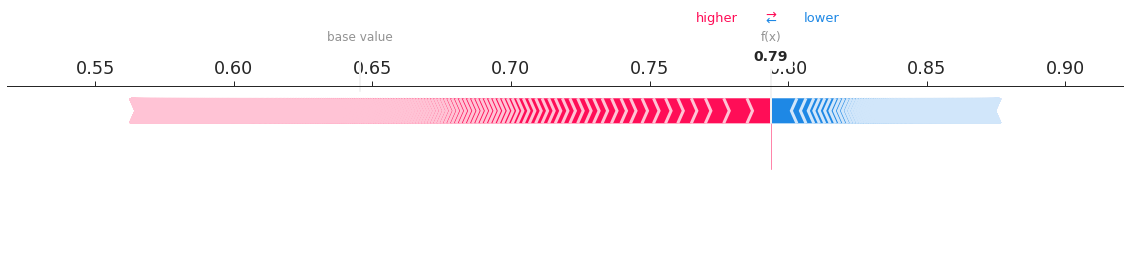

0.7936674885673619
1
Positive
unbound Cmax:  0.82 uM
total Cmax:  14.83 uM
Most contributing MACCS substructure to DILI toxicity
*@*!@[#7]
*~[CH2]~[#7]
N=c1ccn(C2OC(CO)C(O)C2(F)F)c(=O)[nH]1
Gemcitabine
1613


100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


Best Threshold=0.612911


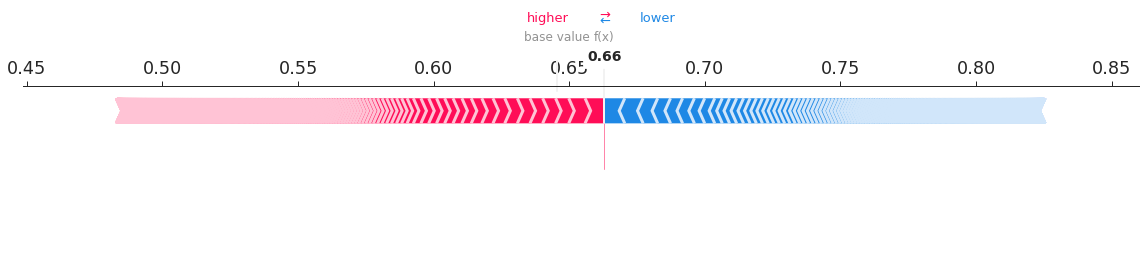

0.6629327207356598
1
Positive
unbound Cmax:  5.9 uM
total Cmax:  14.08 uM
Most contributing MACCS substructure to DILI toxicity
*@*!@[#7]
*~[CH2]~[!#6;!#1;!H0]
CN(C)c1ccc(O)c2c1CC1CC3C(N(C)C)C(=O)C(C(N)=O)C(=O)C3(O)C(=O)C1C2=O
Minocycline
1613


100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.23it/s]


Best Threshold=0.612911


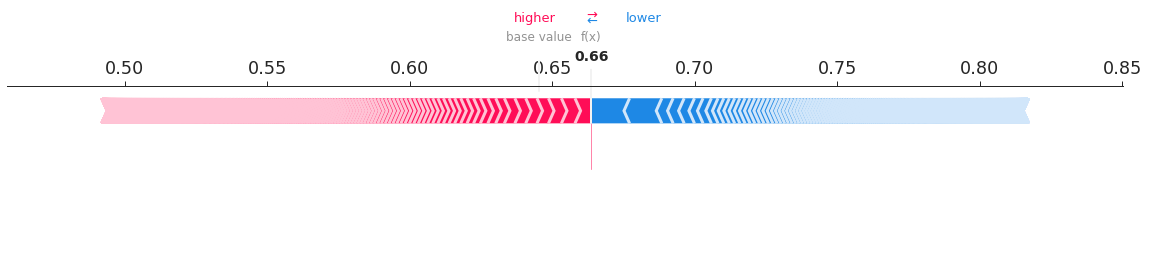

0.6636515950190887
1
Positive
unbound Cmax:  0.07 uM
total Cmax:  1.93 uM
Most contributing MACCS substructure to DILI toxicity
*!@*@*!@*
[#6]~[#7](~[#6])~[#6]
COc1c(N2CC3CCCNC3C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC3)c12
Moxifloxacin
1613


100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


Best Threshold=0.612911


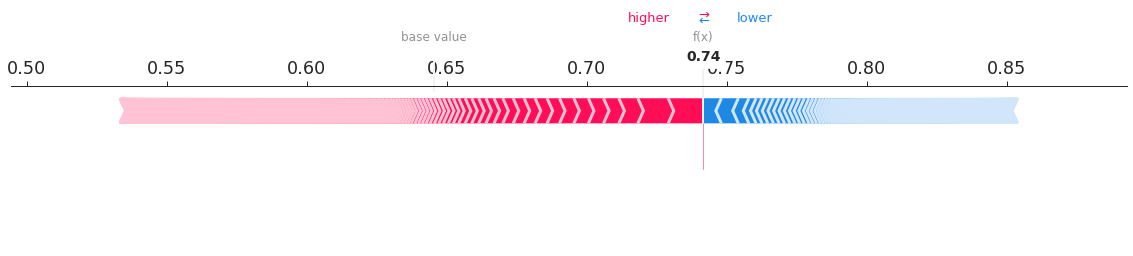

0.7416704867165972
1
Positive
unbound Cmax:  0.17 uM
total Cmax:  2.66 uM
Most contributing MACCS substructure to DILI toxicity
*!@*@*!@*
*~[CH2]~[!#6;!#1;!H0]
CC(=O)OC1=C2C(C)C(OC(=O)C(O)C(NC(=O)c3ccccc3)c3ccccc3)CC(O)(C(OC(=O)c3ccccc3)C3C4(OC(C)=O)COC4CC(O)C3(C)C1=O)C2(C)C
Paclitaxel
1613


100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


Best Threshold=0.612911


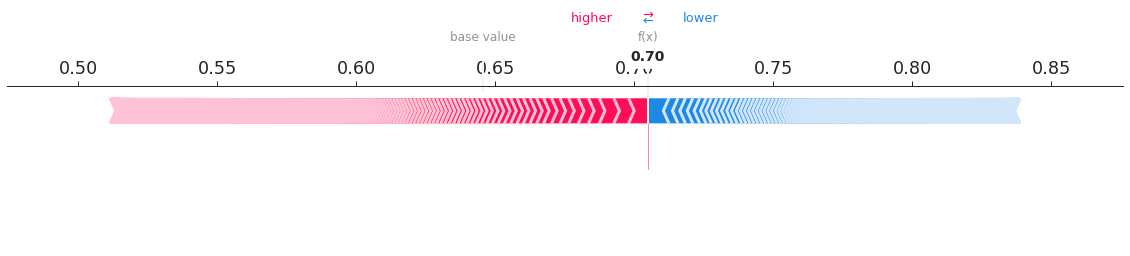

0.7048055384547541
1
Positive
unbound Cmax:  0.27 uM
total Cmax:  2.46 uM
Most contributing MACCS substructure to DILI toxicity
*!@*@*!@*
[!#6;!#1;!H0]~*~[CH2]~*
NC1C2CN(c3nc4c(cc3F)c(=O)c(C(=O)O)cn4-c3ccc(F)cc3F)CC12
Trovafloxacin
1613


100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]


Best Threshold=0.612911


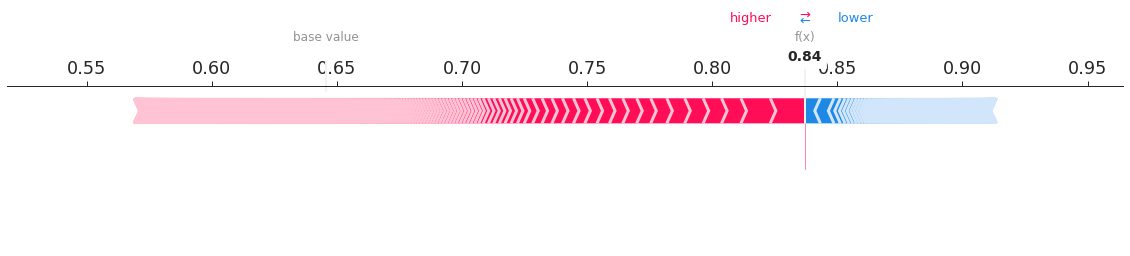

0.8369714881443368
1
Positive
unbound Cmax:  0.54 uM
total Cmax:  5.1 uM
Most contributing MACCS substructure to DILI toxicity
*@*!@[#7]
*~[CH2]~[#7]
CCOC(=O)CNC(C(=O)N1CCC1C(=O)NCc1ccc(C(N)=NO)cc1)C1CCCCC1
Ximelagatran
1613


100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]


Best Threshold=0.612911


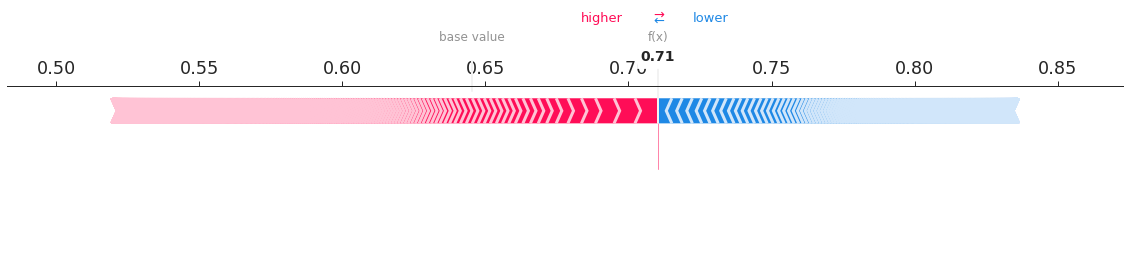

0.710334615284306
1
Positive
unbound Cmax:  0.08 uM
total Cmax:  0.51 uM
Most contributing MACCS substructure to DILI toxicity
[CH3]~[CH2]~*
*~[CH2]~[!#6;!#1;!H0]


In [33]:
list_of_lists=[]
SHAP =pd.DataFrame(columns=['name', 'source', 'assaytype', 'SHAP', 'description', 'value', 'pred','influence', 'smiles'])

for s, n in zip(smiles_list, names):  
    
    print(s)
    print(n)
    smiles = unquote(s)
    
    smiles_r = standardized_smiles(smiles)
    test = {'smiles_r':  [smiles_r]
                }
    test = pd.DataFrame(test)
    
    test_mfp_Mordred = calc_all_fp_desc(test)
    
    test_mfp_Mordred_liv = predict_liv_all(test_mfp_Mordred)
    test_mfp_Mordred_liv_values = test_mfp_Mordred_liv.T.reset_index().rename(columns={"index":"name", 0: "value"})
    
    desc=pd.read_csv("all_features_desc.csv", encoding='windows-1252')

    interpret, y_proba, y_pred = predict_DILI(test_mfp_Mordred_liv)   
    interpret = pd.merge(interpret, desc, right_on="name", left_on="name", how="outer")
    interpret = pd.merge(interpret, test_mfp_Mordred_liv_values, right_on="name", left_on="name", how="inner") 

    print(y_proba[0])
    print(y_pred[0])
    
    if(y_pred[0] == 0):
        print("Negative")
    else:
        print("Positive")
        
    print("unbound Cmax: ", np.round(10**-test_mfp_Mordred_liv["median pMolar unbound plasma concentration"][0] *10**6, 2), "uM")
    print("total Cmax: ", np.round(10**-test_mfp_Mordred_liv["median pMolar total plasma concentration"][0] *10**6, 2), "uM")
    print("Most contributing MACCS substructure to DILI toxicity")
        
    top = interpret[interpret["SHAP"]>0].sort_values(by=["SHAP"], ascending=False)#.reset_index(drop=True)
    proxy_DILI_SHAP_top = pd.merge(info, top[top["name"].isin(liv_data)])
    proxy_DILI_SHAP_top["pred"] = proxy_DILI_SHAP_top["value"]>0.50
    proxy_DILI_SHAP_top["SHAP contribution to Toxicity"] = "Positive"
    proxy_DILI_SHAP_top["smiles"] = s
    proxy_DILI_SHAP_top["compound"] = n
    
    top_positives = top[top["value"]==1]
    top_MACCS= top_positives[top_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["description"].values[0]
    print(top_MACCS)
    
    bottom = interpret[interpret["SHAP"]<0].sort_values(by=["SHAP"], ascending=True)#.reset_index(drop=True)
    proxy_DILI_SHAP_bottom = pd.merge(info, bottom[bottom["name"].isin(liv_data)])
    proxy_DILI_SHAP_bottom["pred"] = proxy_DILI_SHAP_bottom["value"]>0.50
    proxy_DILI_SHAP_bottom["SHAP contribution to Toxicity"] = "Negative"
    proxy_DILI_SHAP_bottom["smiles"] = s
    proxy_DILI_SHAP_bottom["compound"] = n
    
    bottom_positives = bottom[bottom["value"]==1]
    bottom_MACCS= bottom_positives[bottom_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["description"].values[0]
    print(bottom_MACCS)
    
    SHAP = pd.concat([SHAP, proxy_DILI_SHAP_top])
    SHAP = pd.concat([SHAP, proxy_DILI_SHAP_bottom])
    
    
    row=[s, n, top_MACCS, bottom_MACCS]
    list_of_lists.append(row)
    

In [34]:
top

name          SHAP  \
859          3  8.057587e-03   
862          7  7.297447e-03   
492       MIC5  6.515191e-03   
490       MIC3  4.905373e-03   
864         11  4.716906e-03   
..         ...           ...   
44       ATS0Z  1.820142e-06   
165     ATSC3m  1.724372e-06   
25          nX  1.705037e-06   
507  PEOE_VSA4  1.378596e-06   
669     Mfp378  5.000500e-07   

                                           description       value  
859                Human hepatotoxicity, hepatobiallry    0.693316  
862  Preclinical hepatotoxicity data from PharmaPen...    0.693368  
492             5-ordered modified information content    40.72118  
490             3-ordered modified information content    40.64069  
864  Transient liver function abnormalities, advers...     0.56603  
..                                                 ...         ...  
44   moreau-broto autocorrelation of lag 0 weighted...      1464.0  
165                                                NaN  308.316299  
25                             number of halogen atoms         0.0  
507   MOE Charge VSA Descriptor 4 (-0.20 <= x < -0.15)         0.0  
669                                                NaN           0  

[449 rows x 4 columns]

In [35]:
SHAP["name"] = SHAP["name"].astype(int)
SHAP

name                      source                     assaytype      SHAP  \
0      5     Animal hepatotoxicity A         Animal hepatotoxicity  0.002067   
1      6     Animal hepatotoxicity B         Animal hepatotoxicity   0.00145   
2      7  Preclinical hepatotoxicity         Animal hepatotoxicity  0.015049   
3     14                        BESP  Mechanisms of Liver Toxicity  0.000195   
4     15                     Mitotox  Mechanisms of Liver Toxicity  0.009352   
..   ...                         ...                           ...       ...   
4     16         Reactive Metabolite  Mechanisms of Liver Toxicity  0.001659   
0      5     Animal hepatotoxicity A         Animal hepatotoxicity -0.002691   
1      6     Animal hepatotoxicity B         Animal hepatotoxicity -0.000804   
2      8              Diverse DILI A            Heterogenous Data  -0.000977   
3     15                     Mitotox  Mechanisms of Liver Toxicity -0.004819   

                                          description     value   pred  \
0   Rat, chronic oral administration, Hepatic hist...  0.449865  False   
1        Hepatocellular hypertrophy, rats, ORAD, HESS  0.665545   True   
2   Preclinical hepatotoxicity data from PharmaPen...  0.842213   True   
3               BESP Bile Salt Export Pump Inhibition  0.727052   True   
4                                            Mitotox   0.357161  False   
..                                                ...       ...    ...   
4                       Reactive Metabolite Formation  0.068354  False   
0   Rat, chronic oral administration, Hepatic hist...  0.136624  False   
1        Hepatocellular hypertrophy, rats, ORAD, HESS  0.240991  False   
2   Large-scale and diverse ddrug induced liver in...   0.37566  False   
3                                            Mitotox   0.045315  False   

   influence                                             smiles  \
0        NaN        COc1cc(C)c(C=CC(C)=CC=CC(C)=CC(=O)O)c(C)c1C   
1        NaN        COc1cc(C)c(C=CC(C)=CC=CC(C)=CC(=O)O)c(C)c1C   
2        NaN        COc1cc(C)c(C=CC(C)=CC=CC(C)=CC(=O)O)c(C)c1C   
3        NaN        COc1cc(C)c(C=CC(C)=CC=CC(C)=CC(=O)O)c(C)c1C   
4        NaN        COc1cc(C)c(C=CC(C)=CC=CC(C)=CC(=O)O)c(C)c1C   
..       ...                                                ...   
4        NaN  CCOC(=O)CNC(C(=O)N1CCC1C(=O)NCc1ccc(C(N)=NO)cc...   
0        NaN  CCOC(=O)CNC(C(=O)N1CCC1C(=O)NCc1ccc(C(N)=NO)cc...   
1        NaN  CCOC(=O)CNC(C(=O)N1CCC1C(=O)NCc1ccc(C(N)=NO)cc...   
2        NaN  CCOC(=O)CNC(C(=O)N1CCC1C(=O)NCc1ccc(C(N)=NO)cc...   
3        NaN  CCOC(=O)CNC(C(=O)N1CCC1C(=O)NCc1ccc(C(N)=NO)cc...   

   SHAP contribution to Toxicity      compound  
0                       Positive     Acitretin  
1                       Positive     Acitretin  
2                       Positive     Acitretin  
3                       Positive     Acitretin  
4                       Positive     Acitretin  
..                           ...           ...  
4                       Positive  Ximelagatran  
0                       Negative  Ximelagatran  
1                       Negative  Ximelagatran  
2                       Negative  Ximelagatran  
3                       Negative  Ximelagatran  

[108 rows x 11 columns]

In [36]:
SHAP.to_csv("./SHAP_molecules/SHAP_molecules_12.csv", index=False)

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns


Acitretin
9


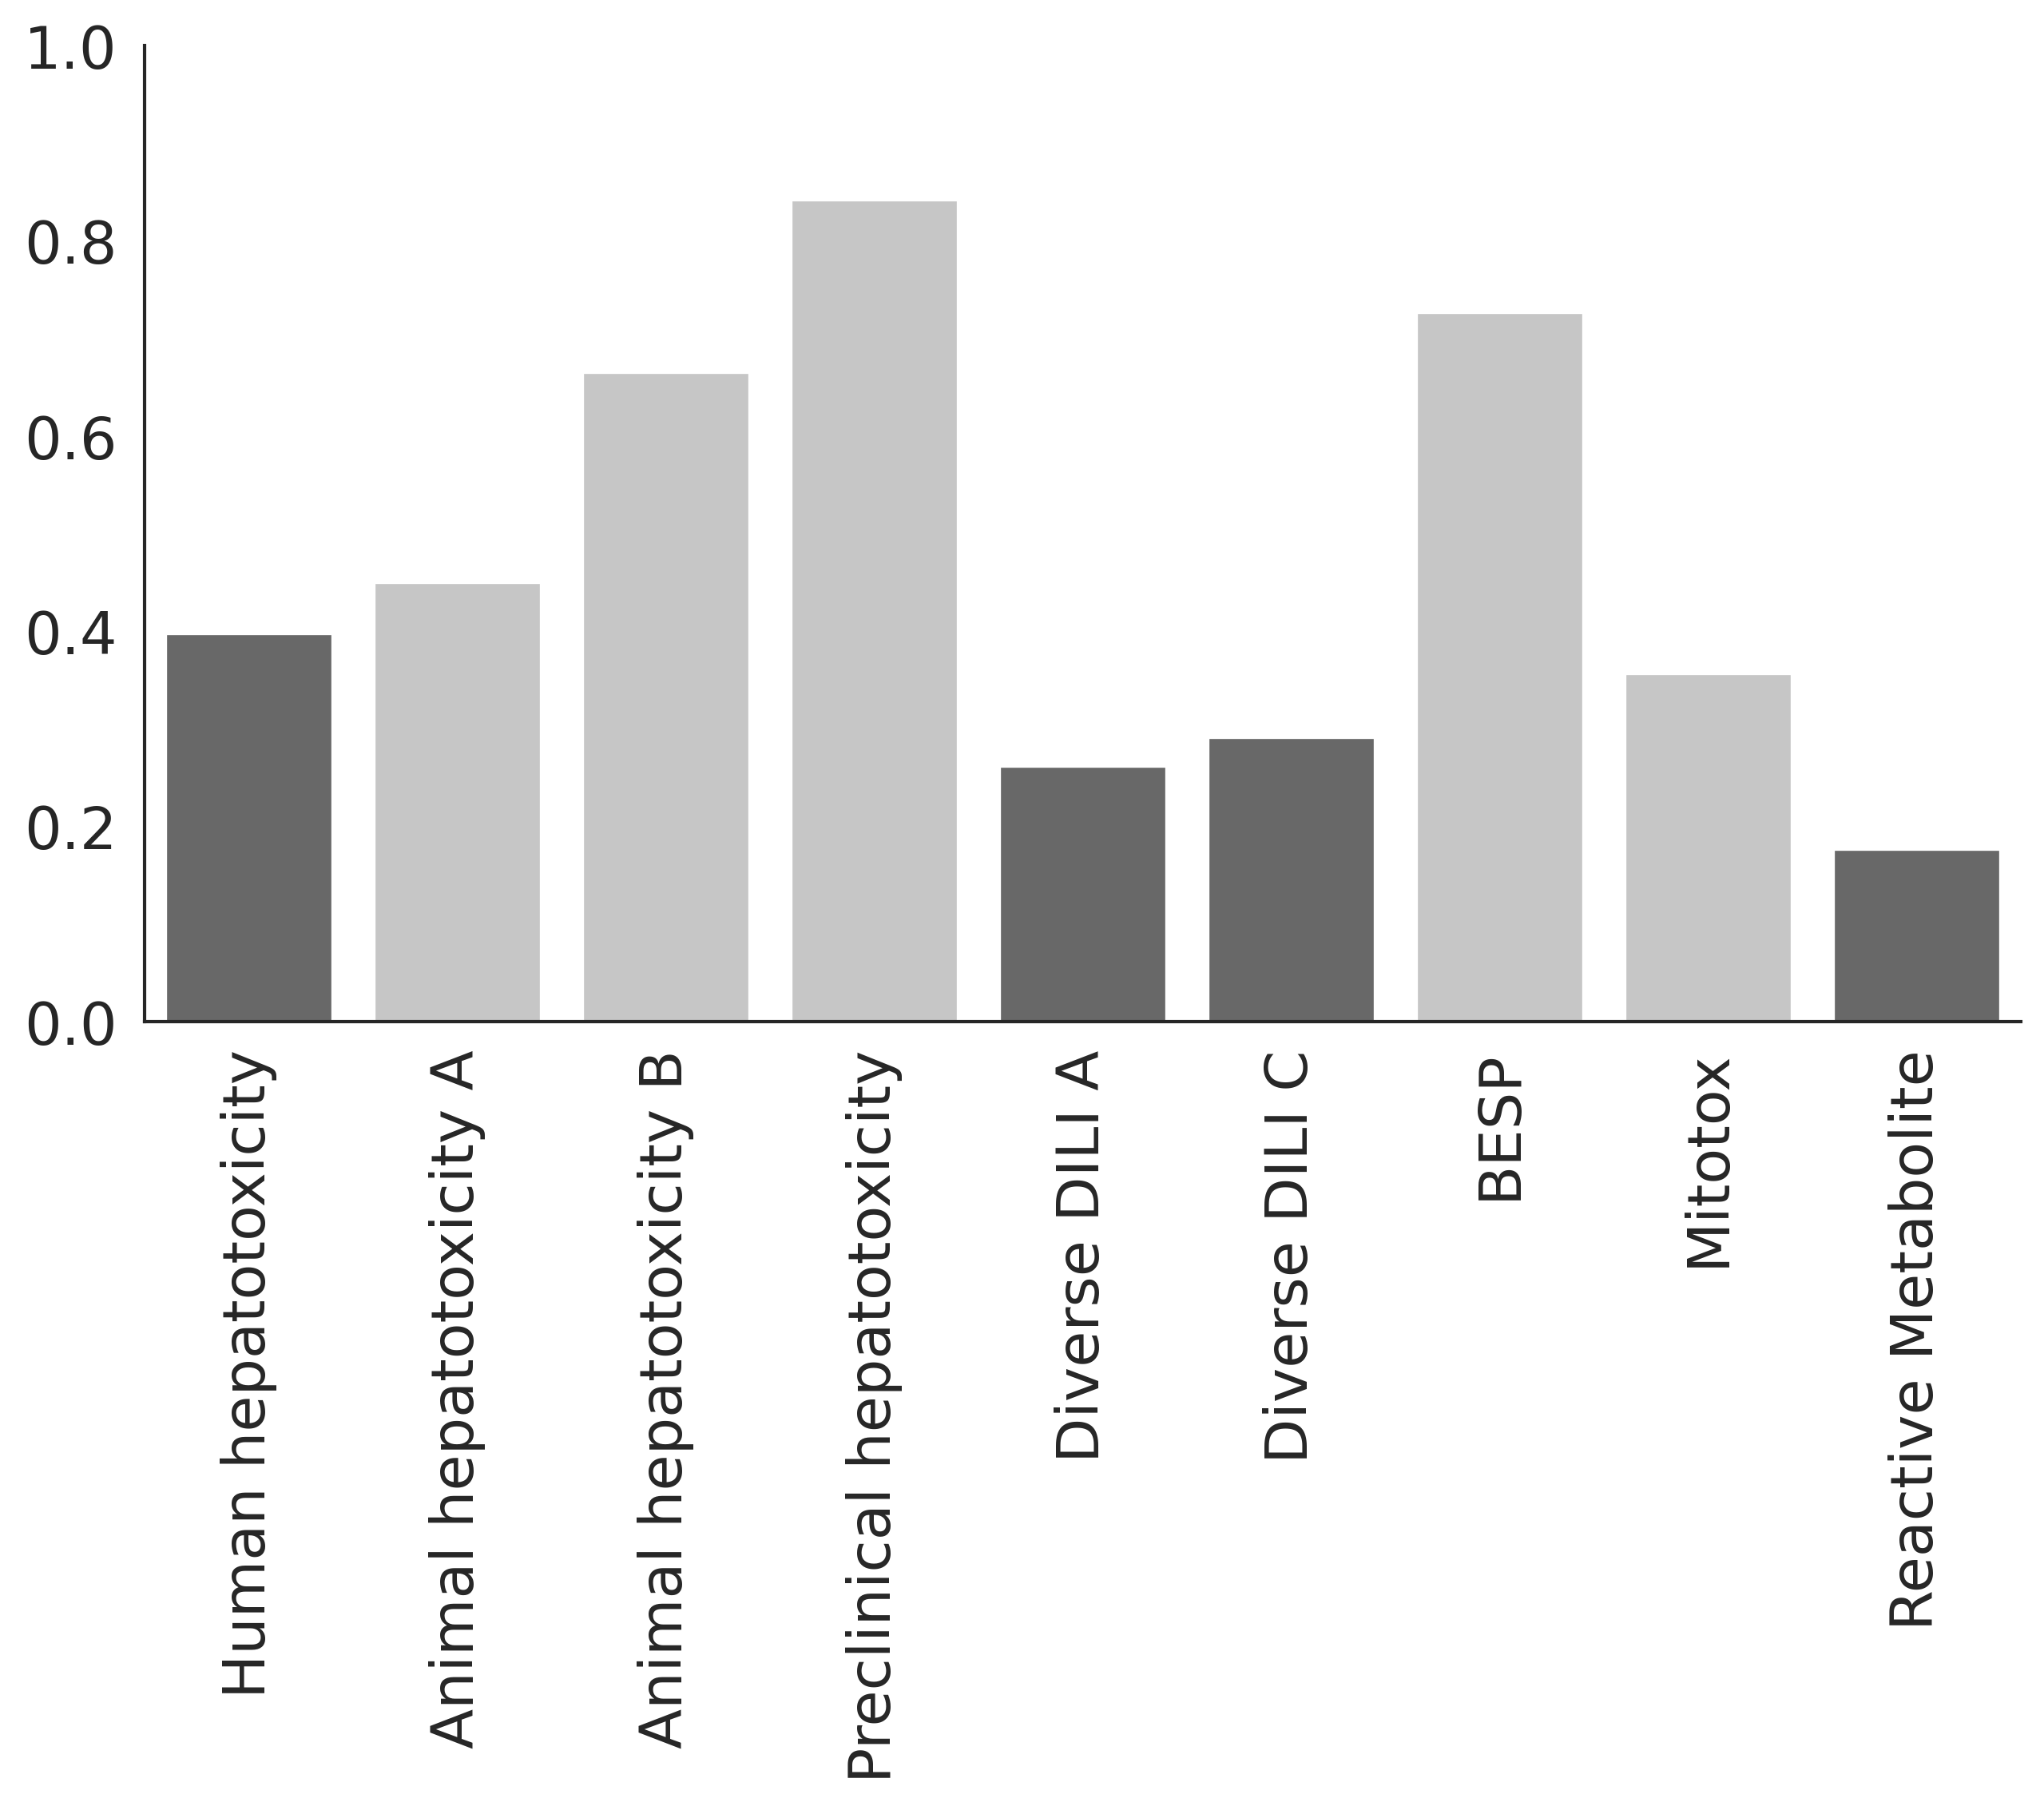

Cabazitaxel
9


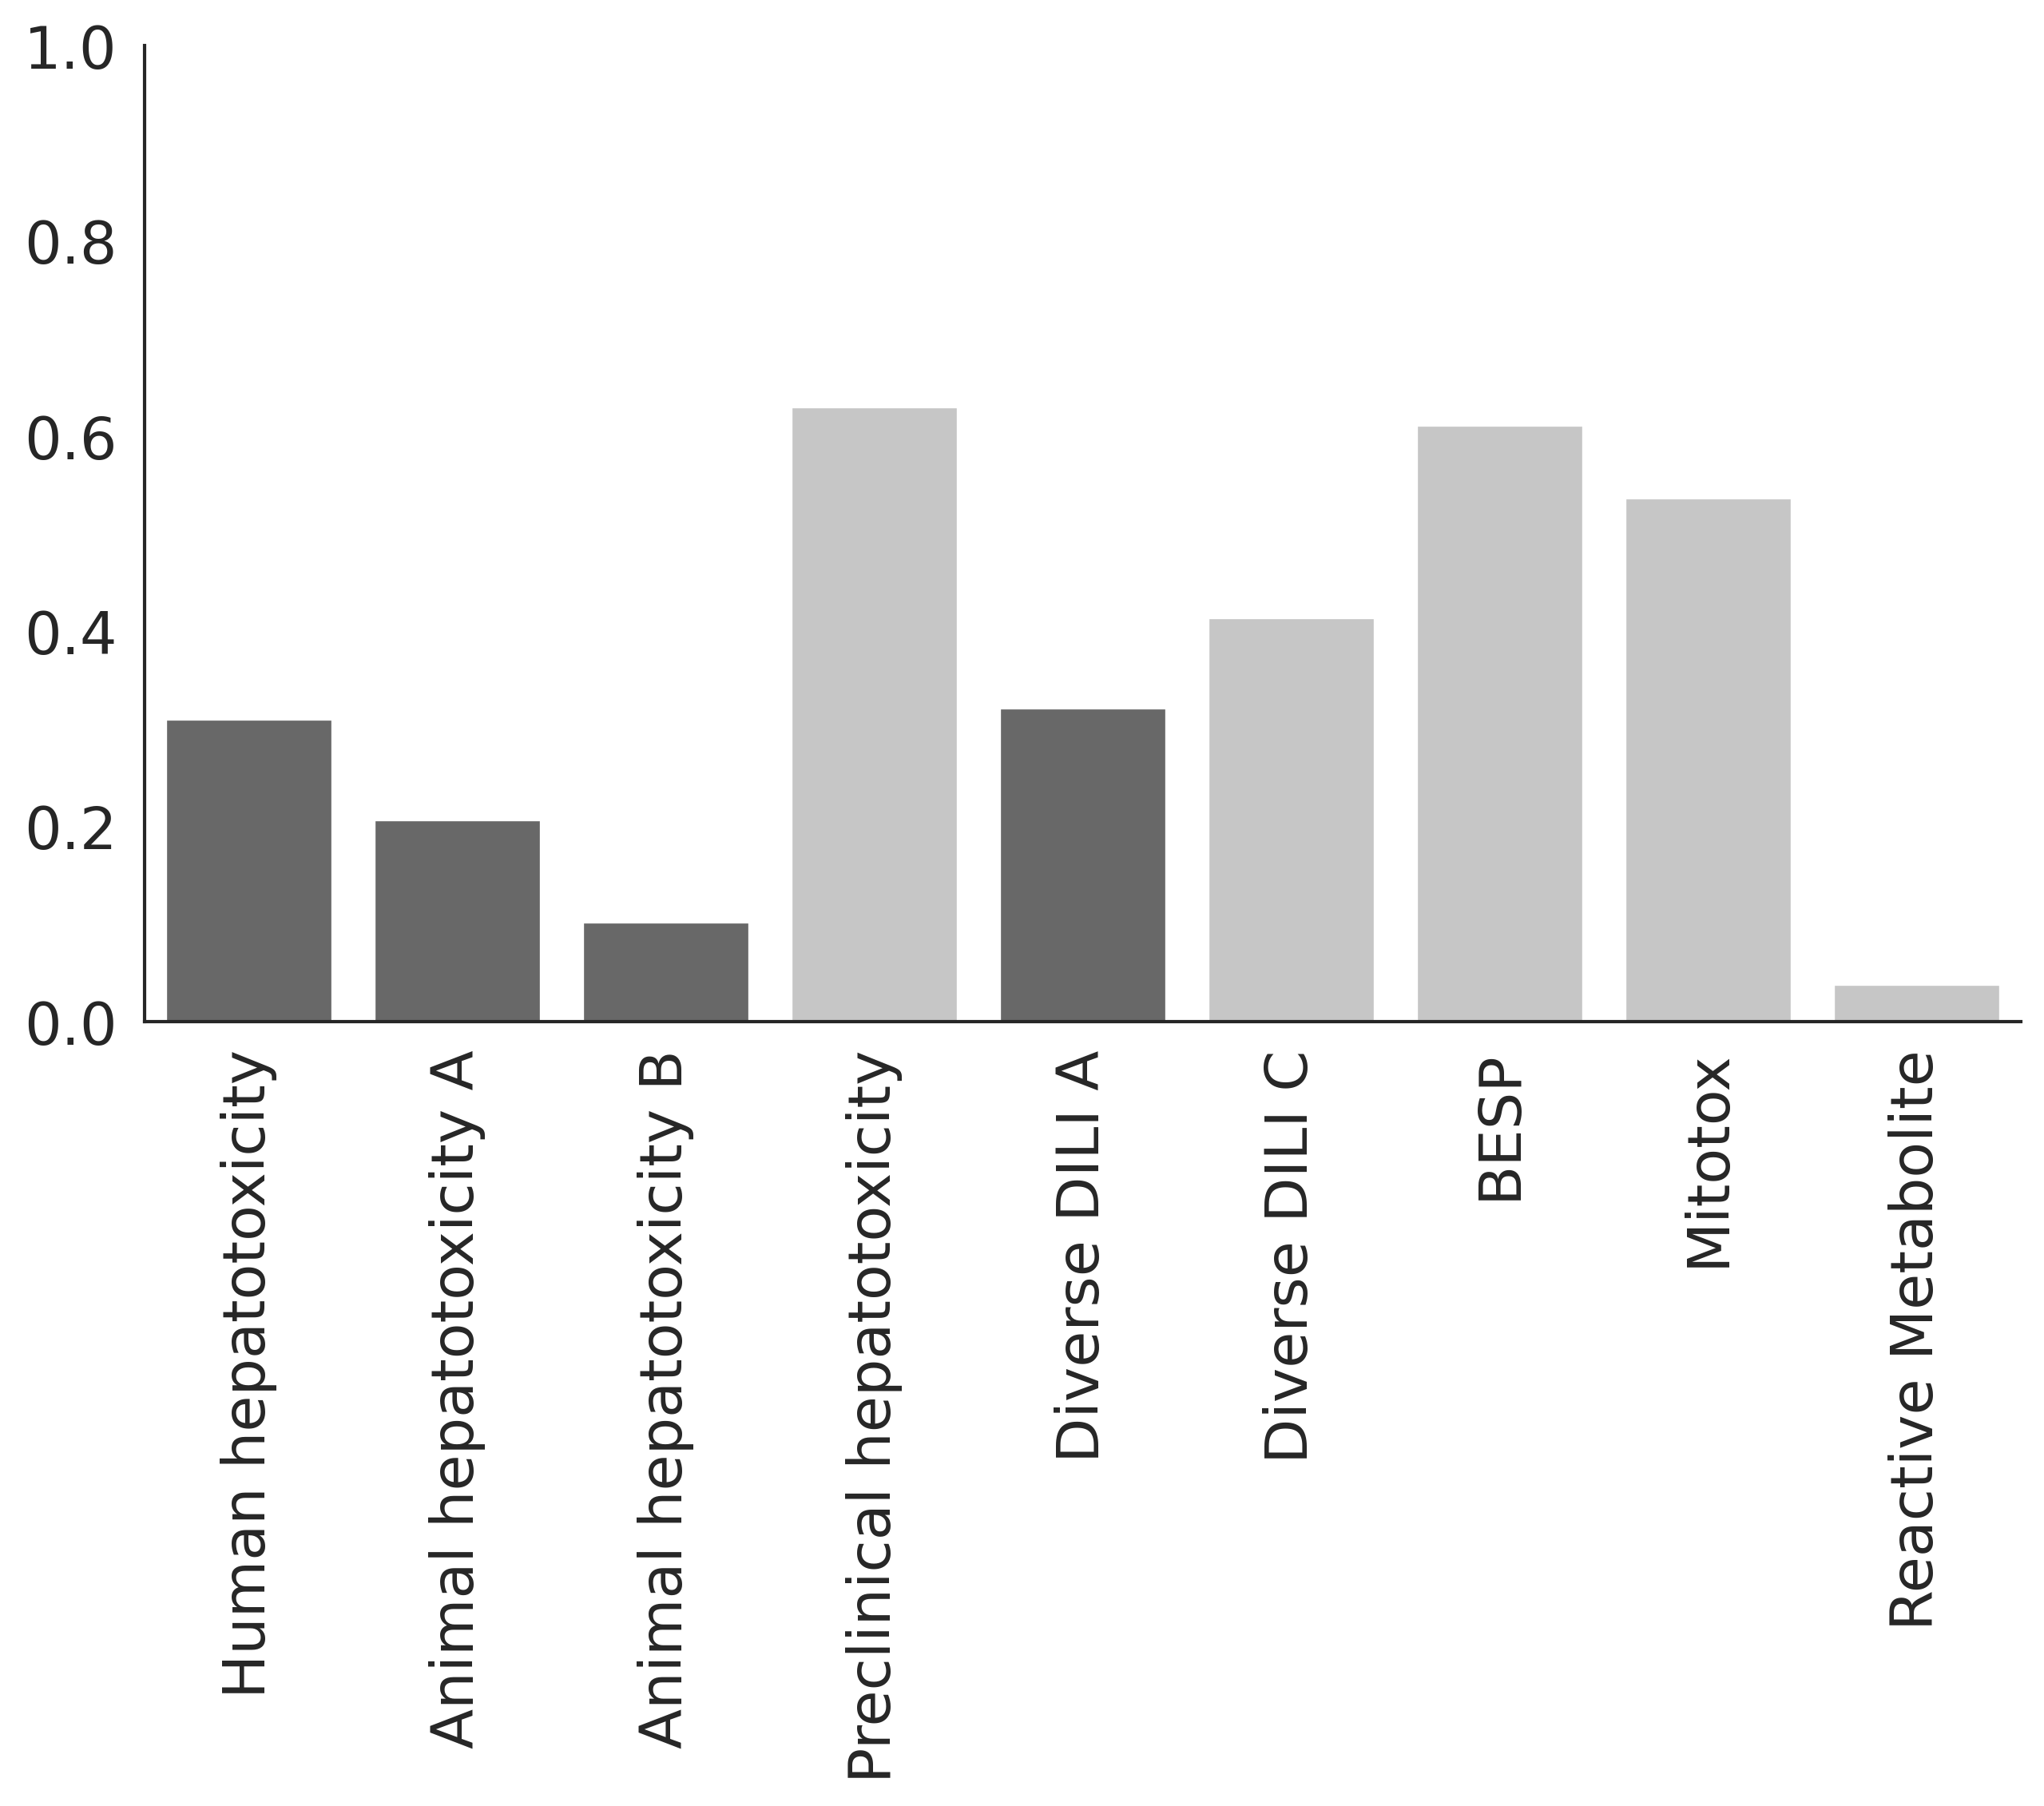

Clopidogrel
9


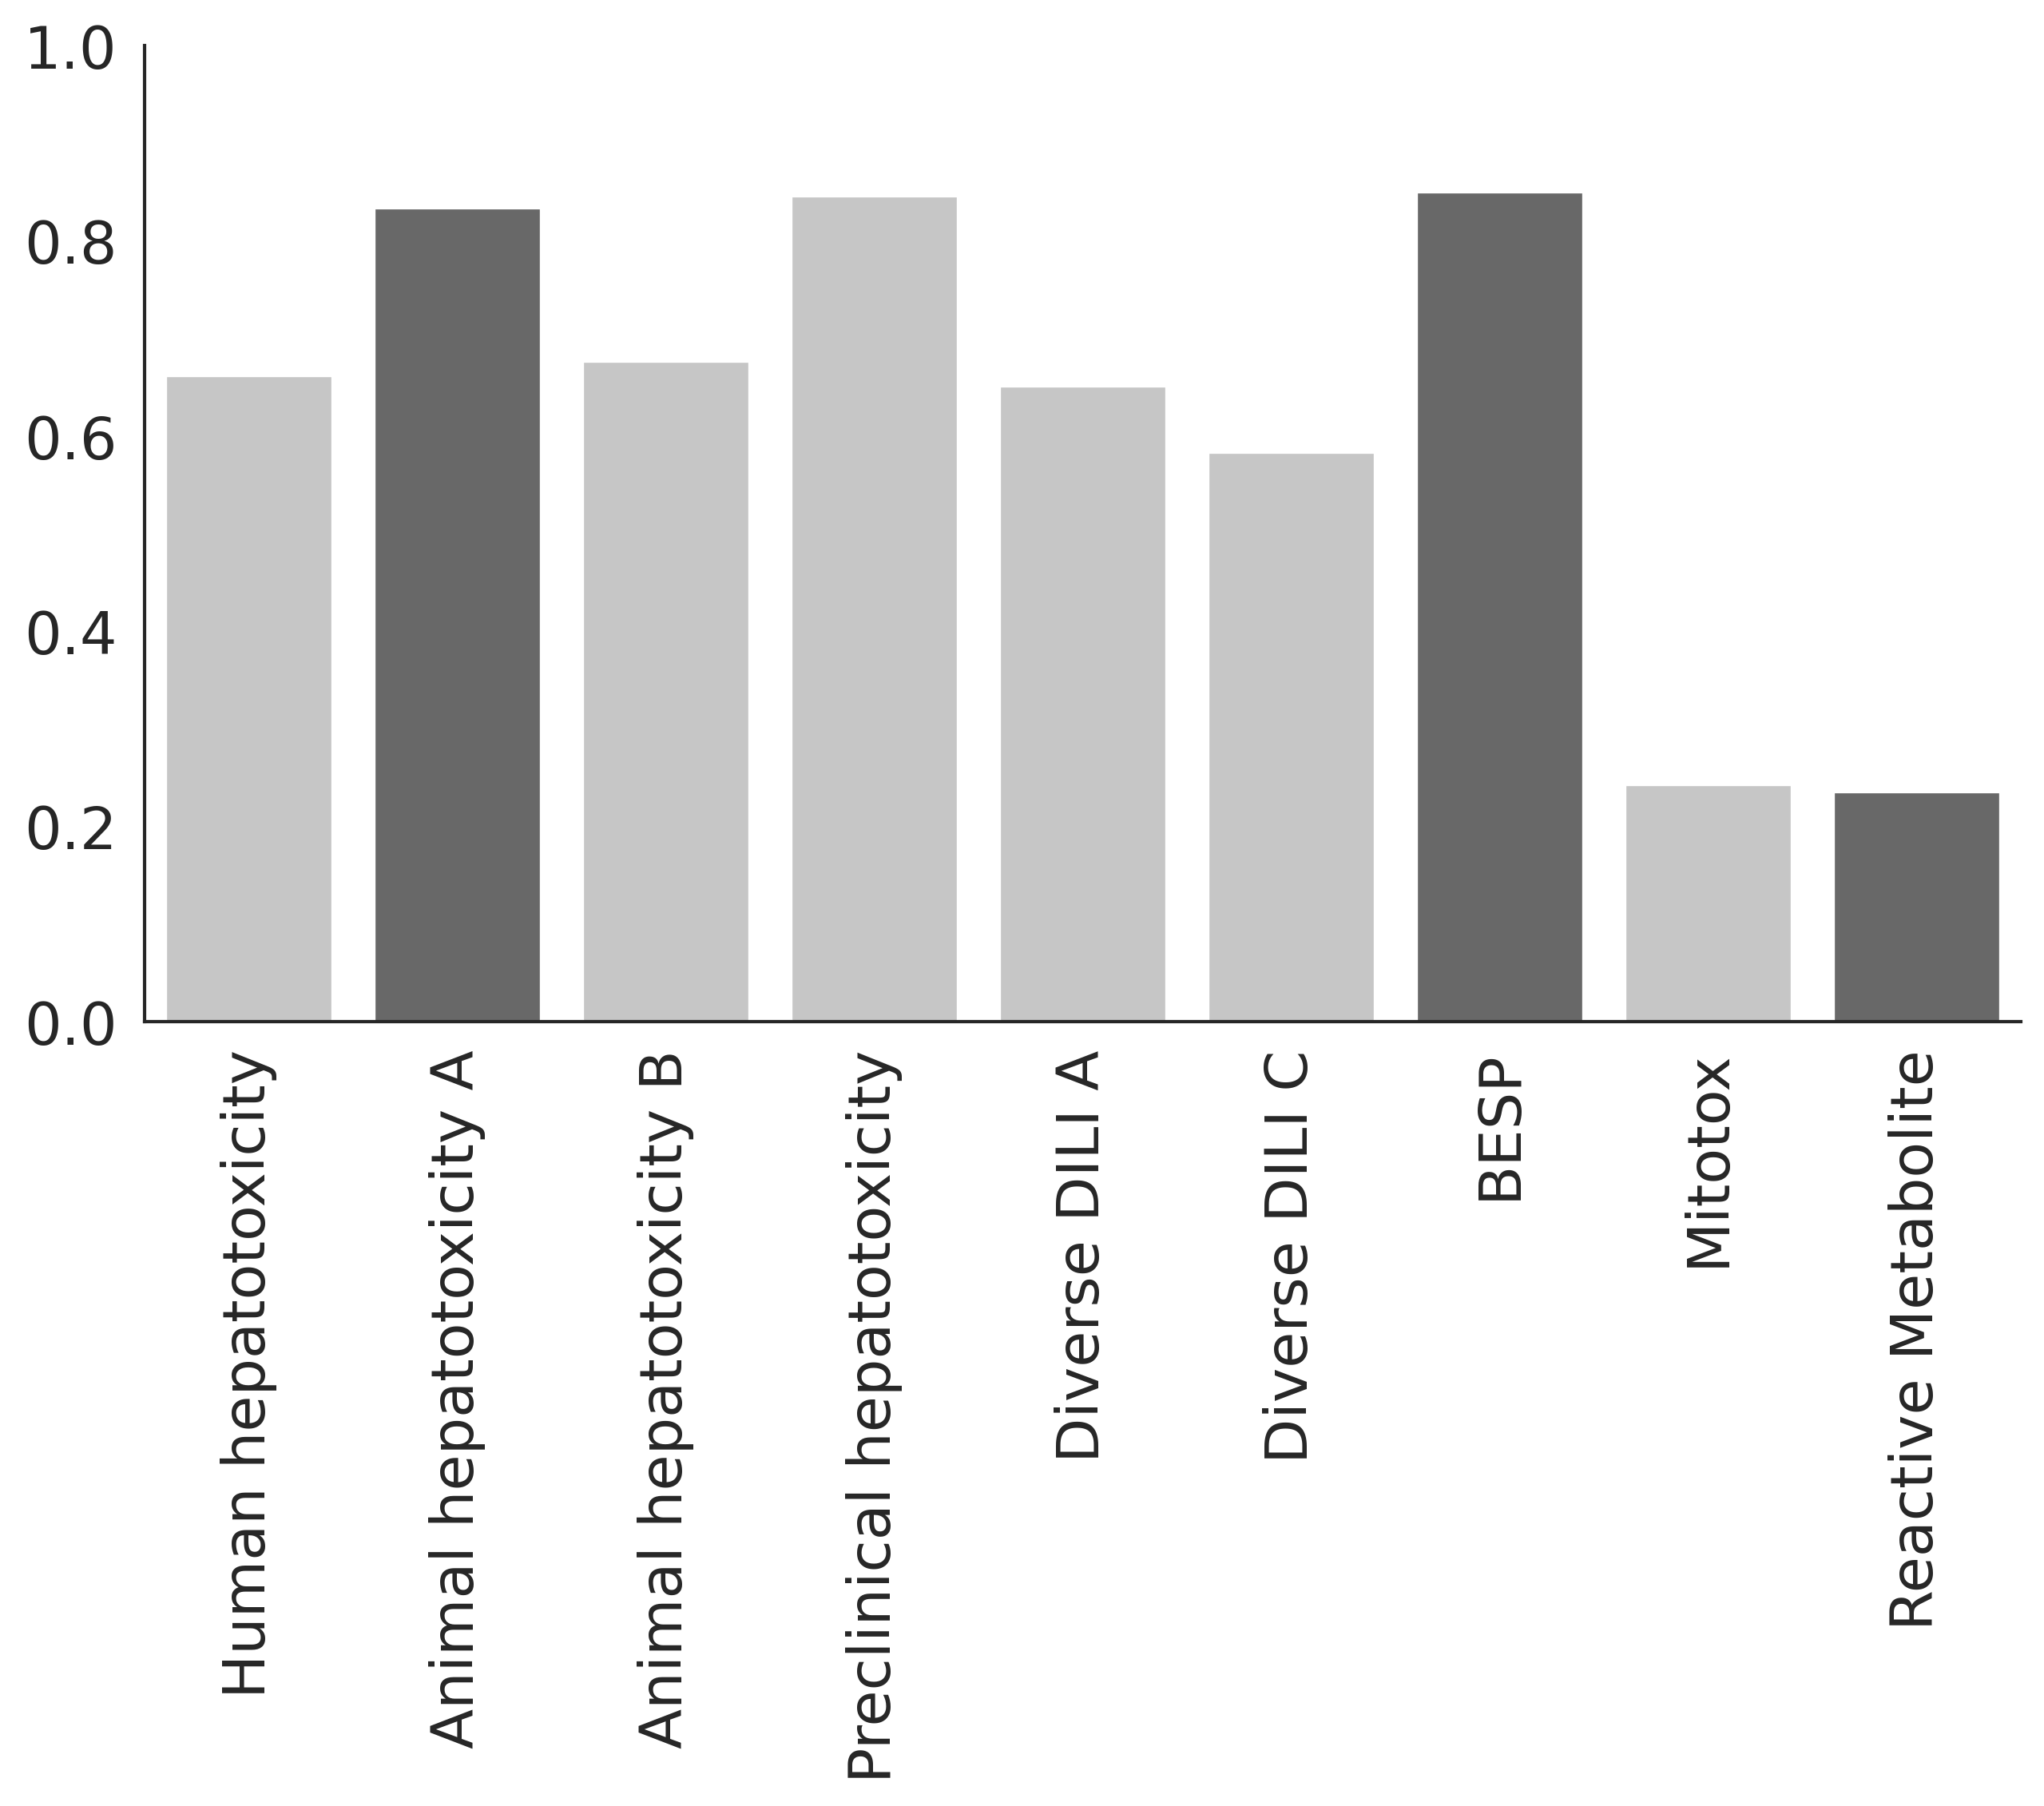

Docetaxel
9


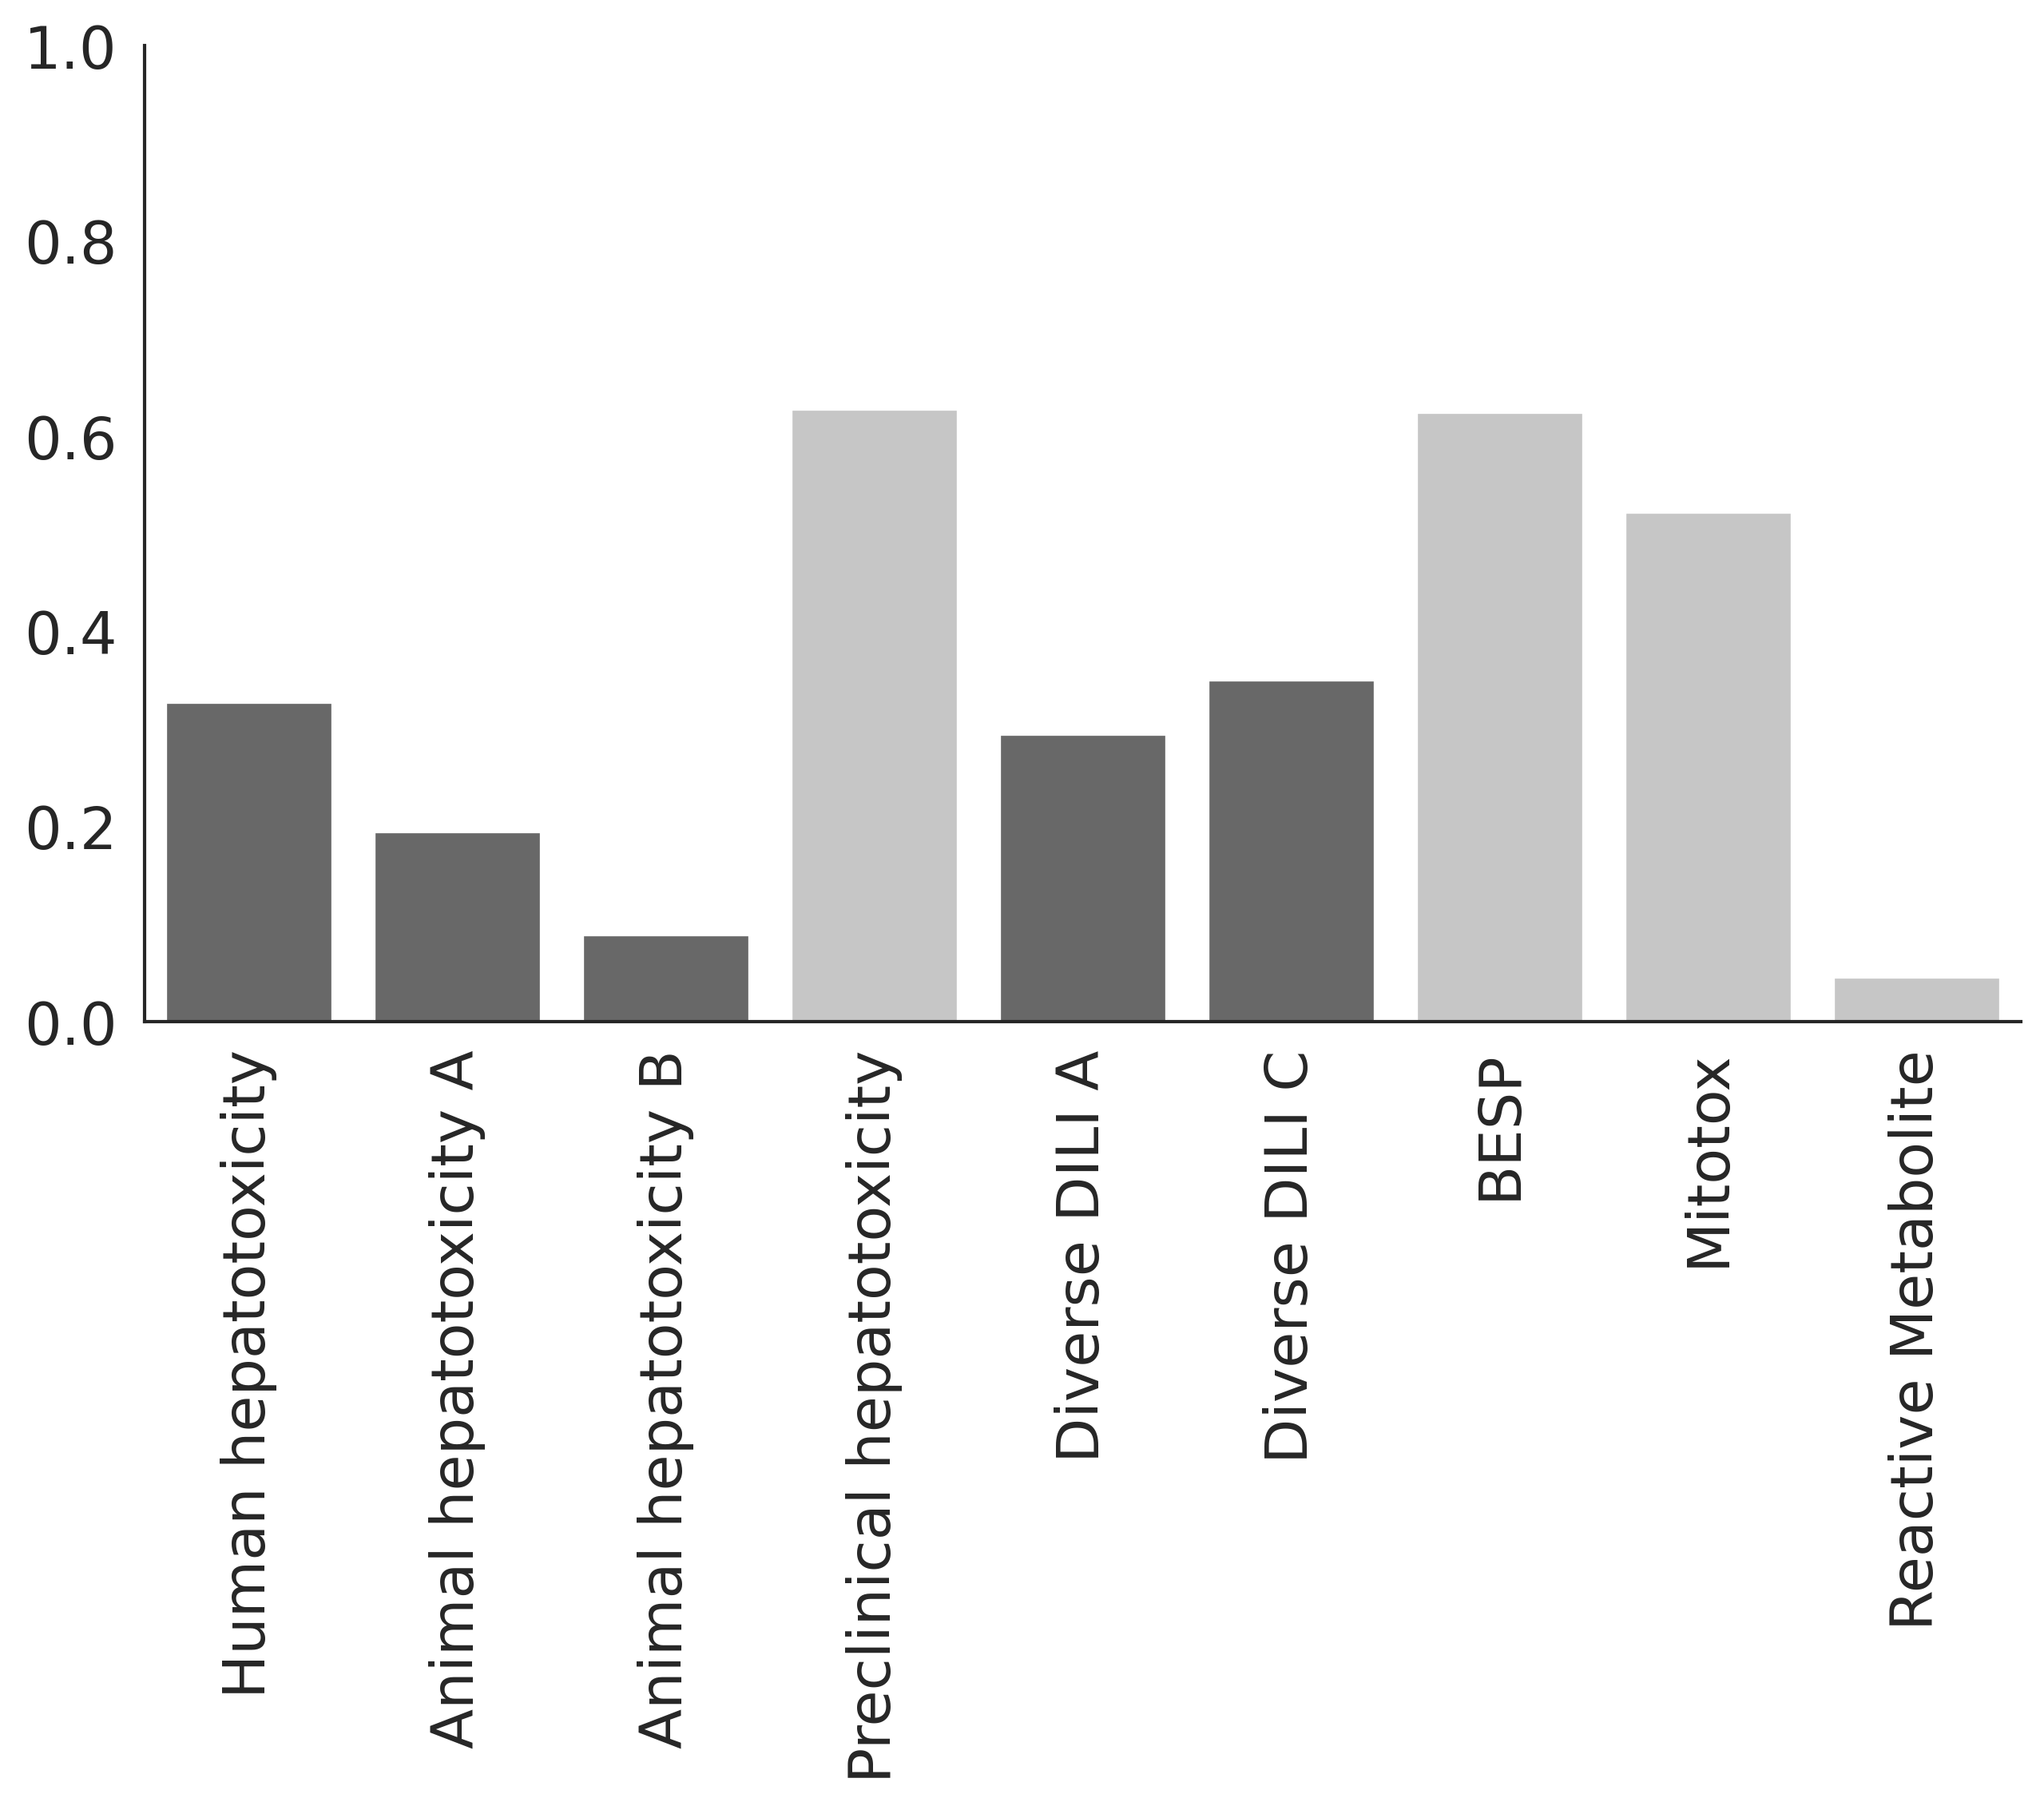

Doxycycline
9


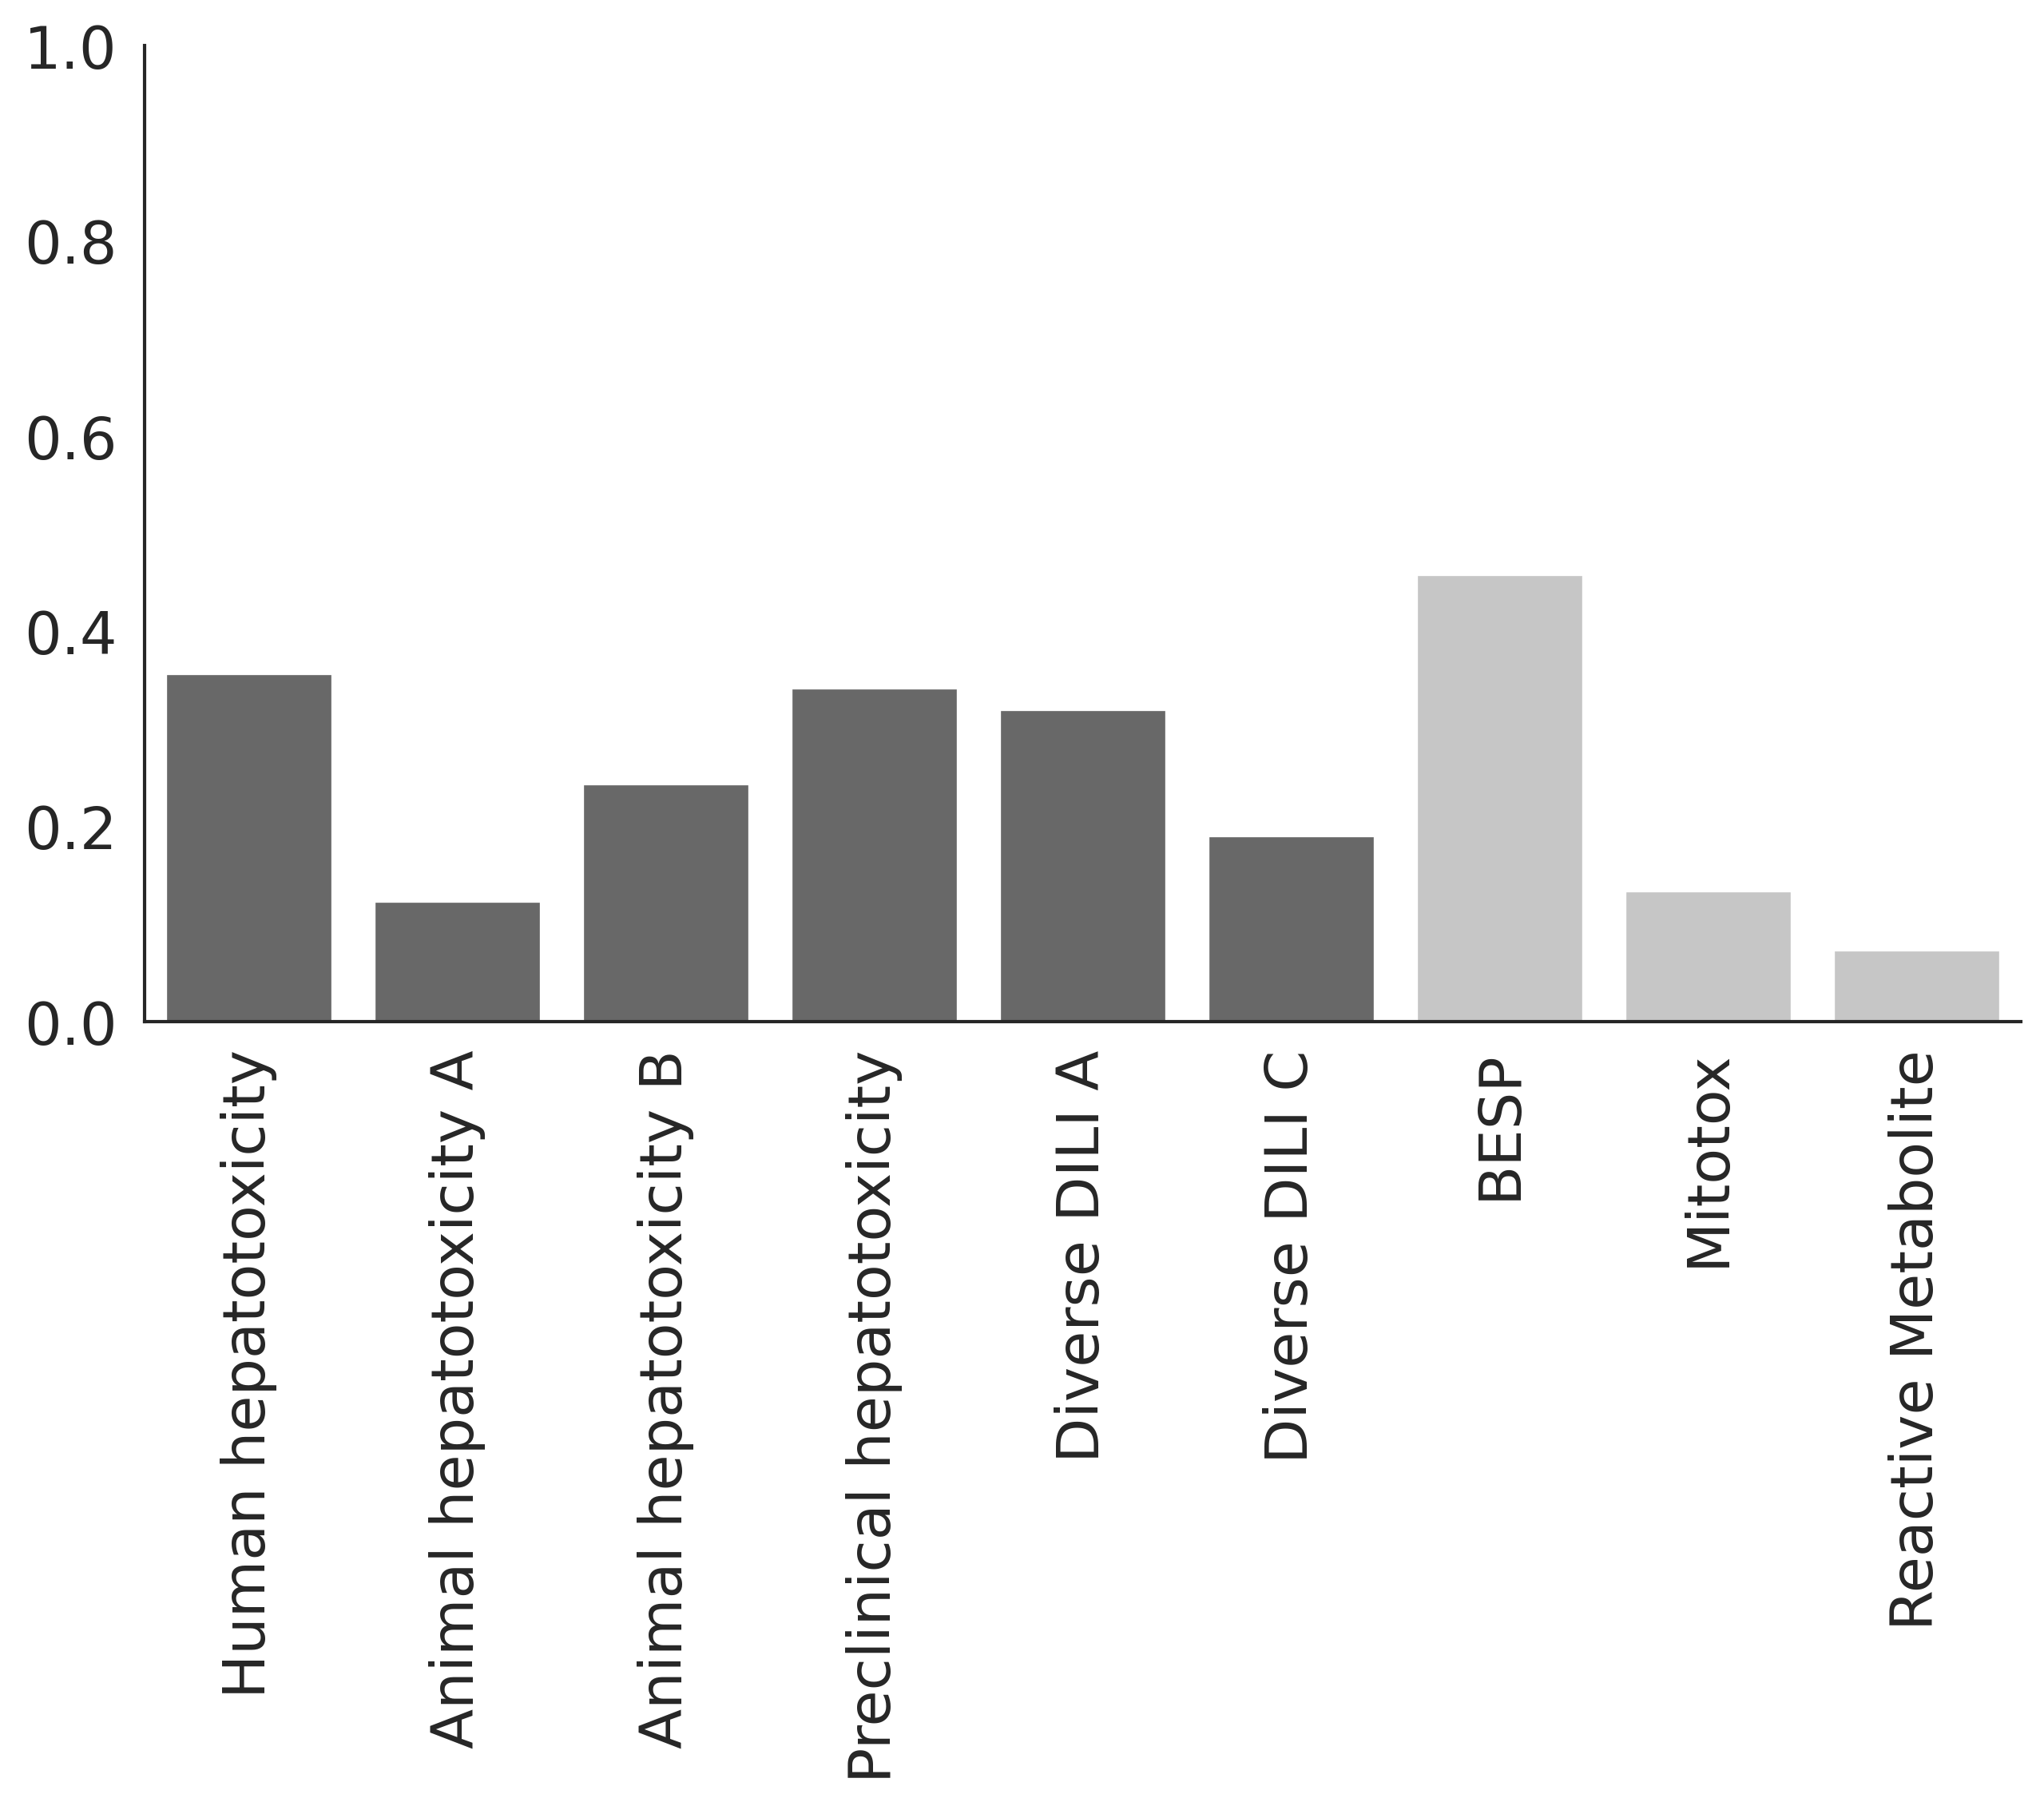

Entacapone
9


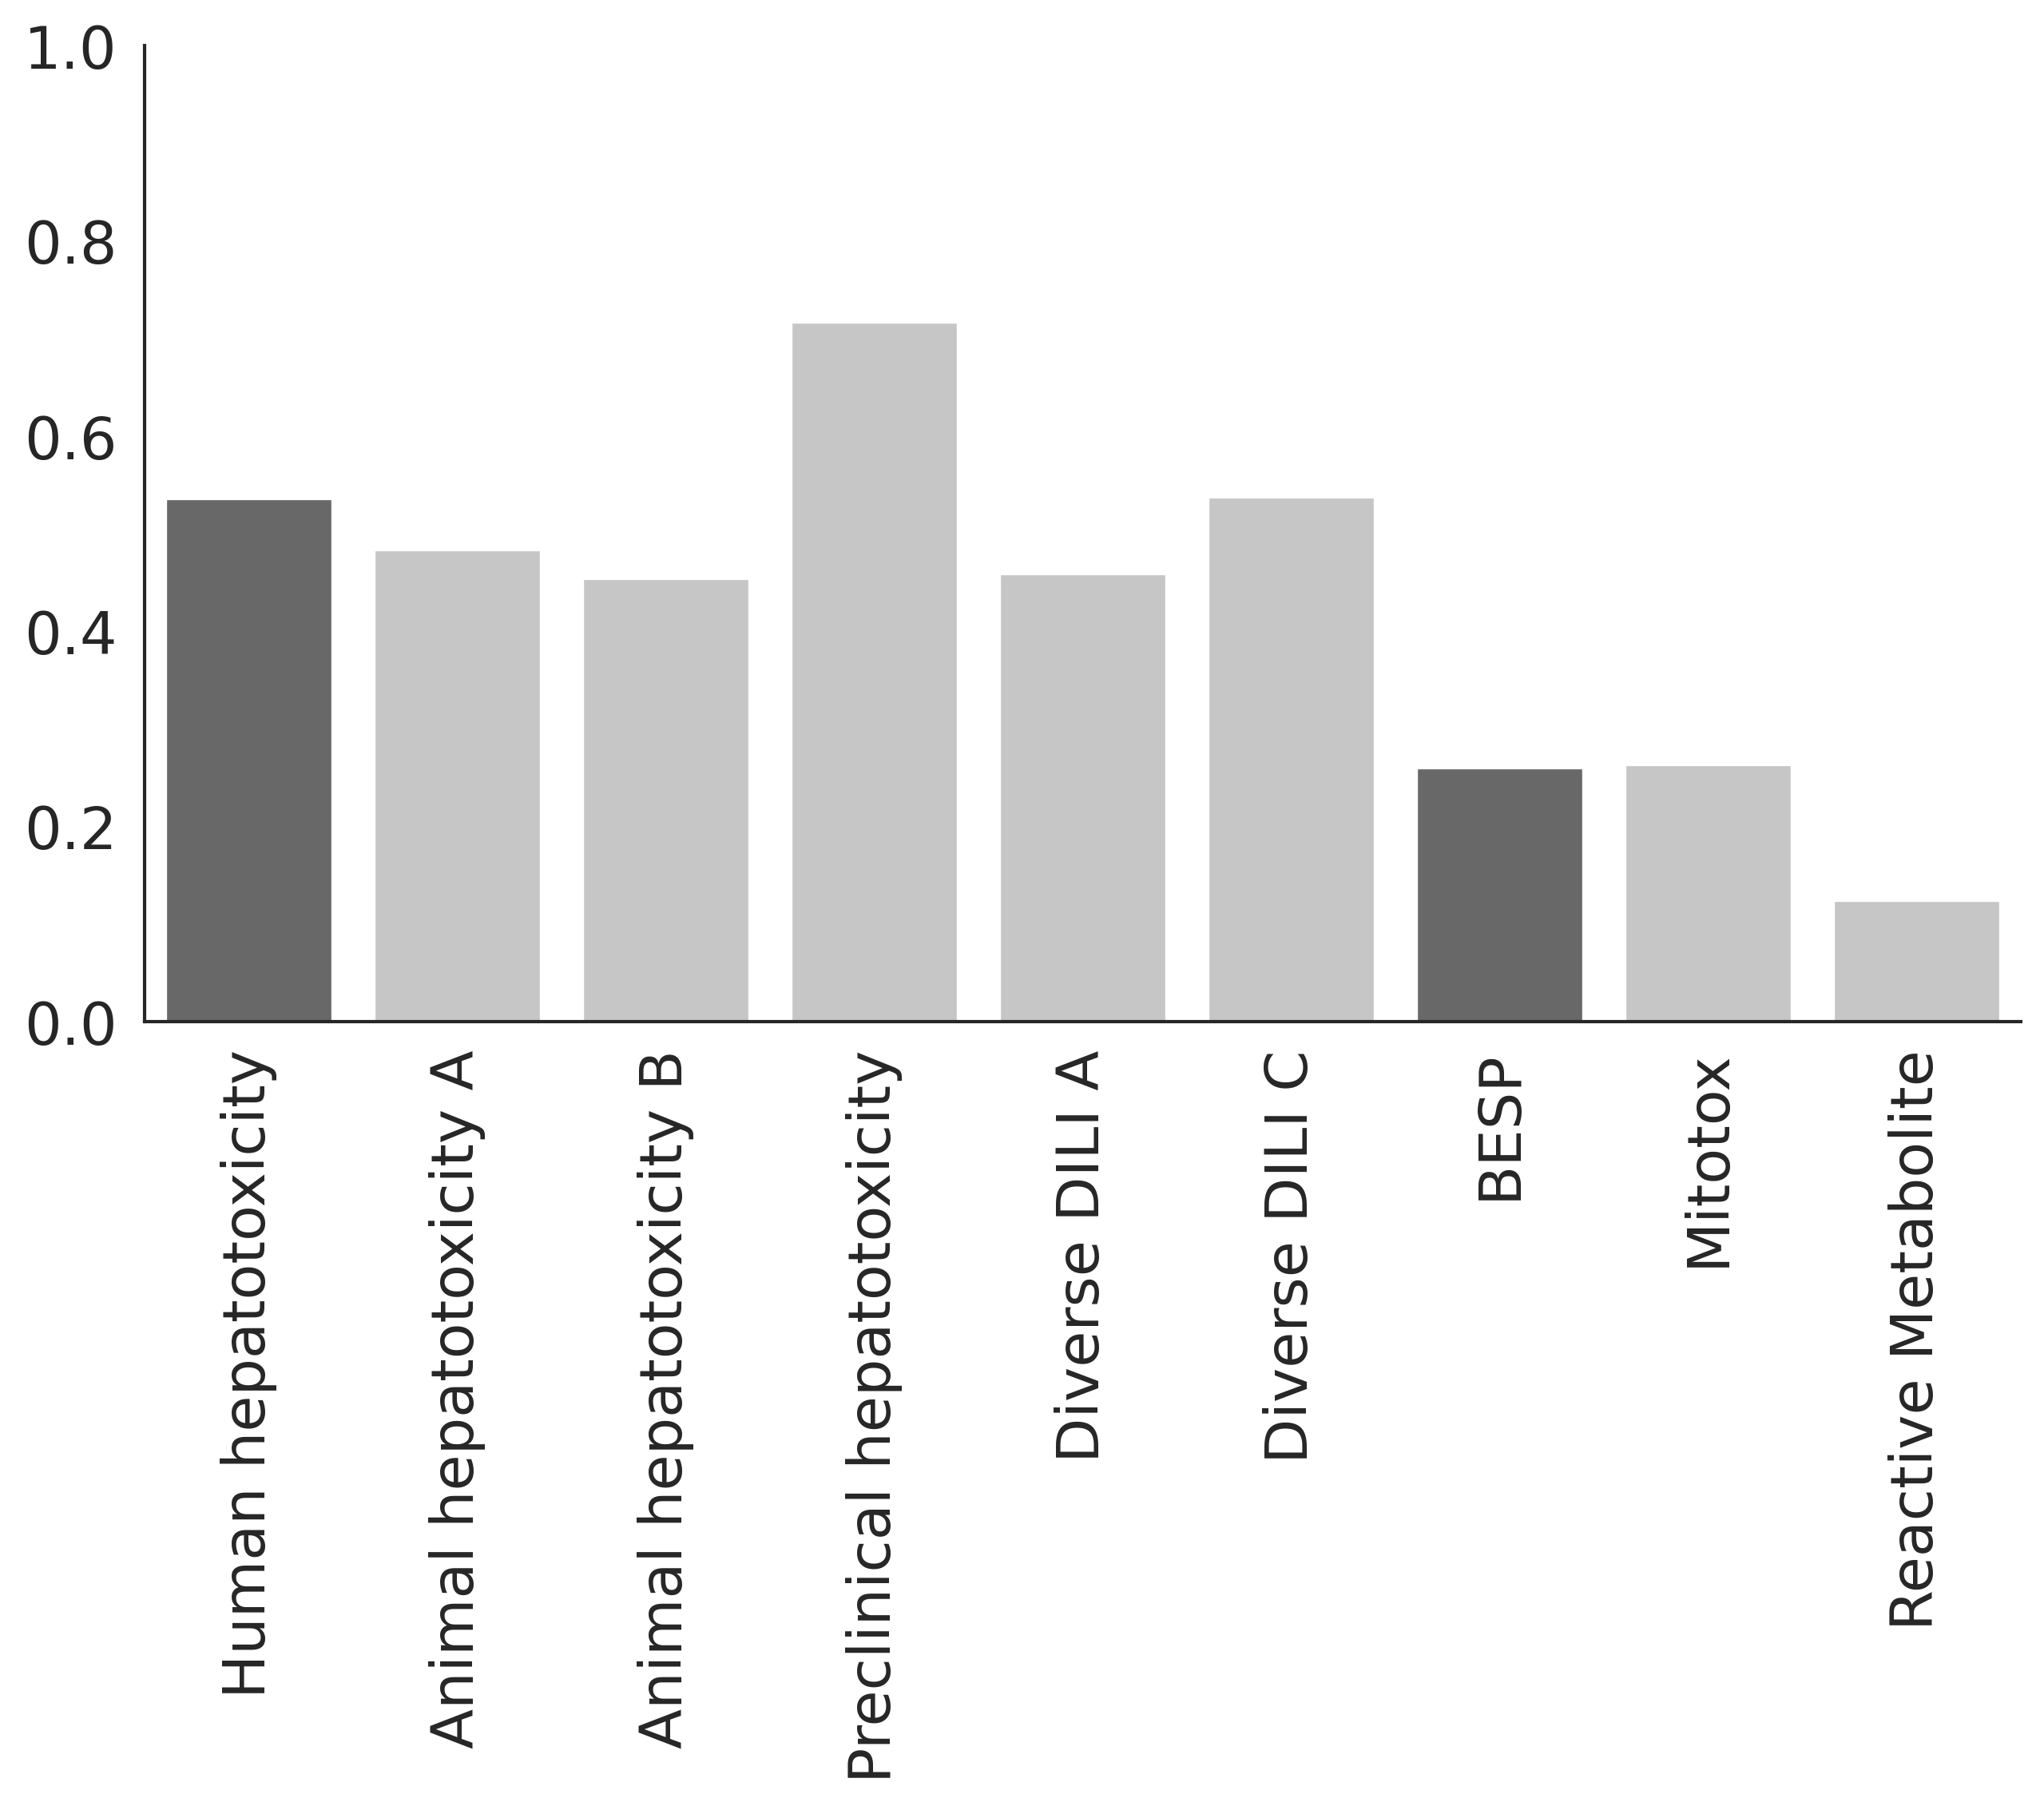

Gemcitabine
9


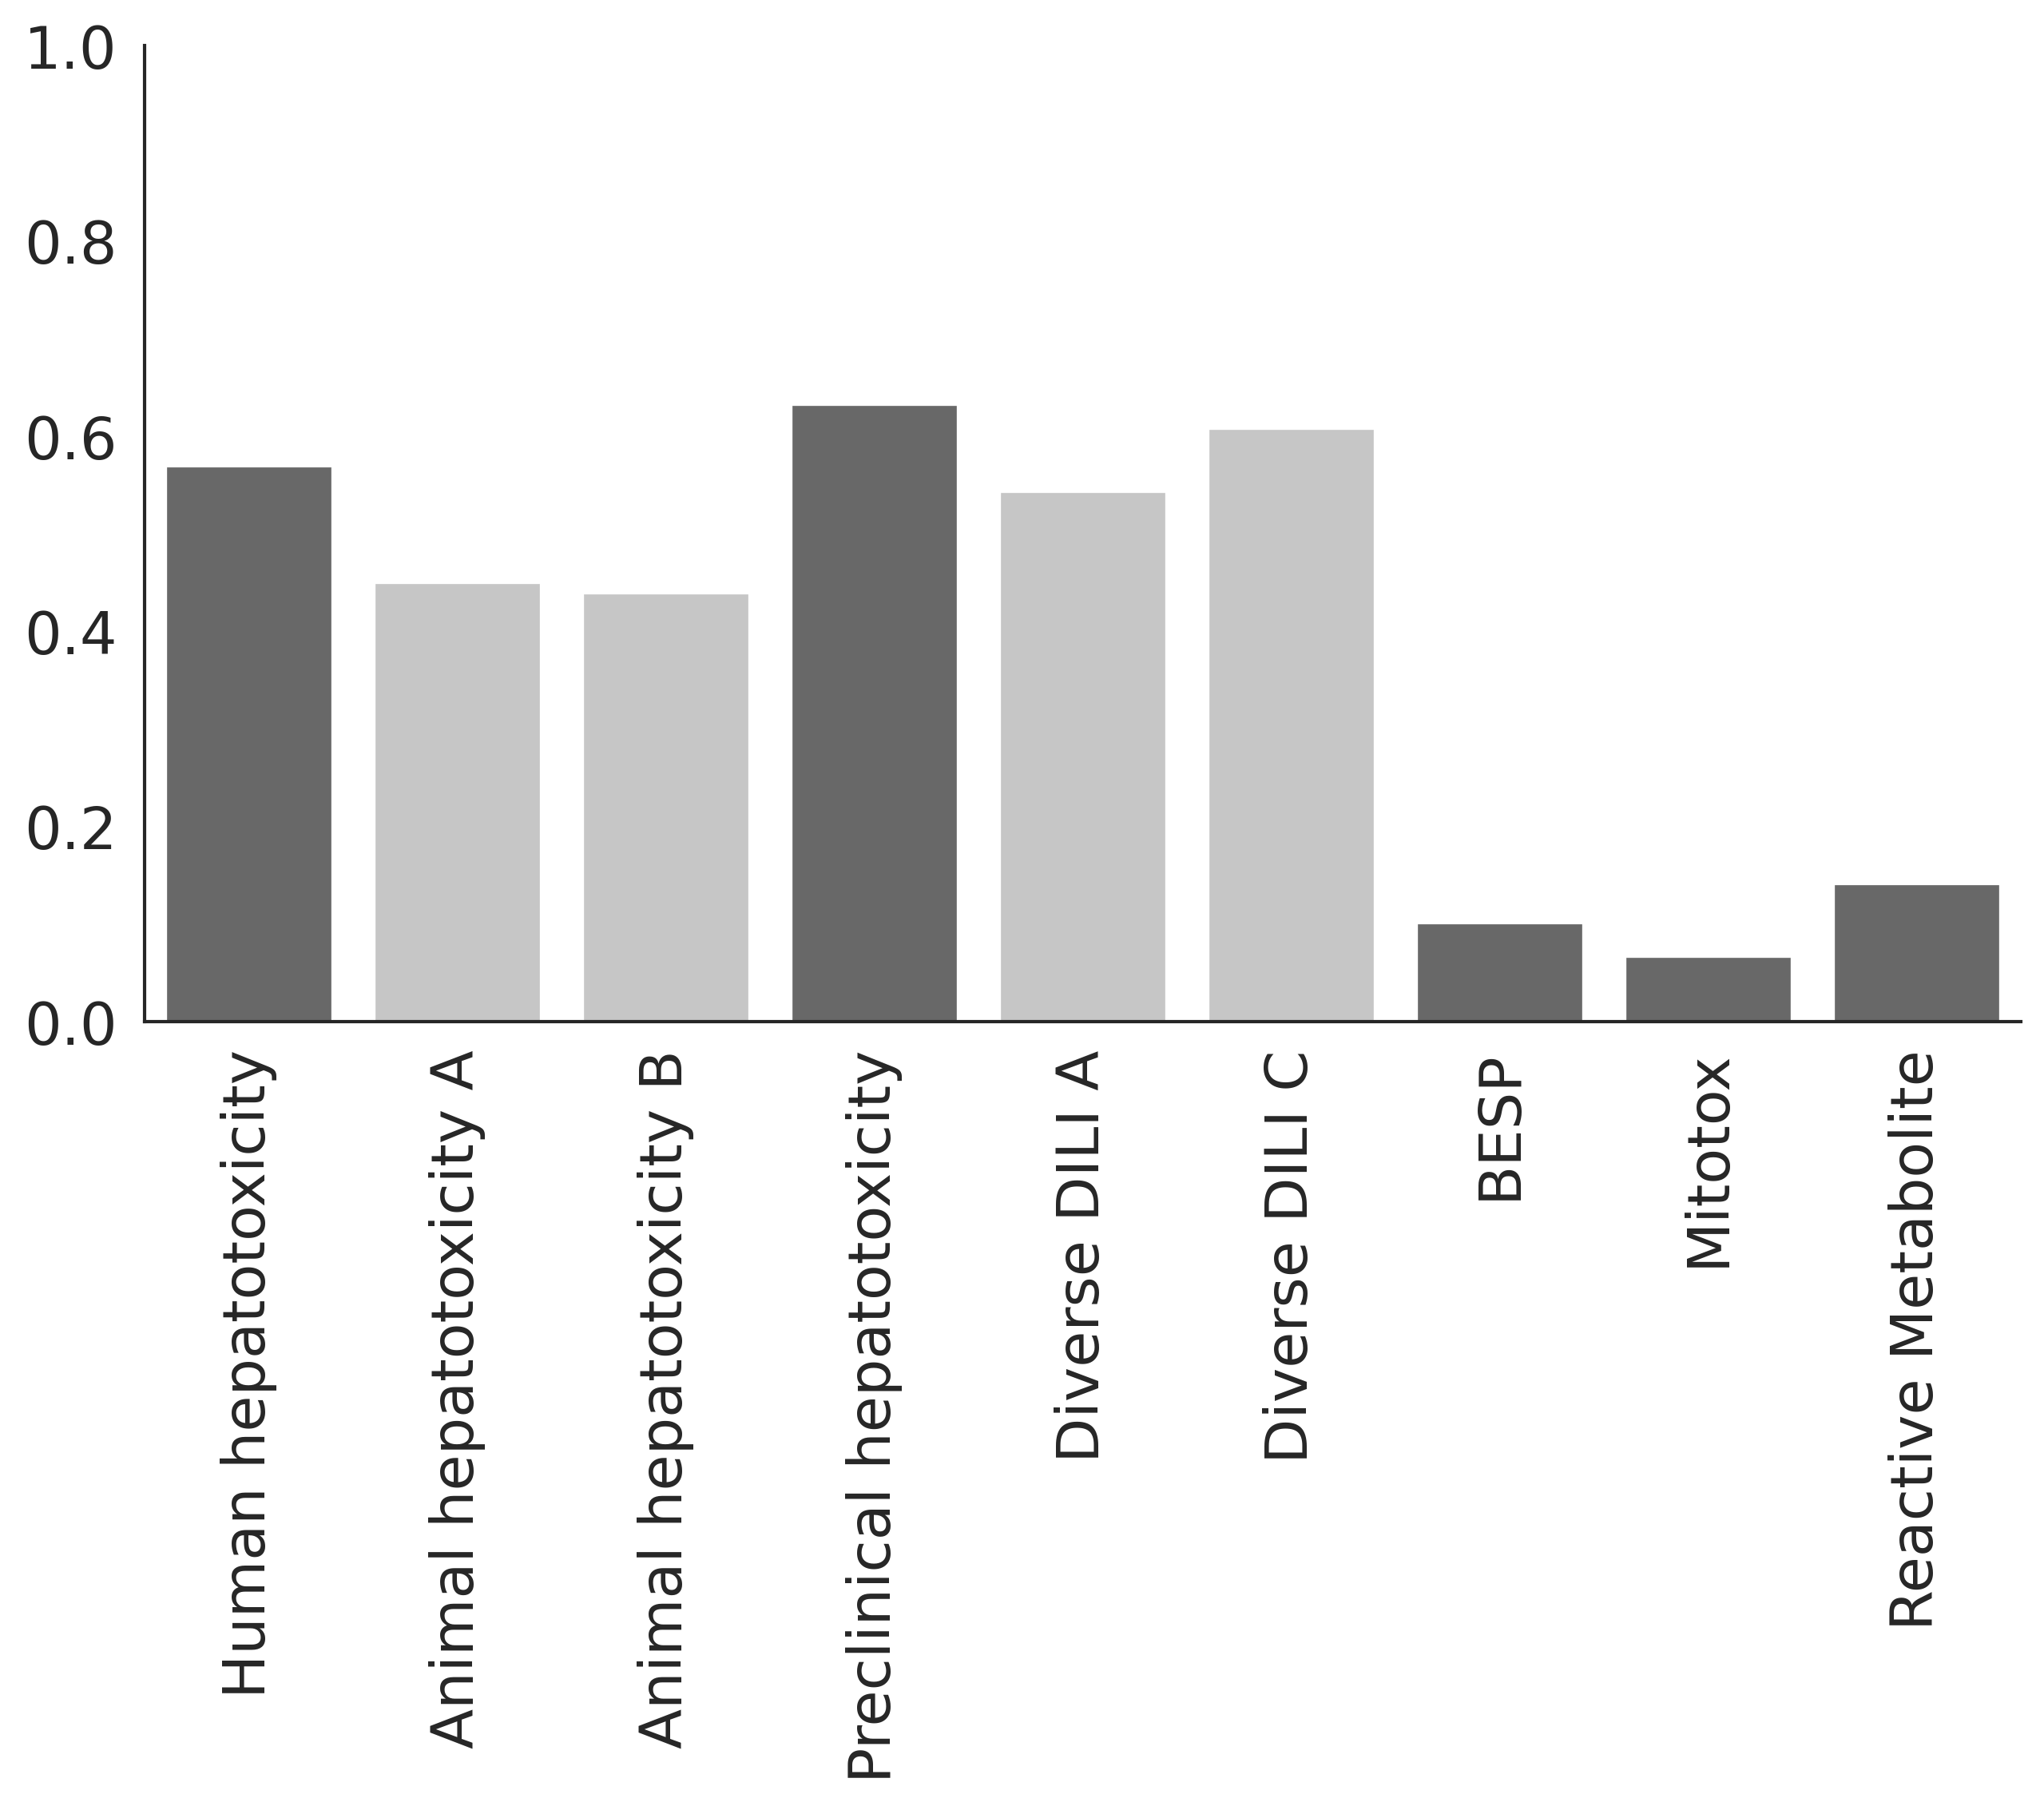

Minocycline
9


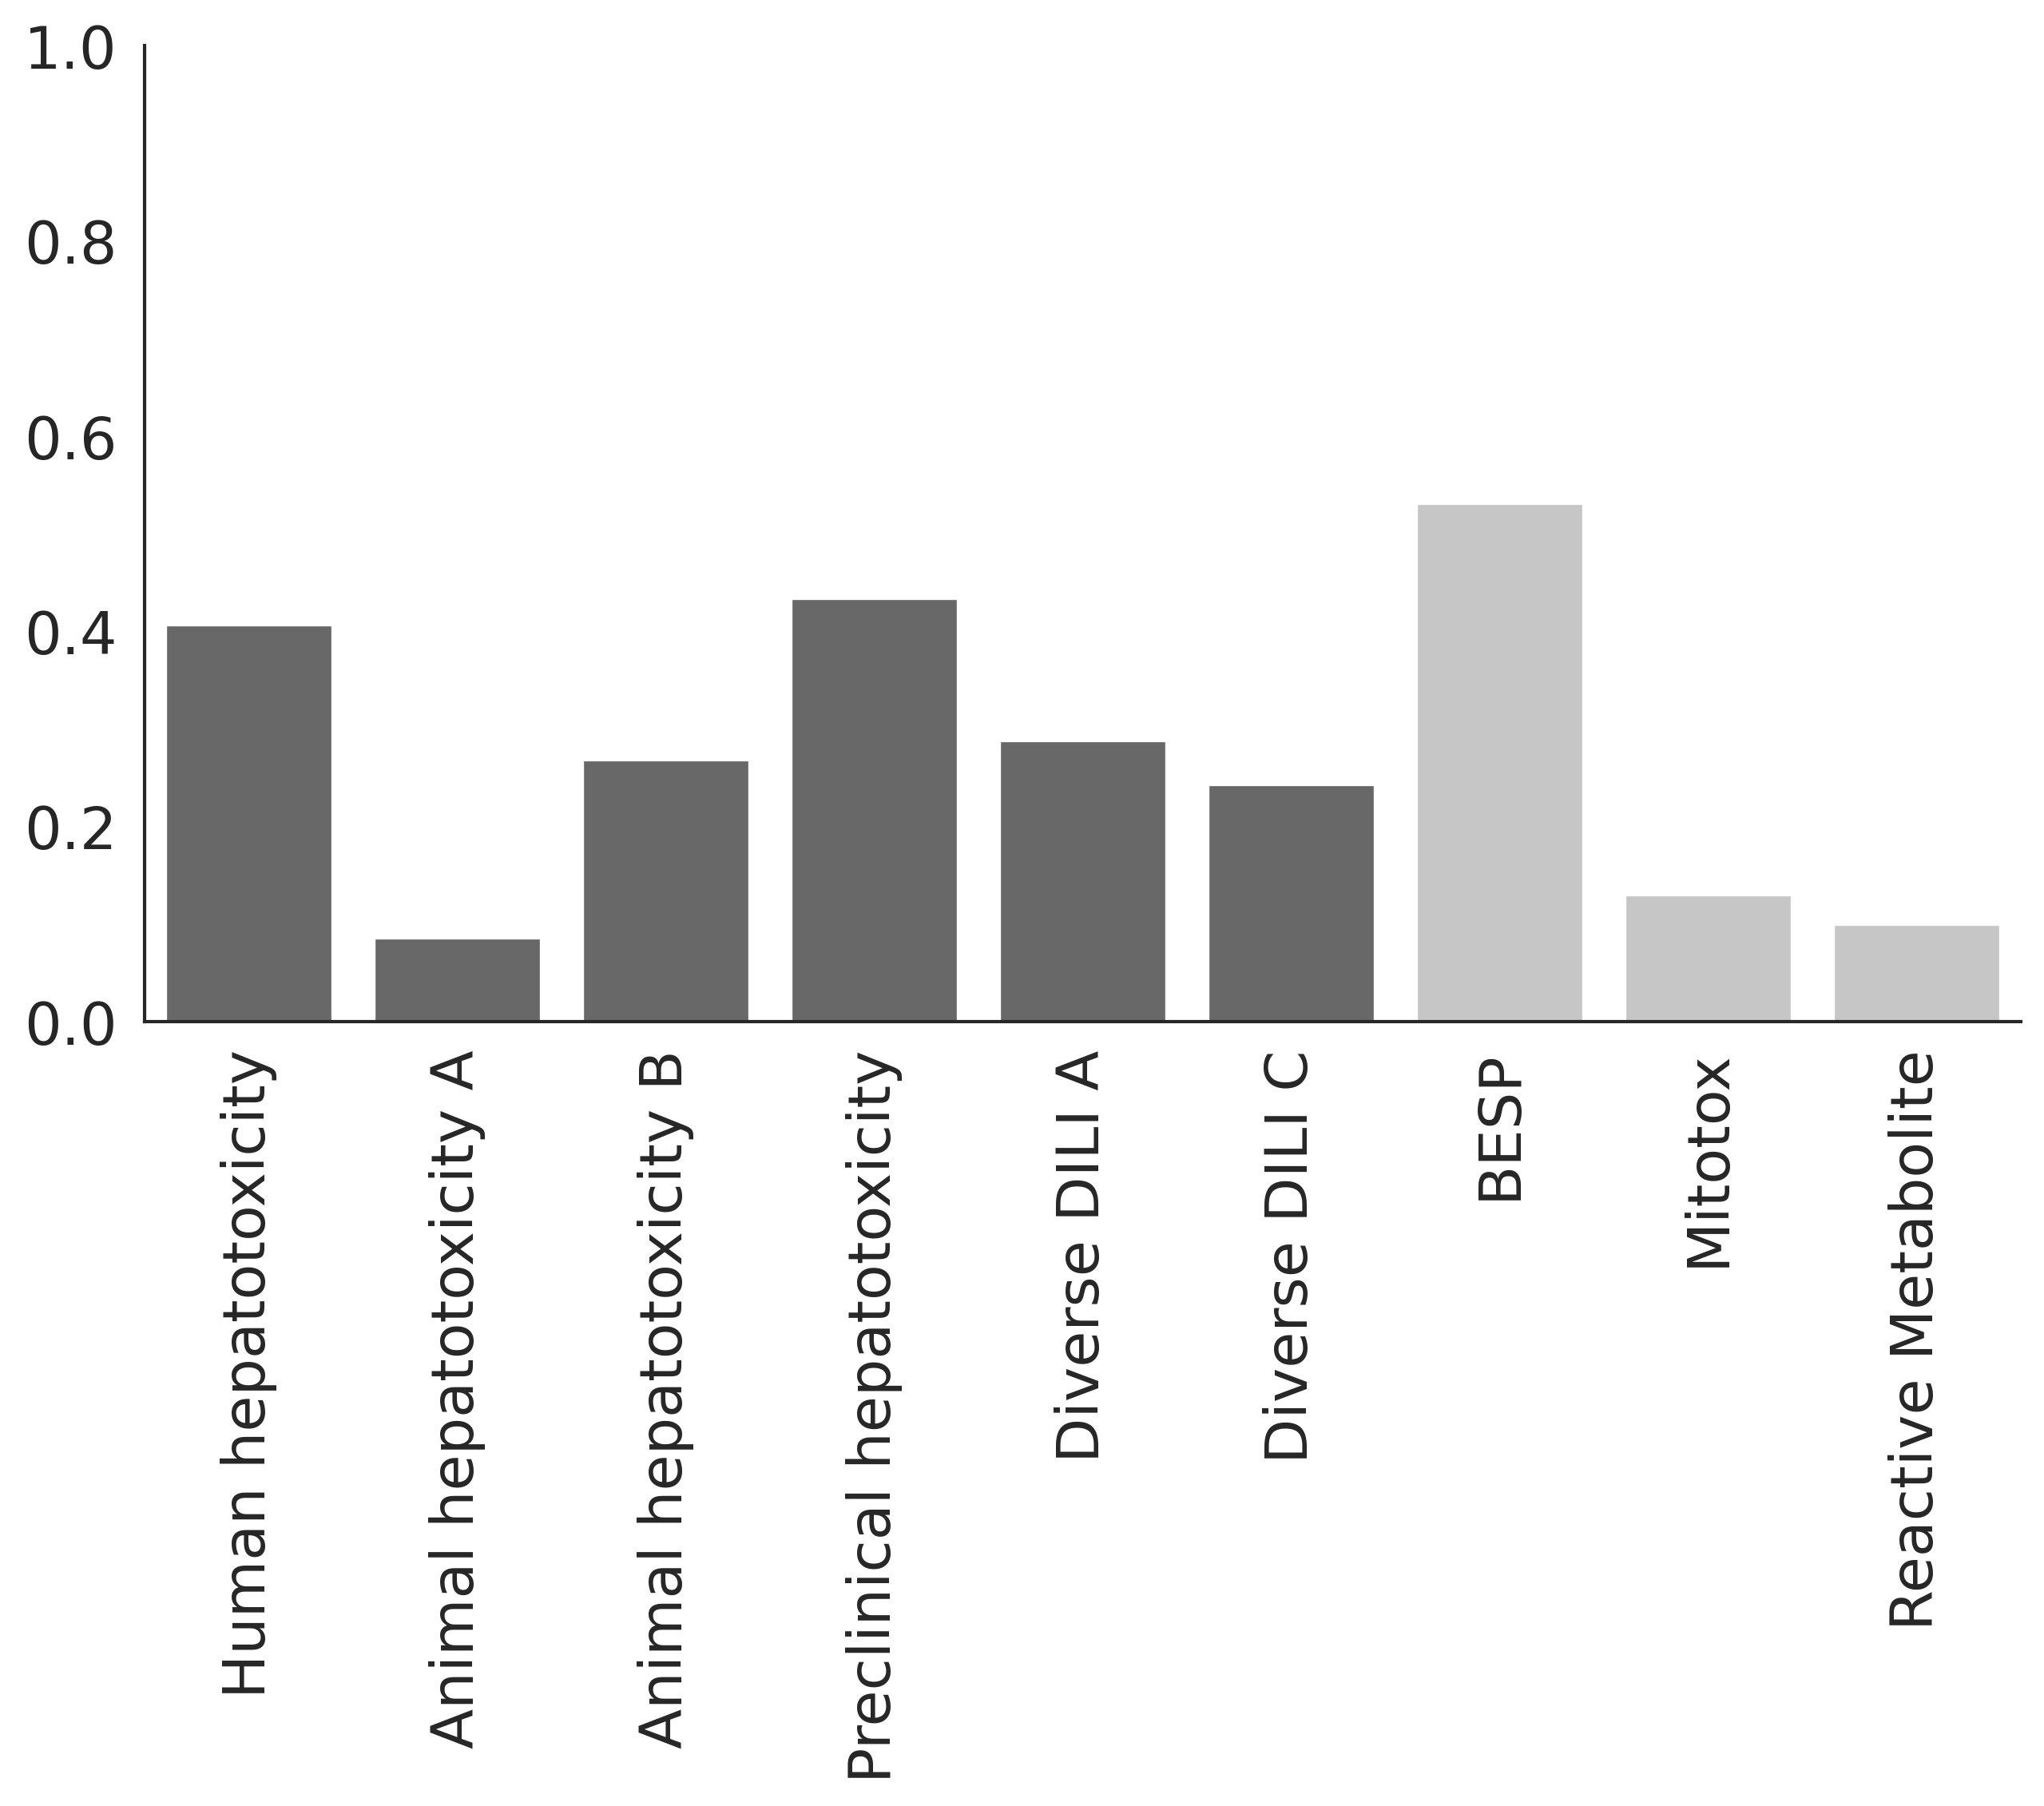

Moxifloxacin
9


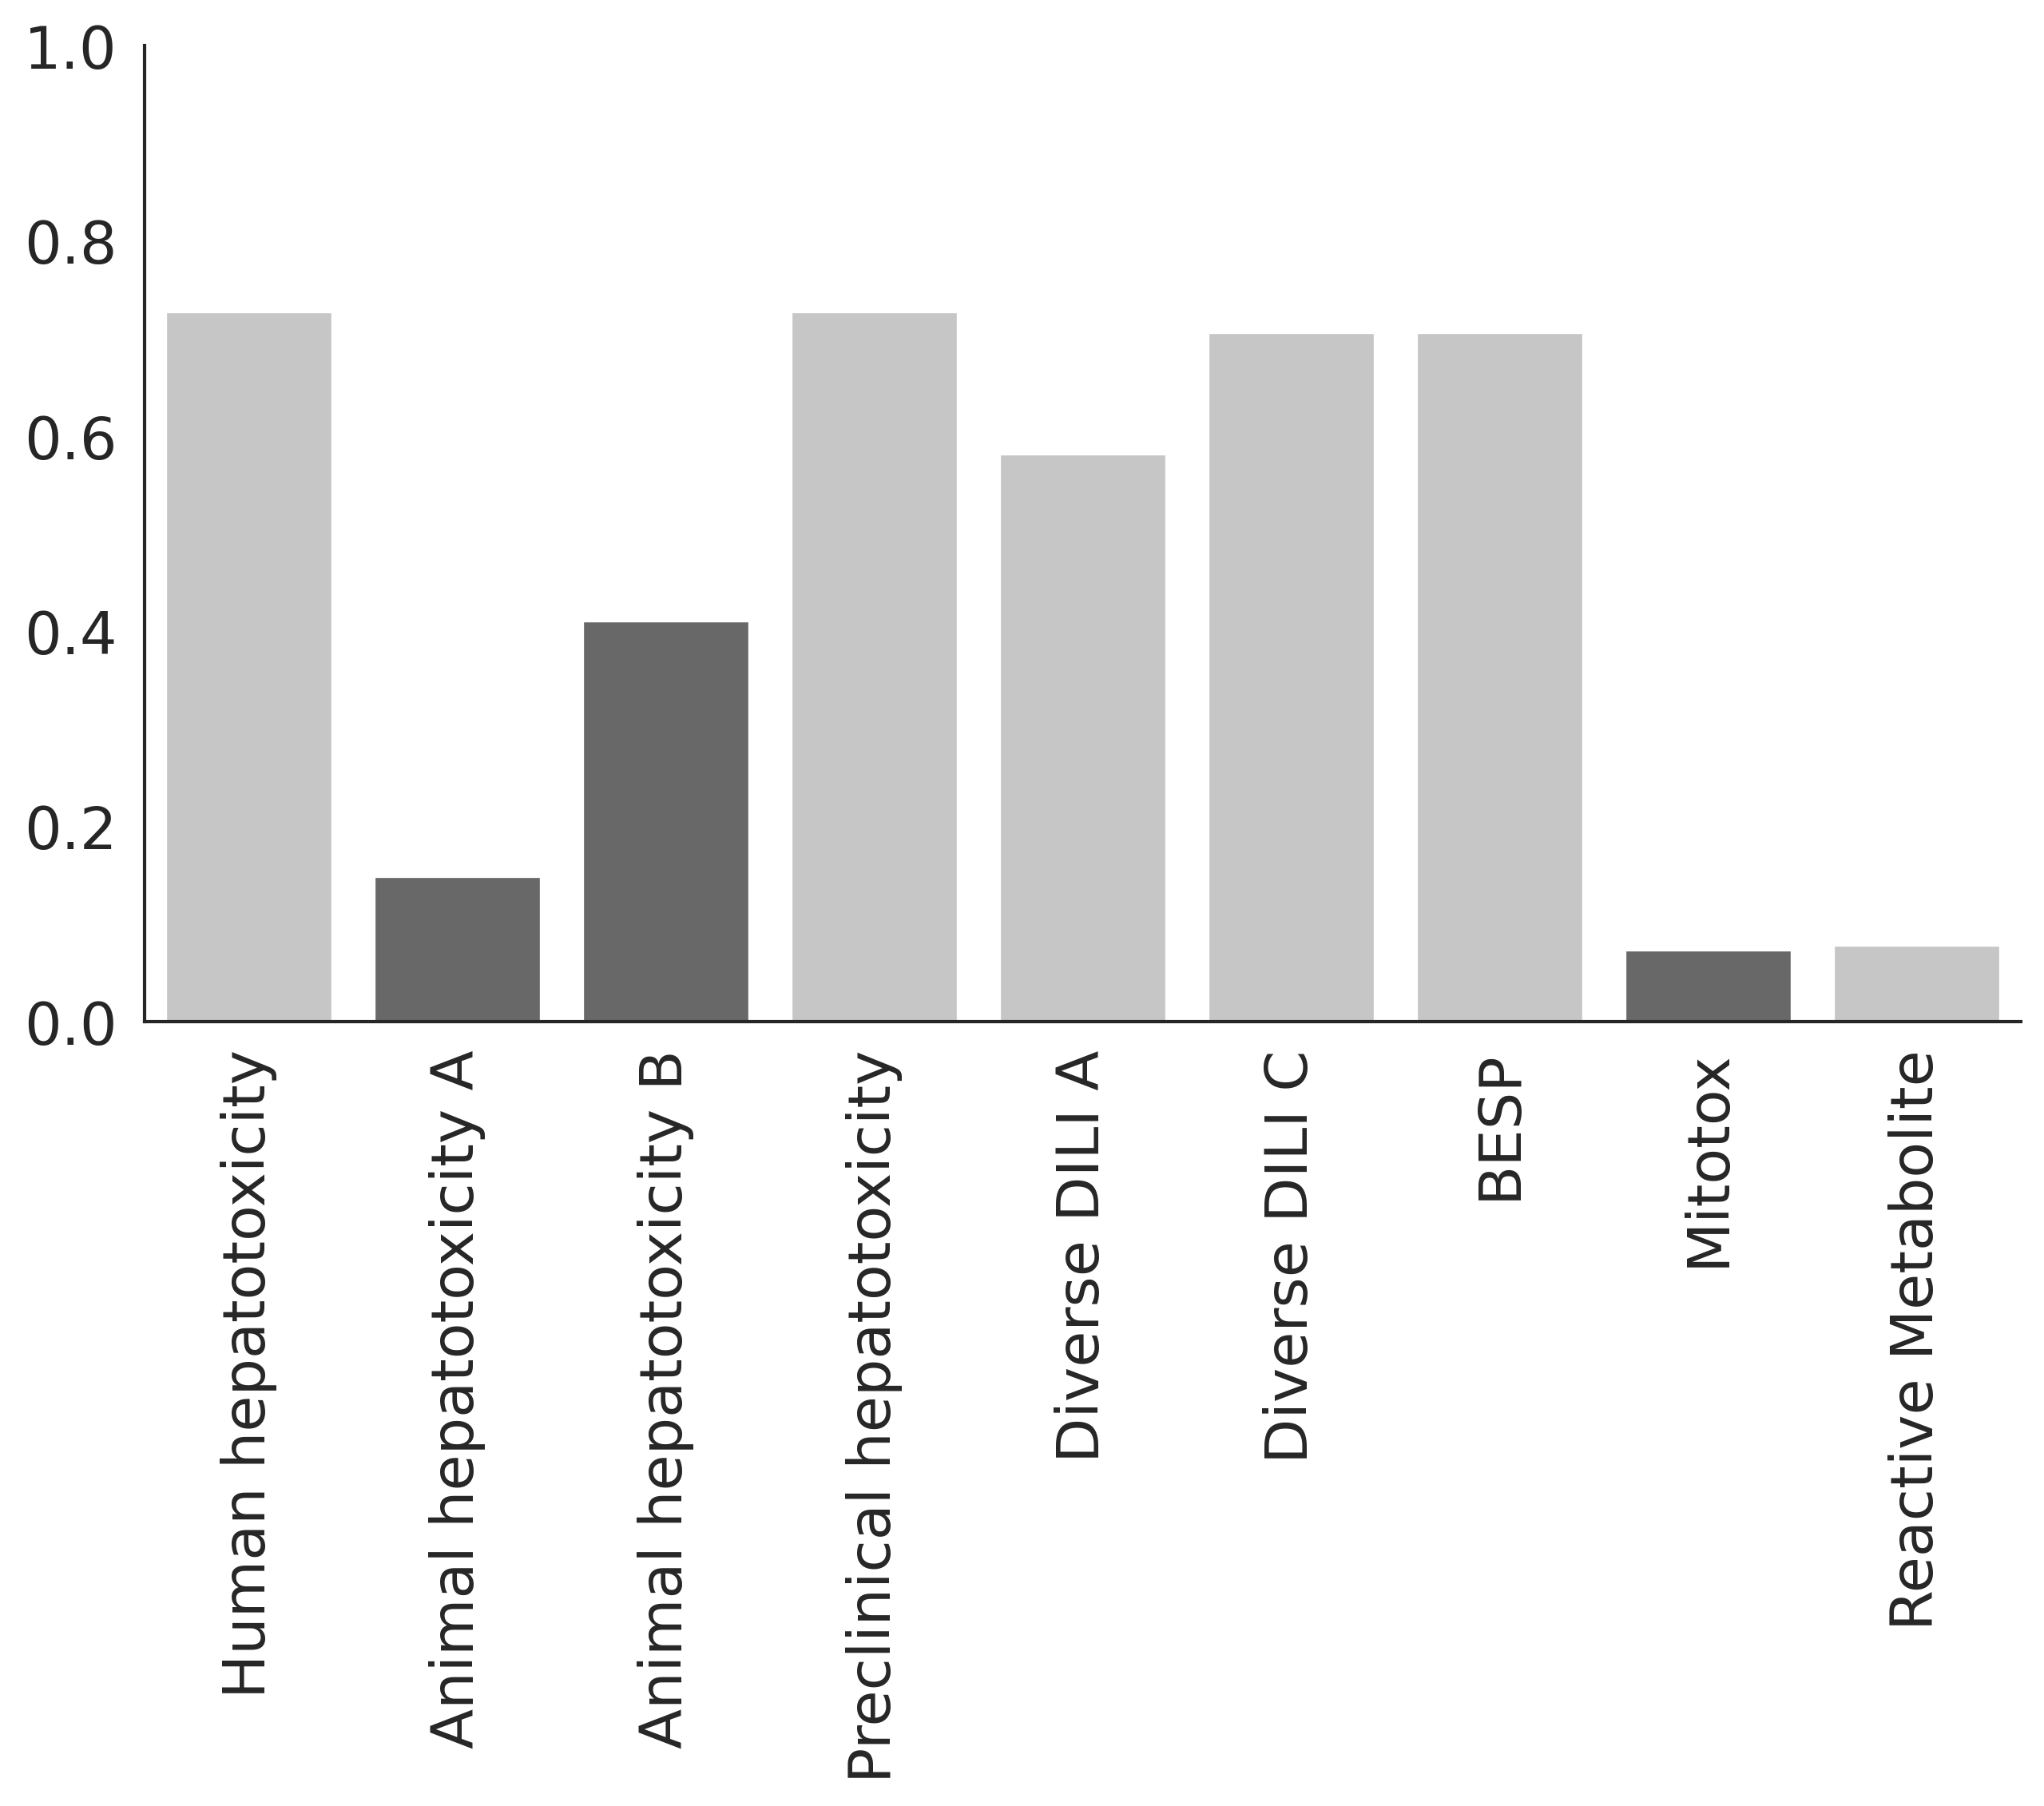

Paclitaxel
9


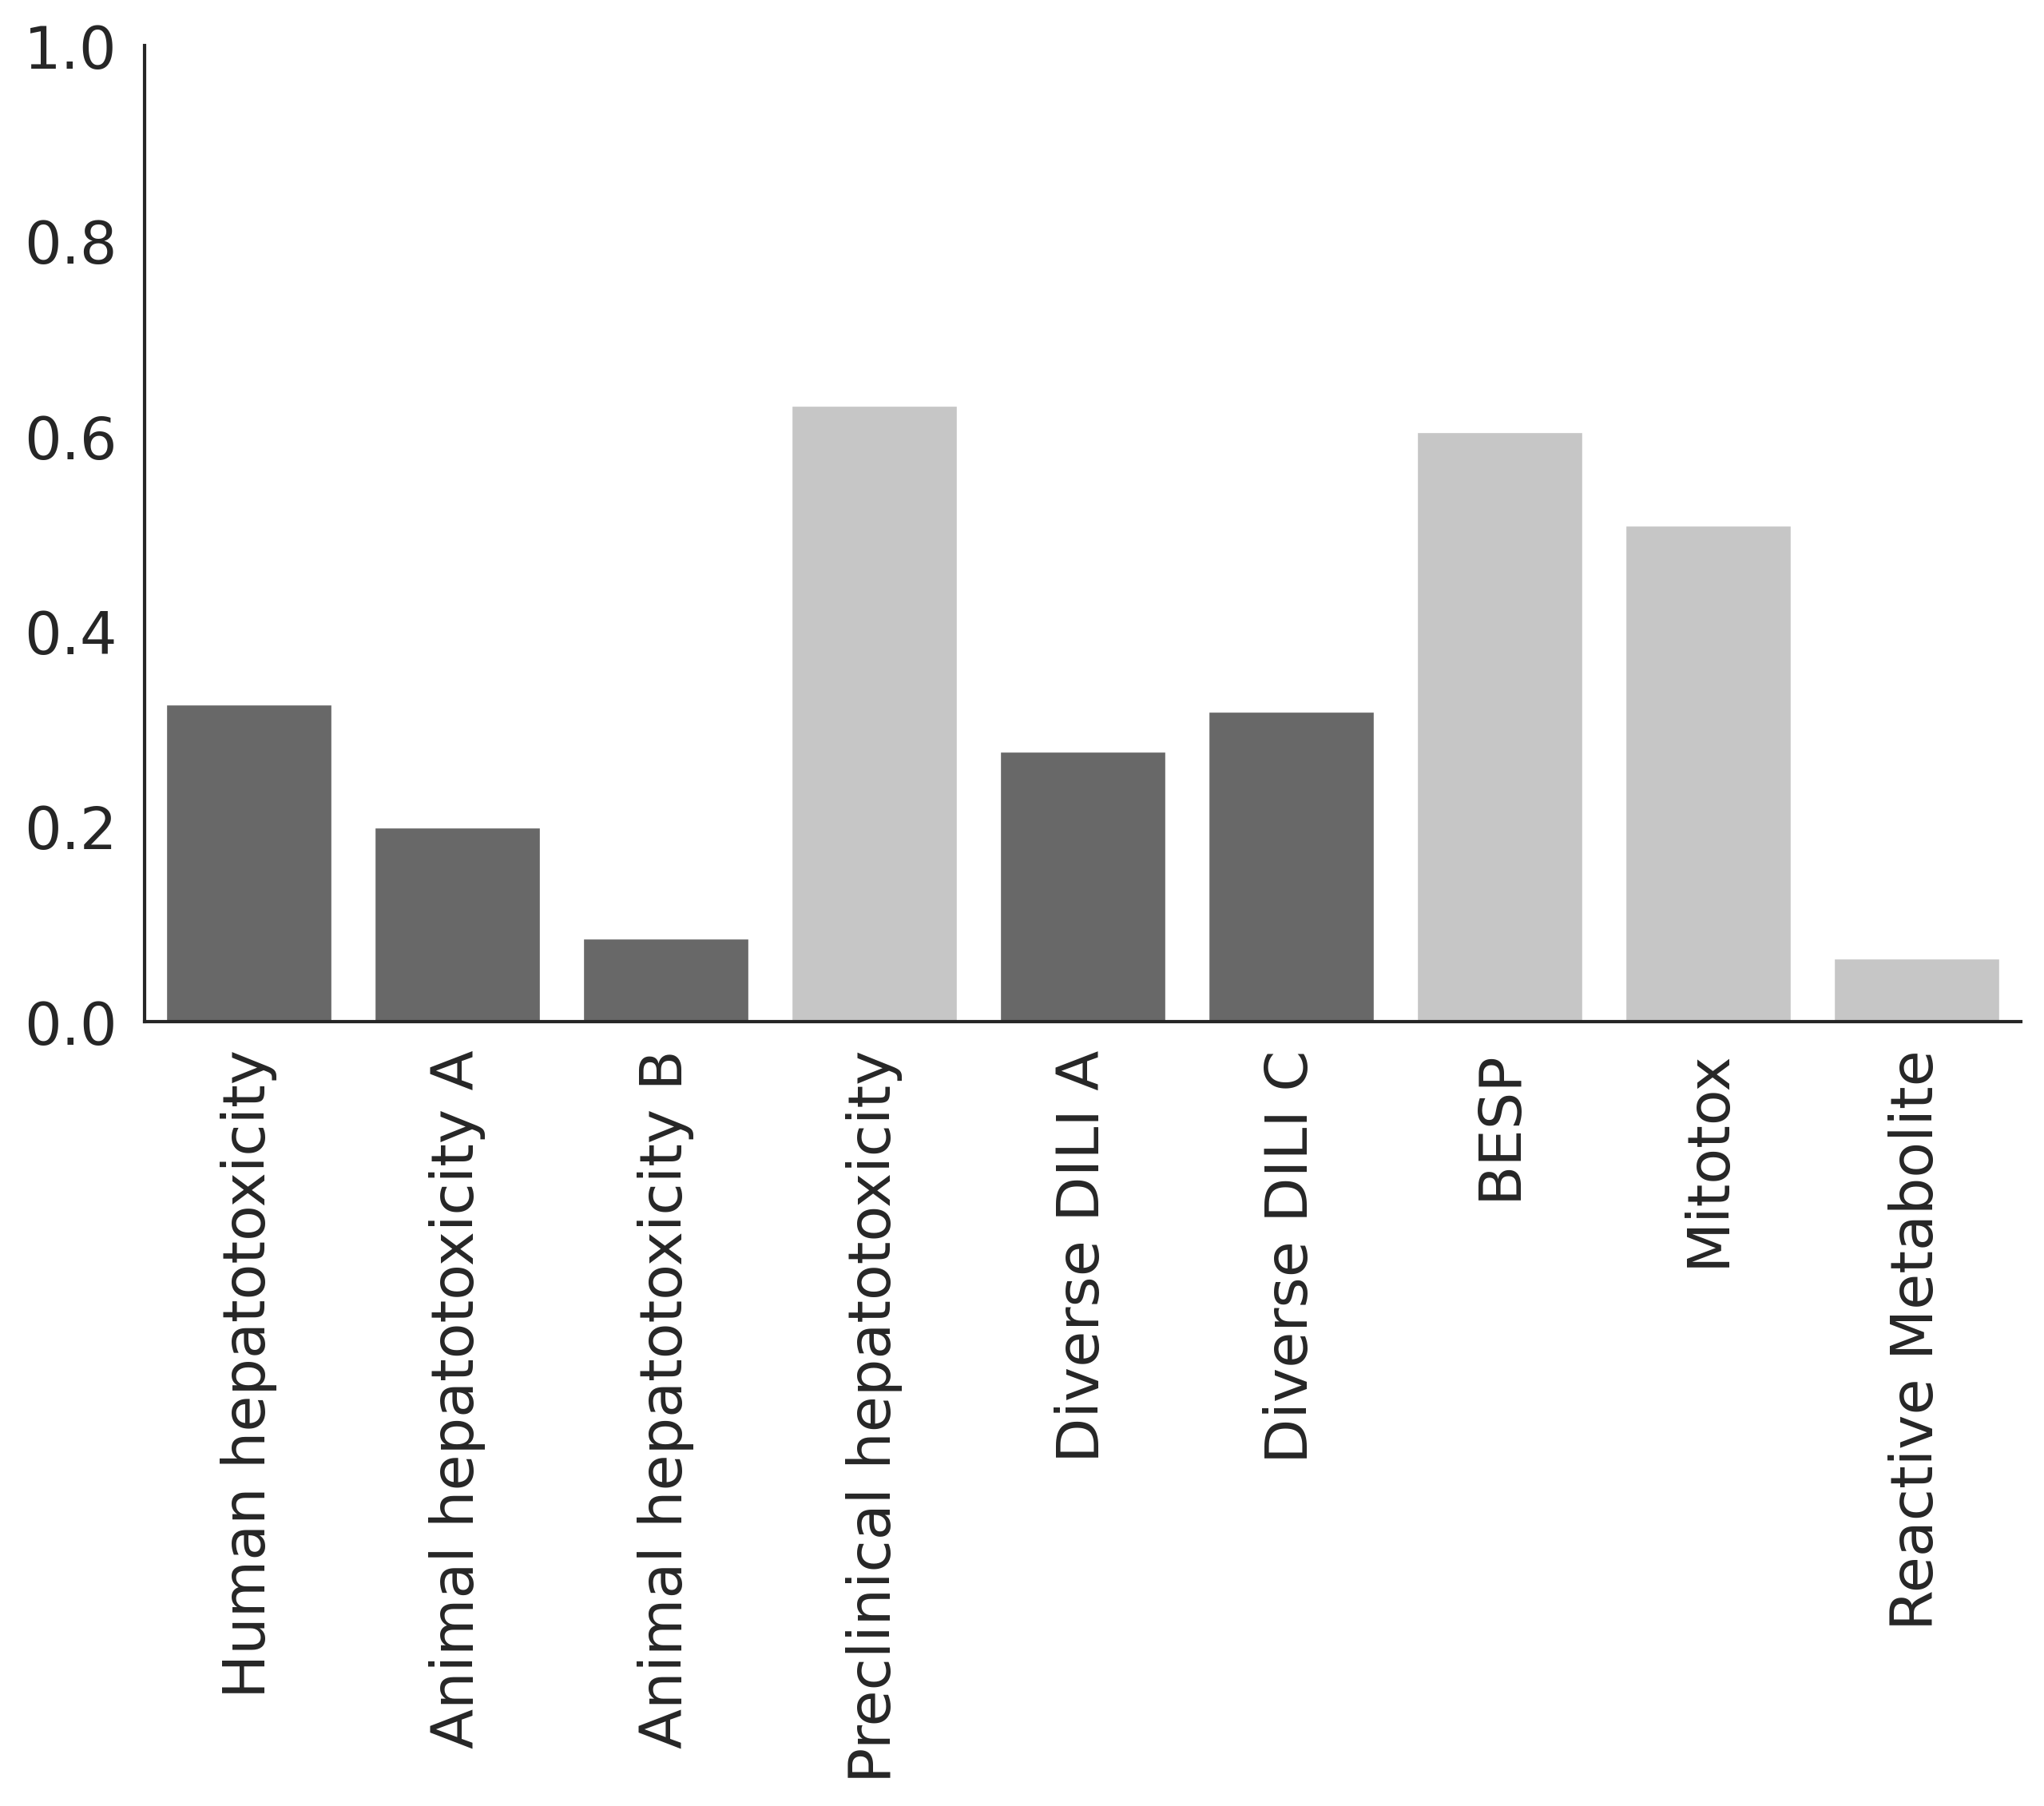

Trovafloxacin
9


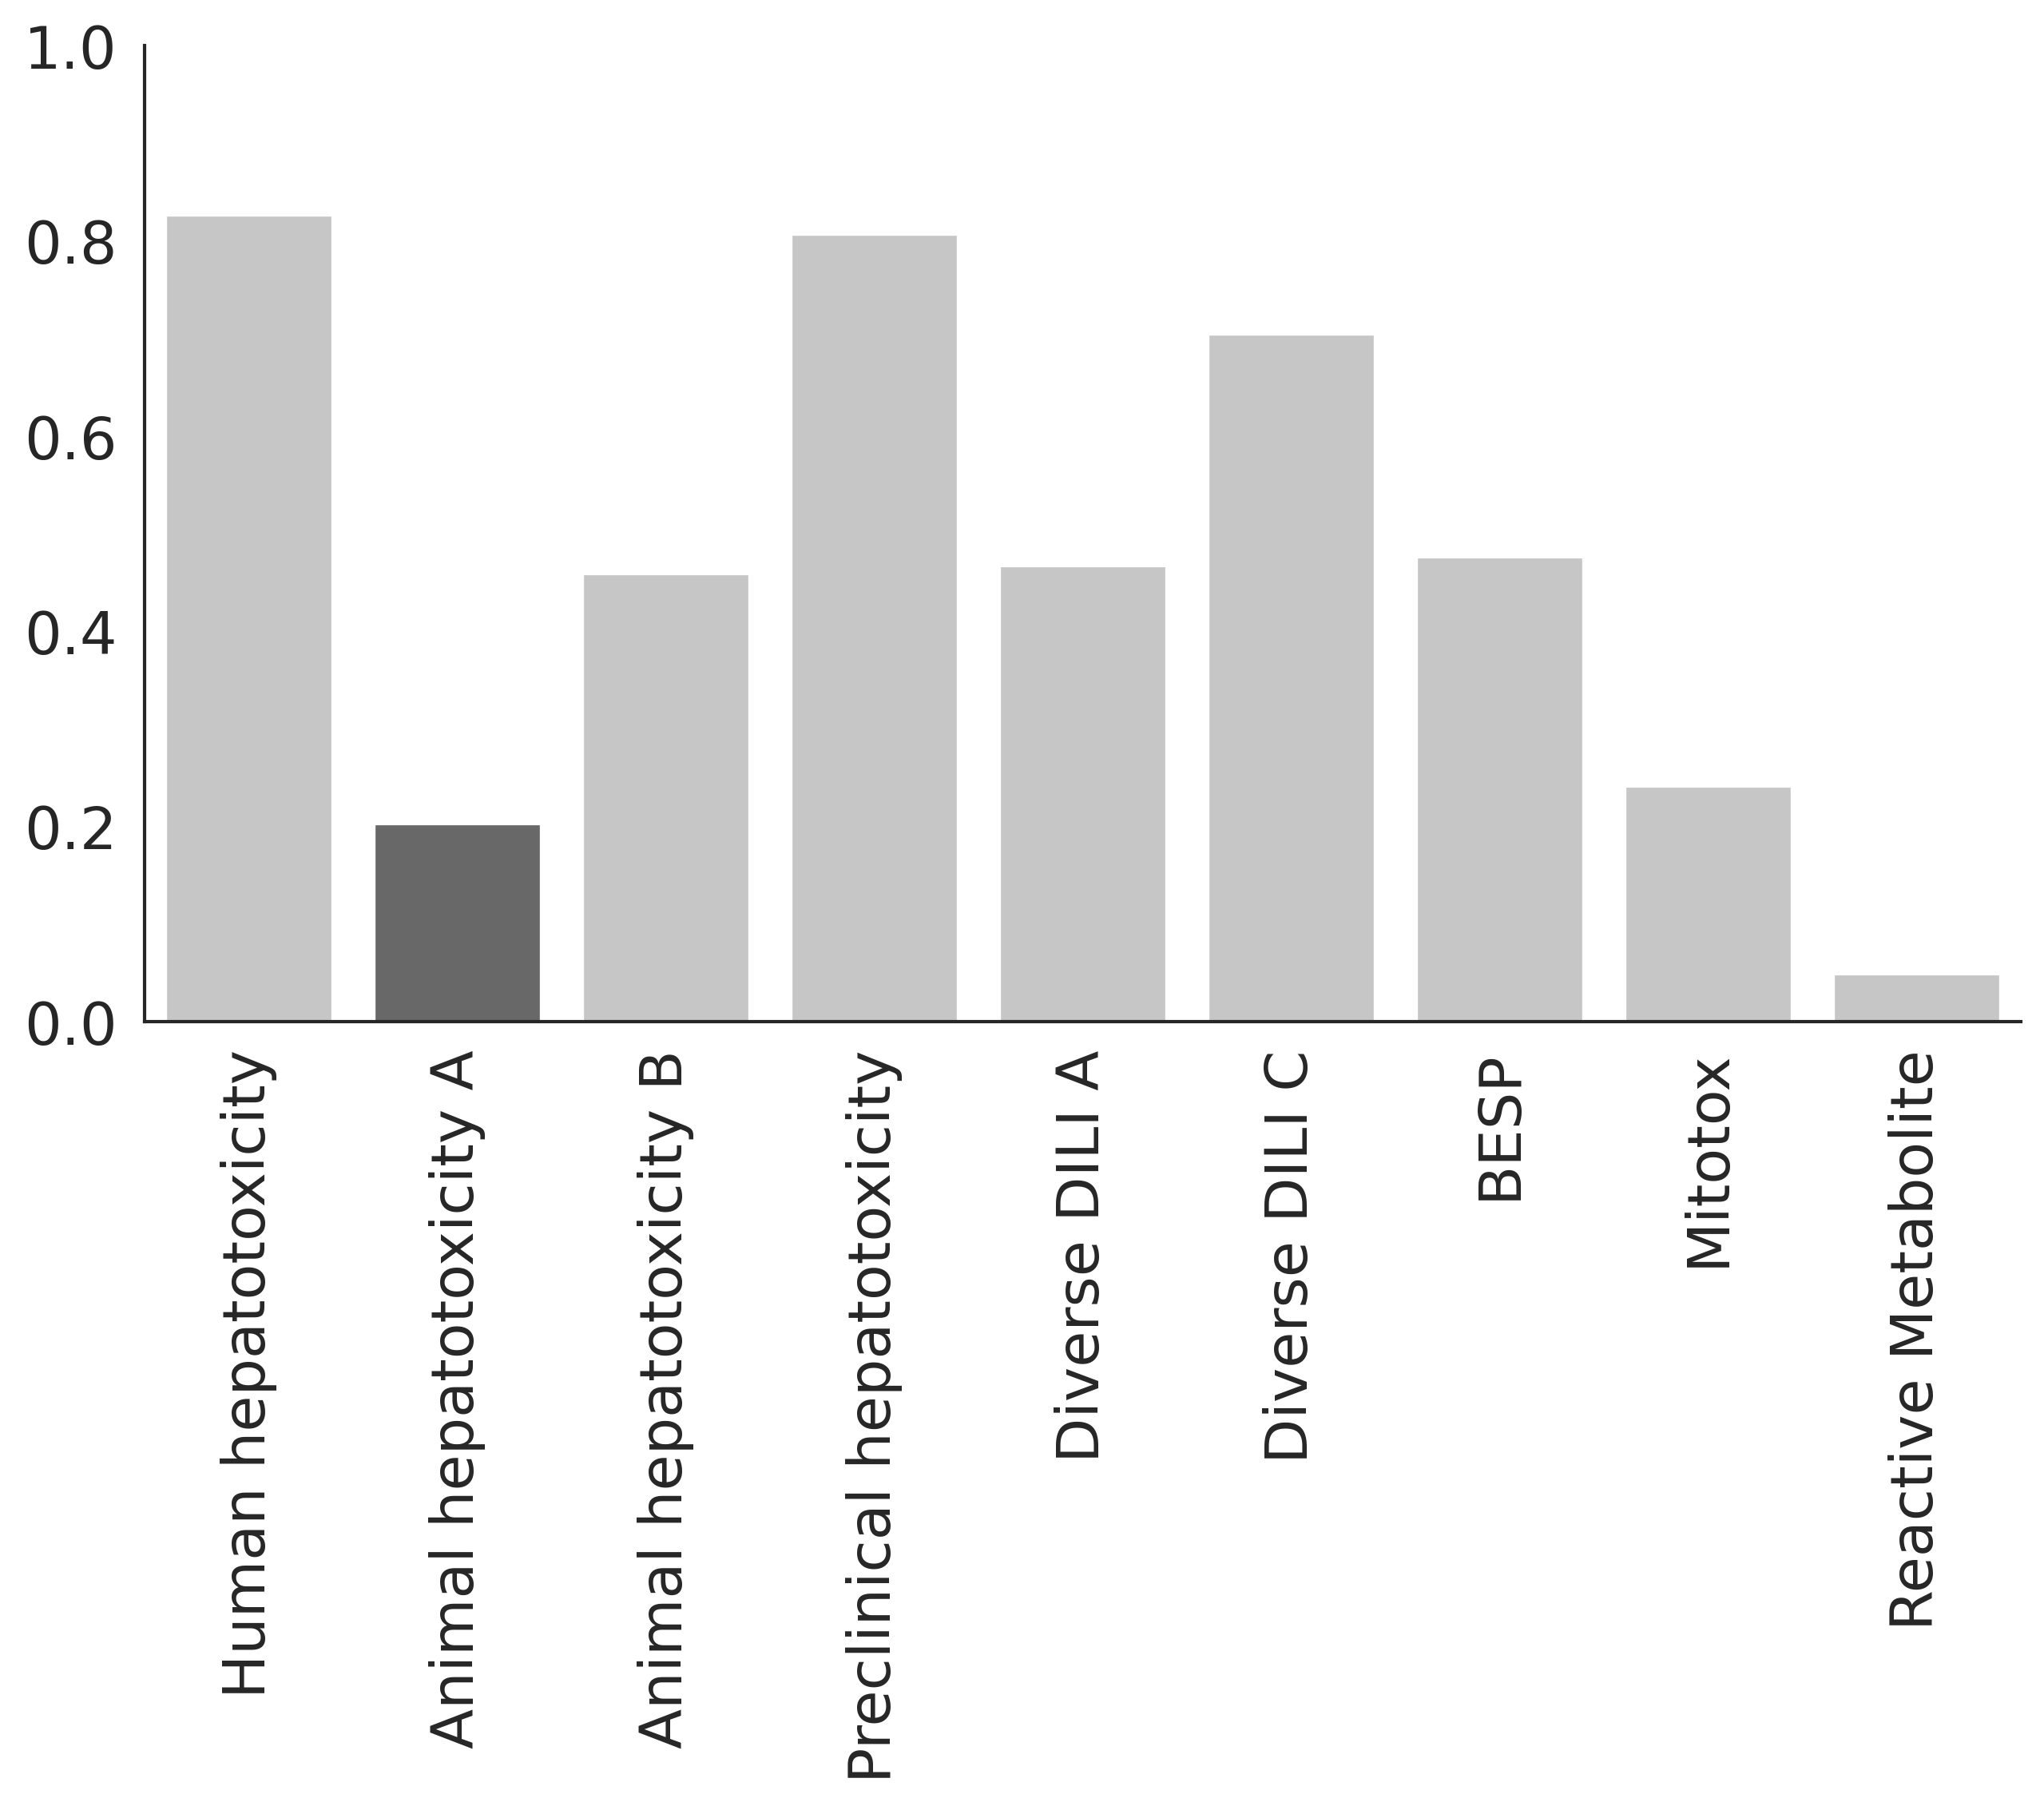

Ximelagatran
9


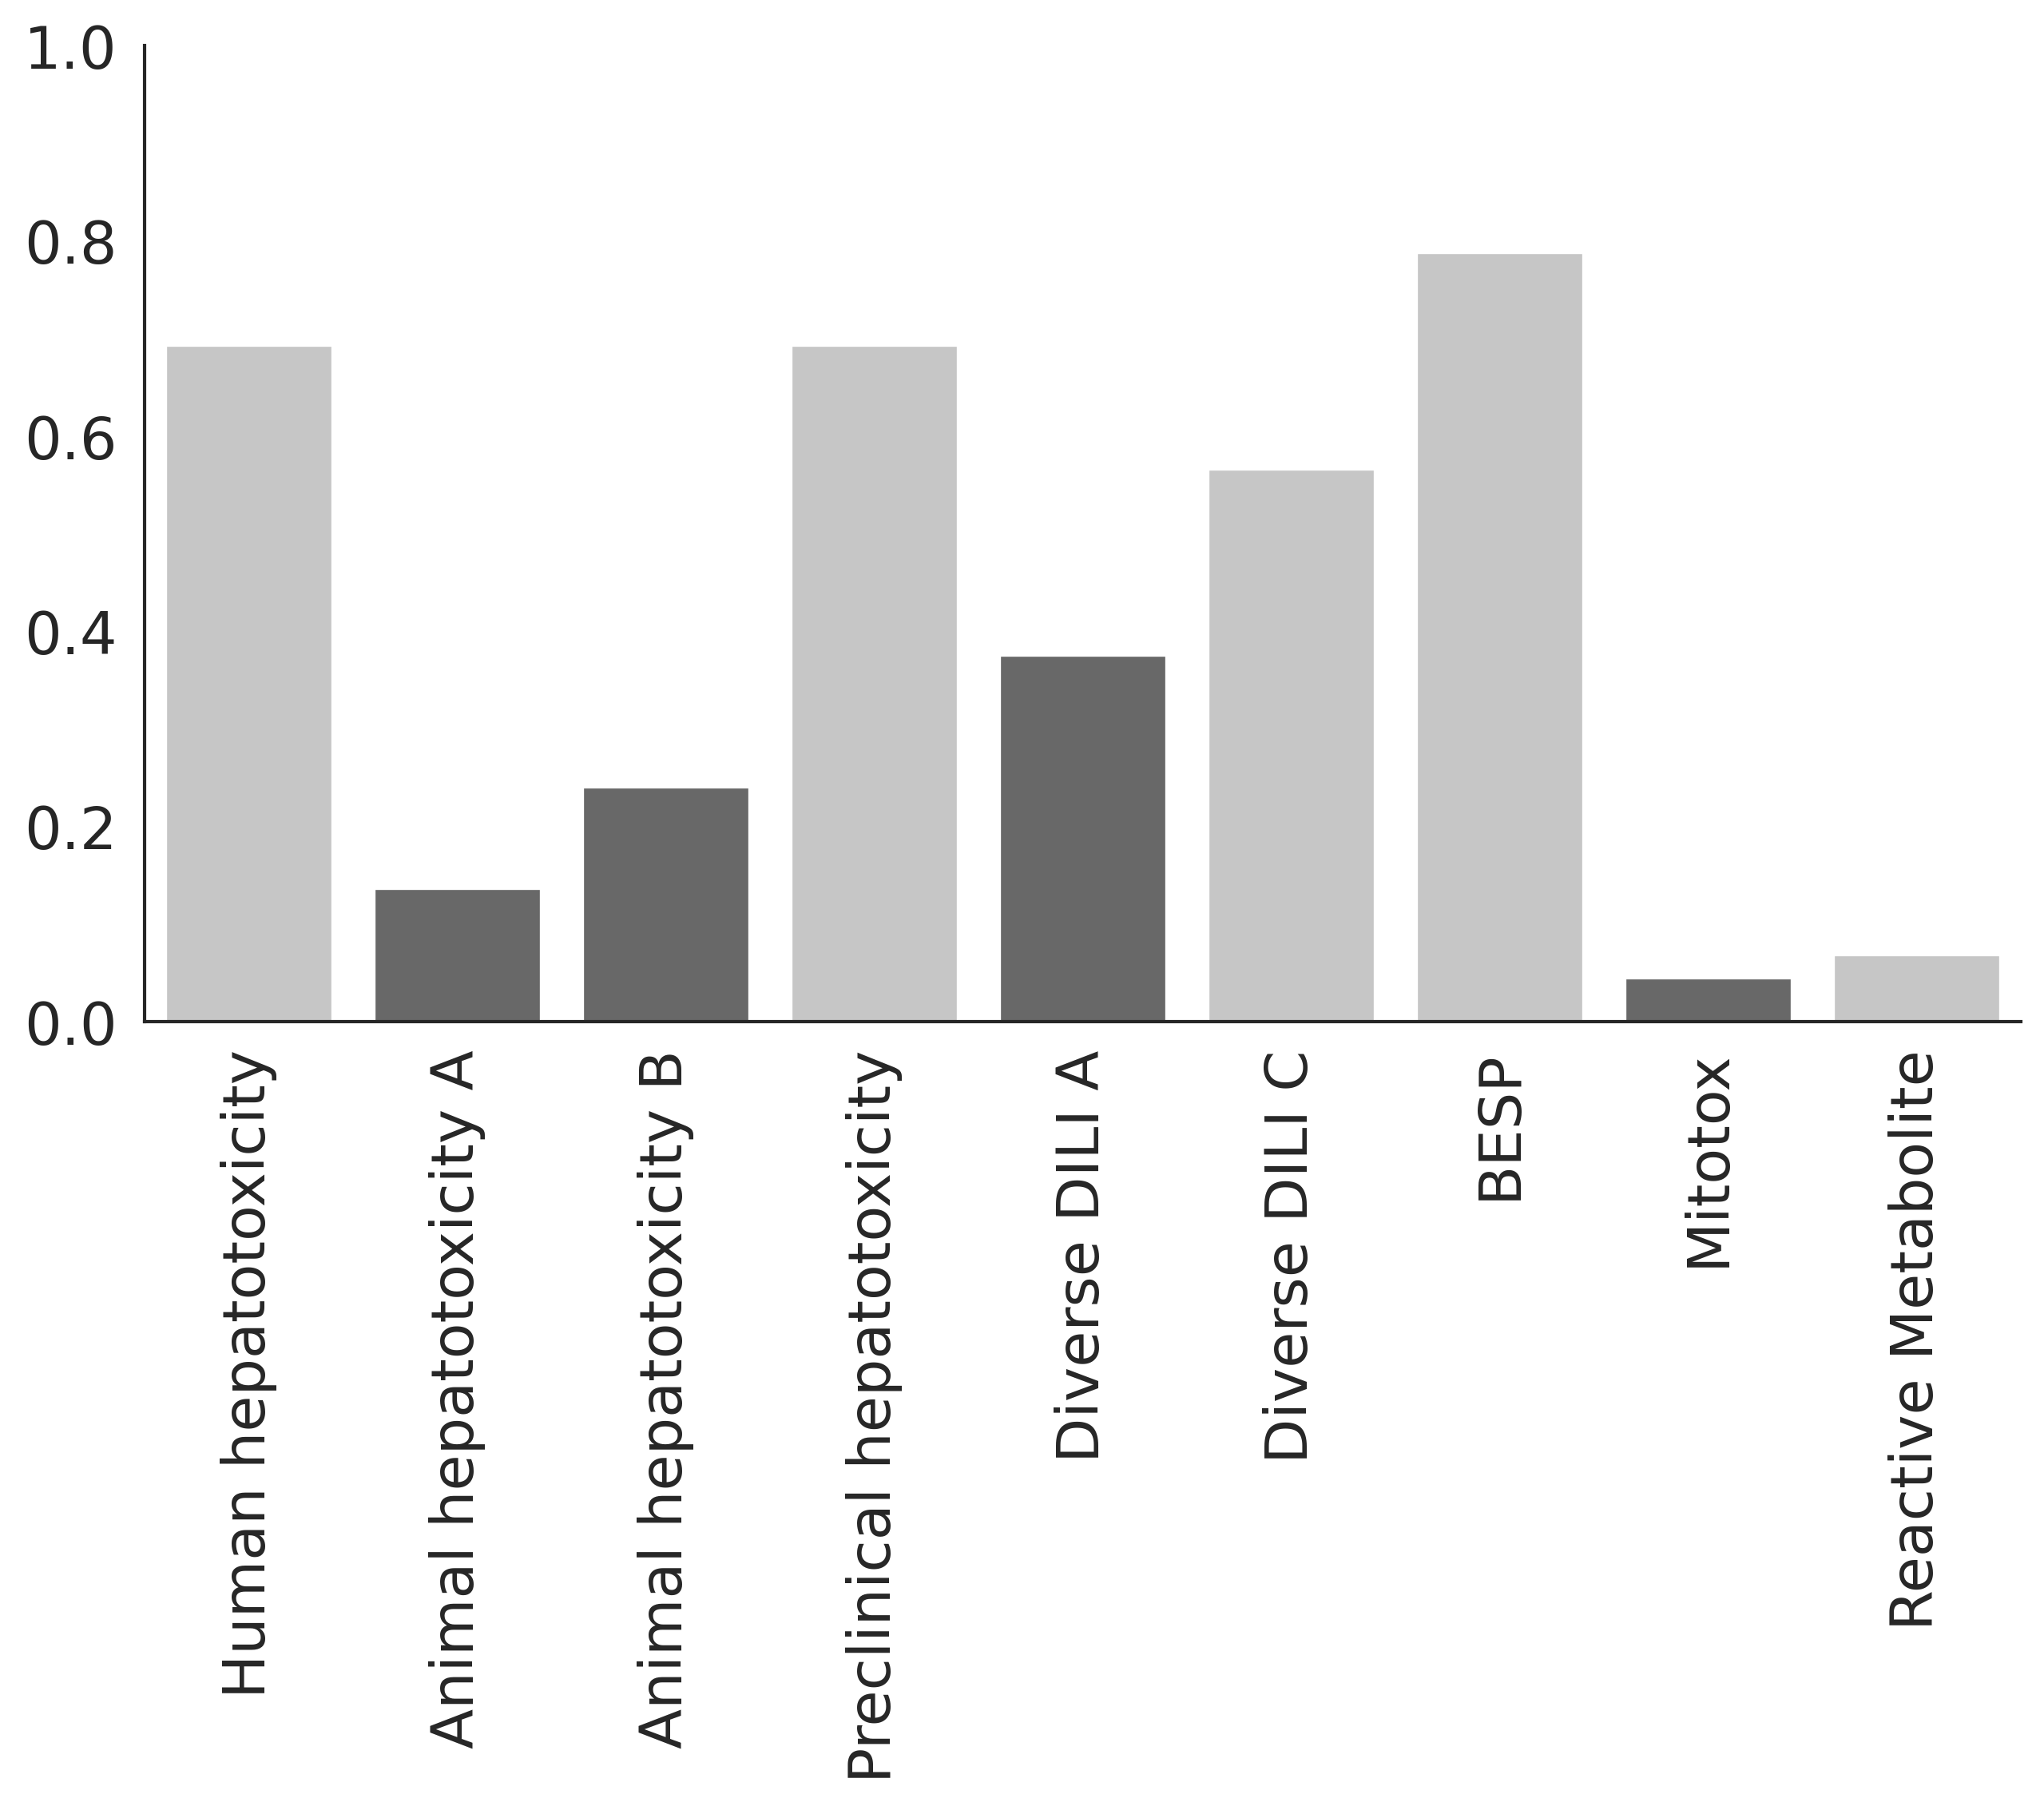

In [38]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

for compound_name in SHAP.compound.unique():
    print(compound_name)
    
    compound = SHAP[SHAP["compound"]==compound_name].sort_values(by=["name"], ascending=True)
    print(len(compound))
    

    #fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
    sns.set_style('white')
    sns.set_context('paper', font_scale=2)
    hue_order = ['Positive', 'Negative']
    #sns.barplot(data=compound, x="source", y="value", color='grey')
    g = sns.catplot(data=compound, x="source", y="value", kind="bar",hue_order=hue_order,  hue="SHAP contribution to Toxicity",  
                    palette="Greys", 
                    height=5, aspect=2, dodge=False, legend=False)
    #plt.axhline(y=0.5, color='r', linestyle='--')
    g.set_xticklabels(rotation=90)
    g.set(ylabel=None)
    g.set(xlabel=None)
    g.set(ylim=(0, 1))
    plt.show()

Acitretin
9


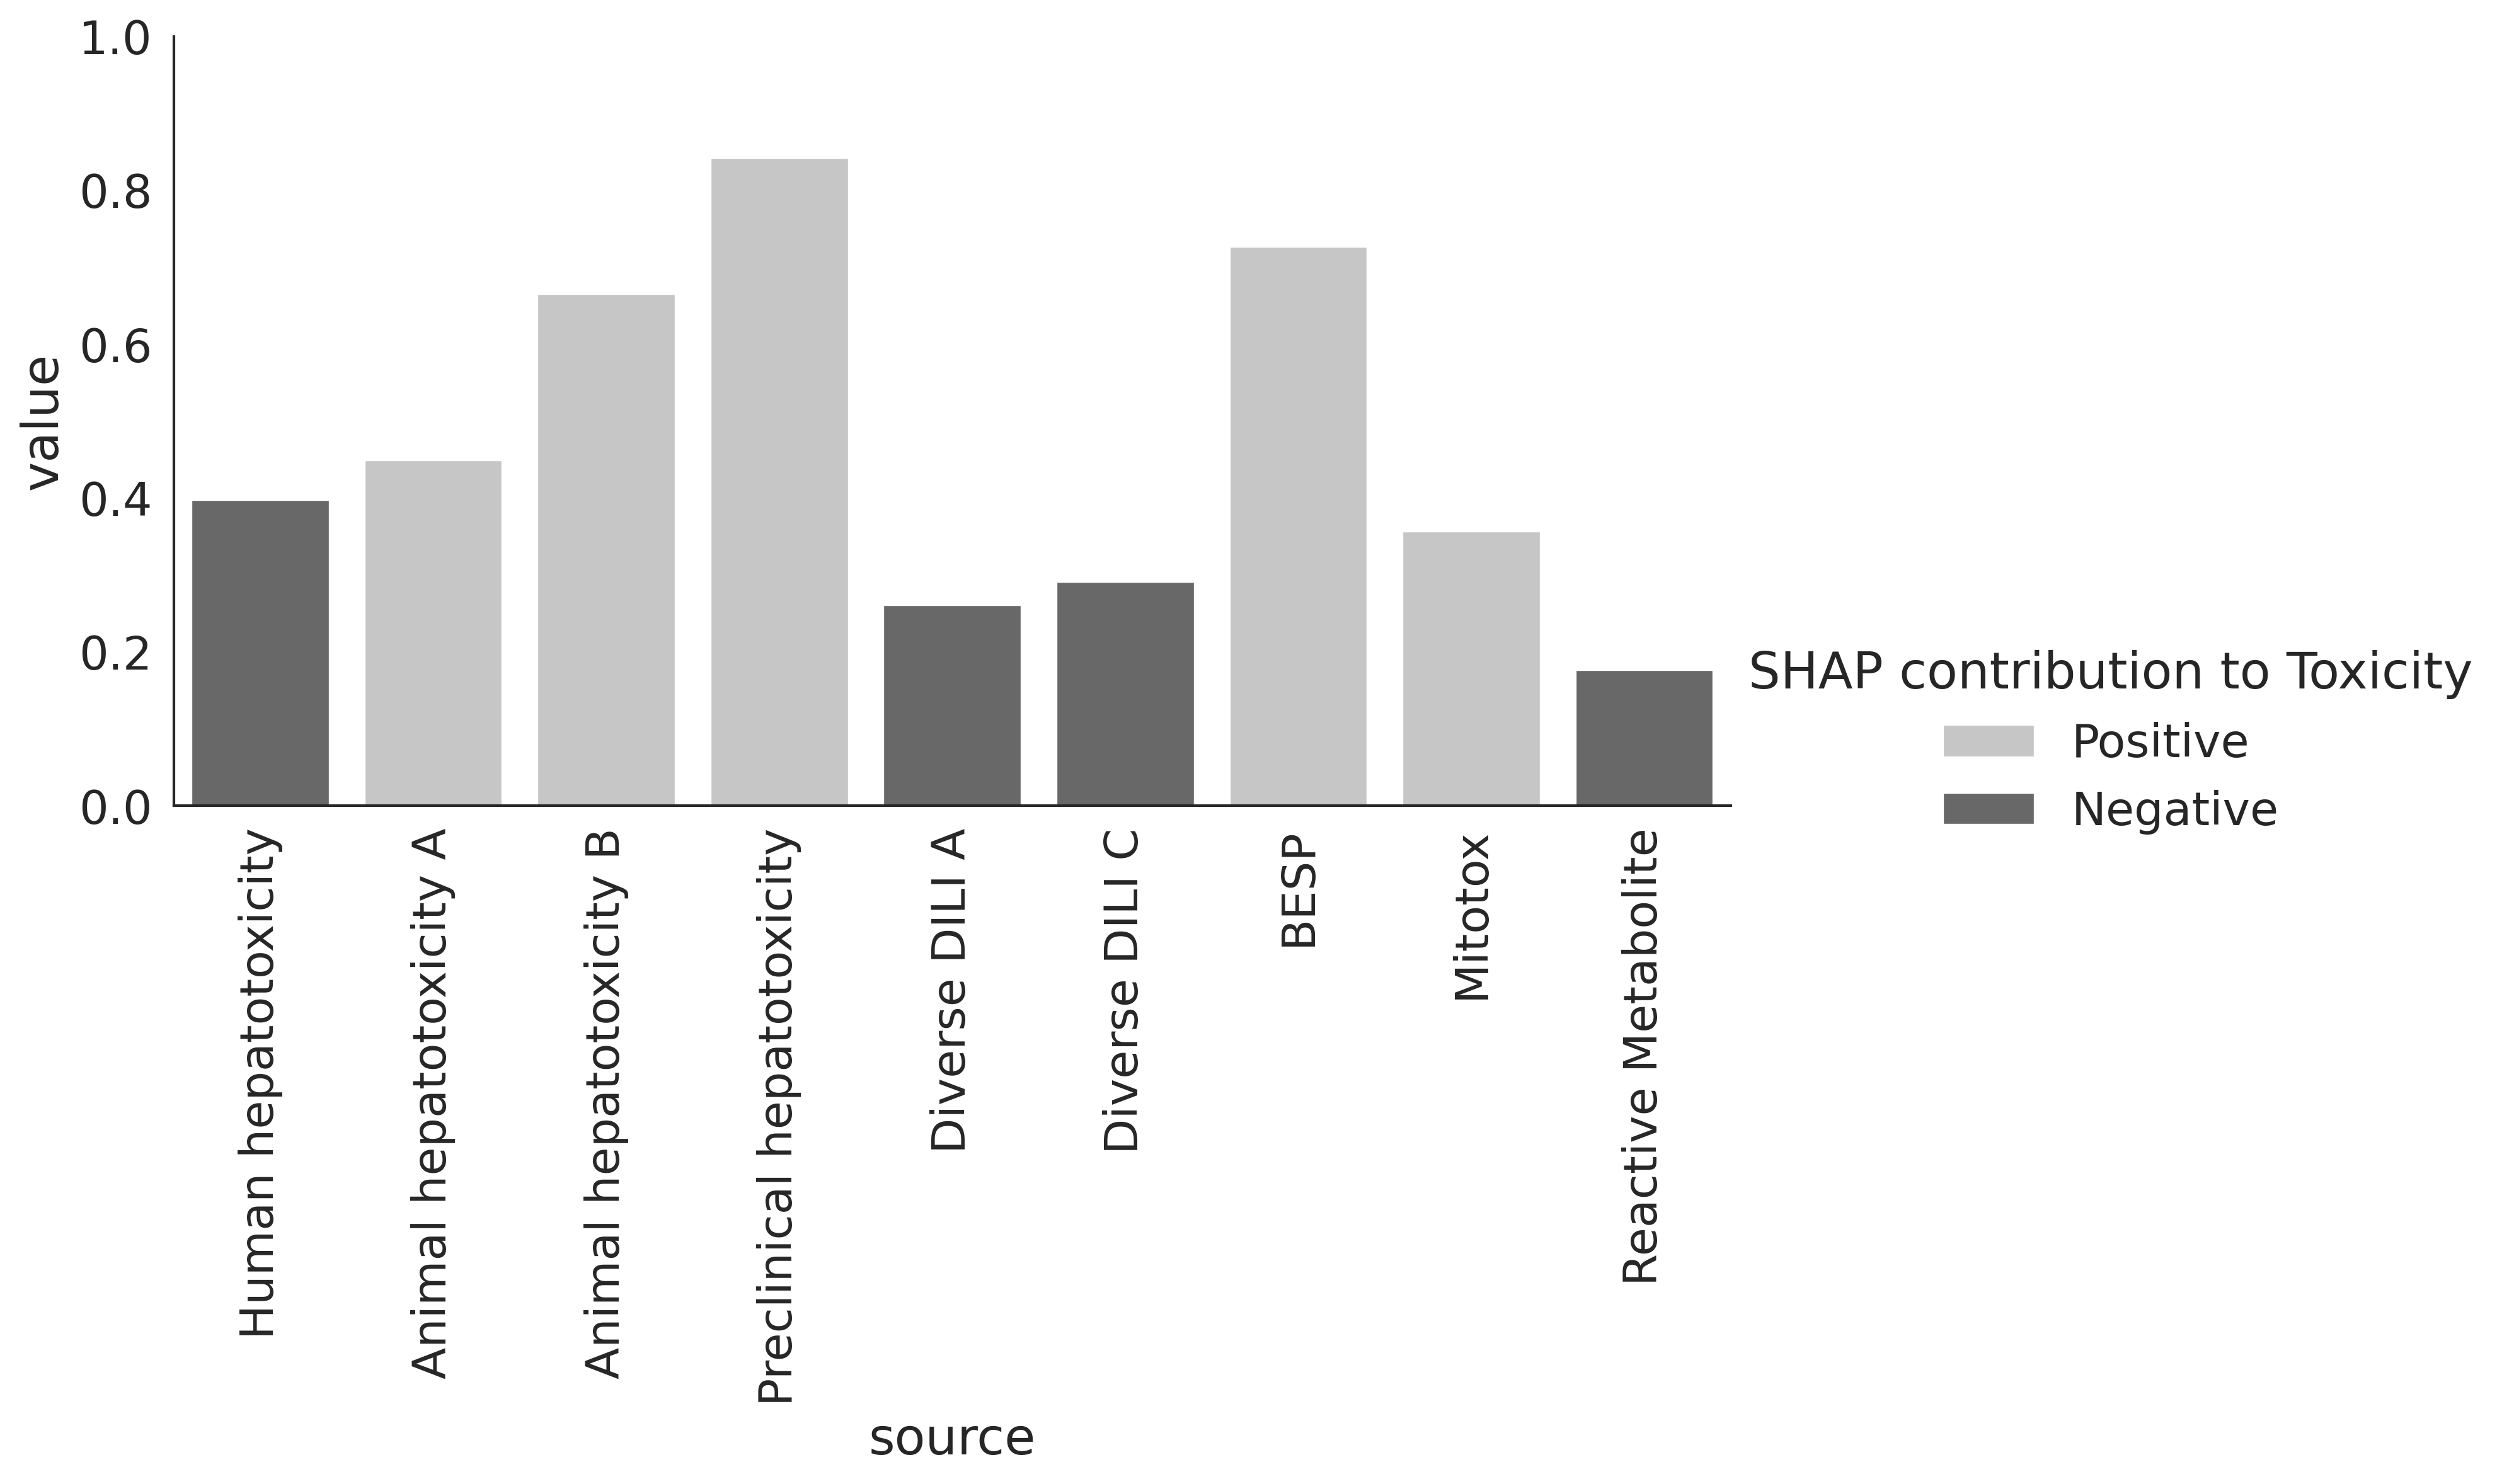

Cabazitaxel
9


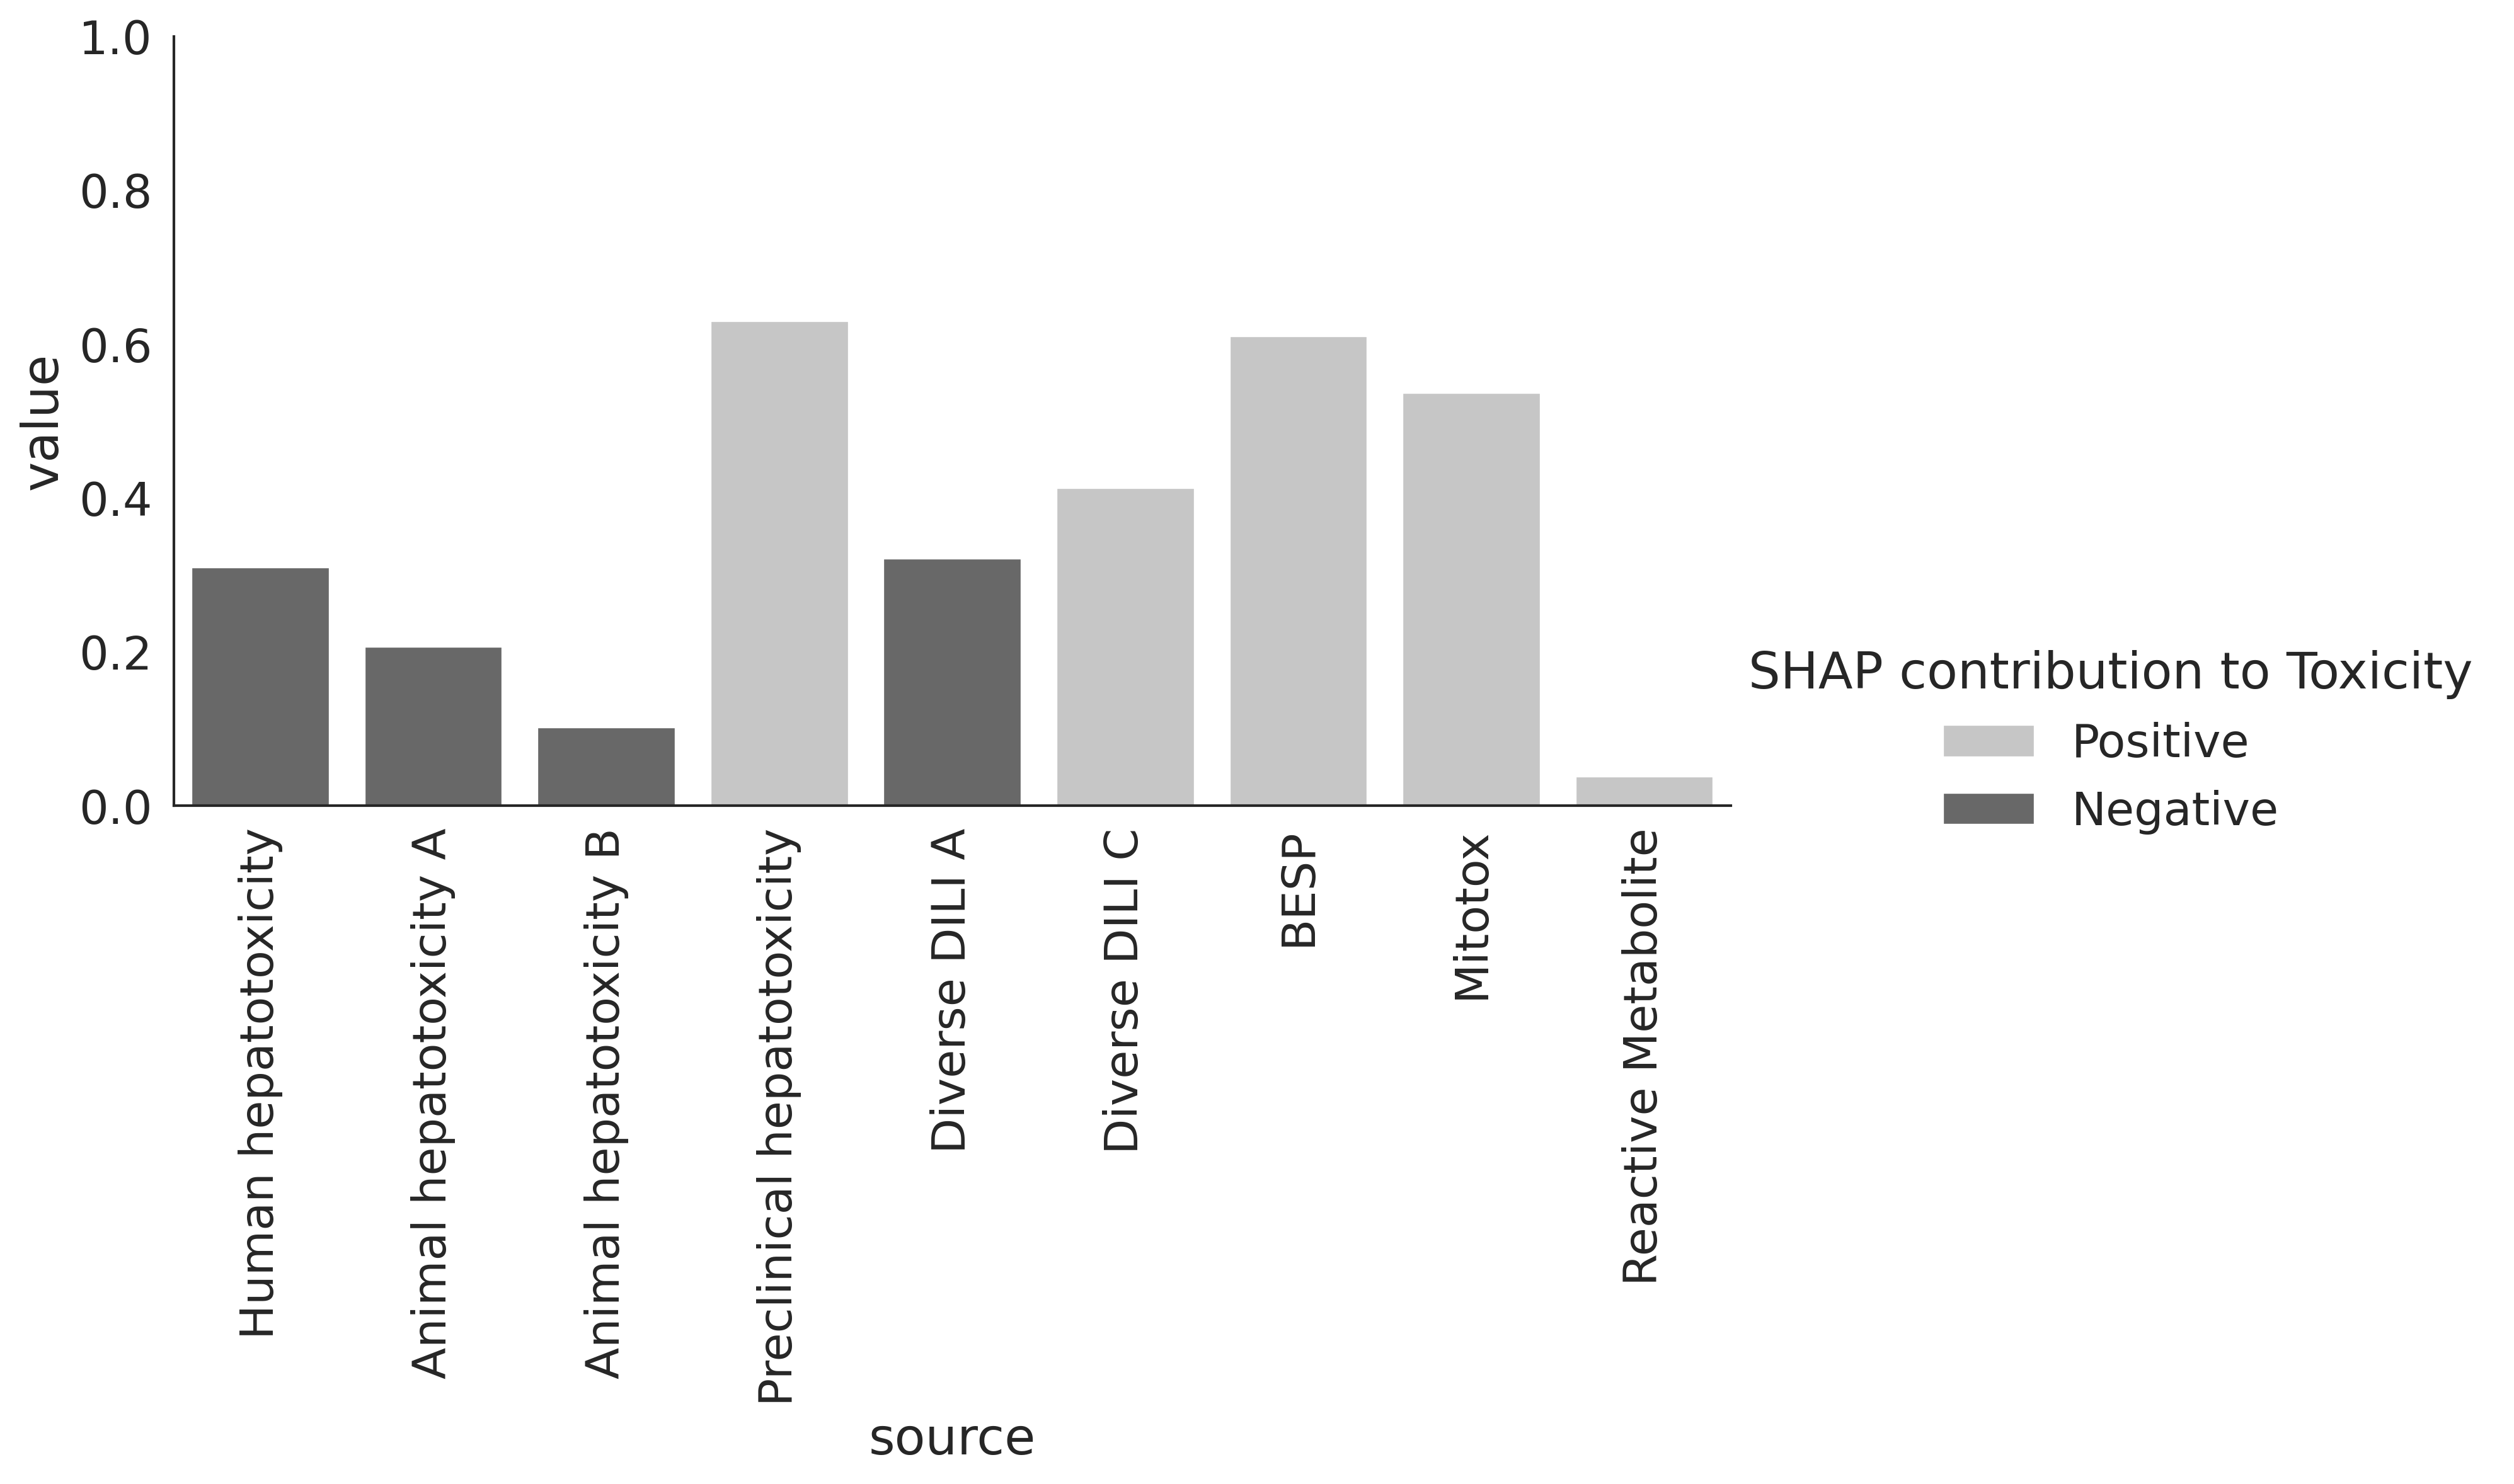

Clopidogrel
9


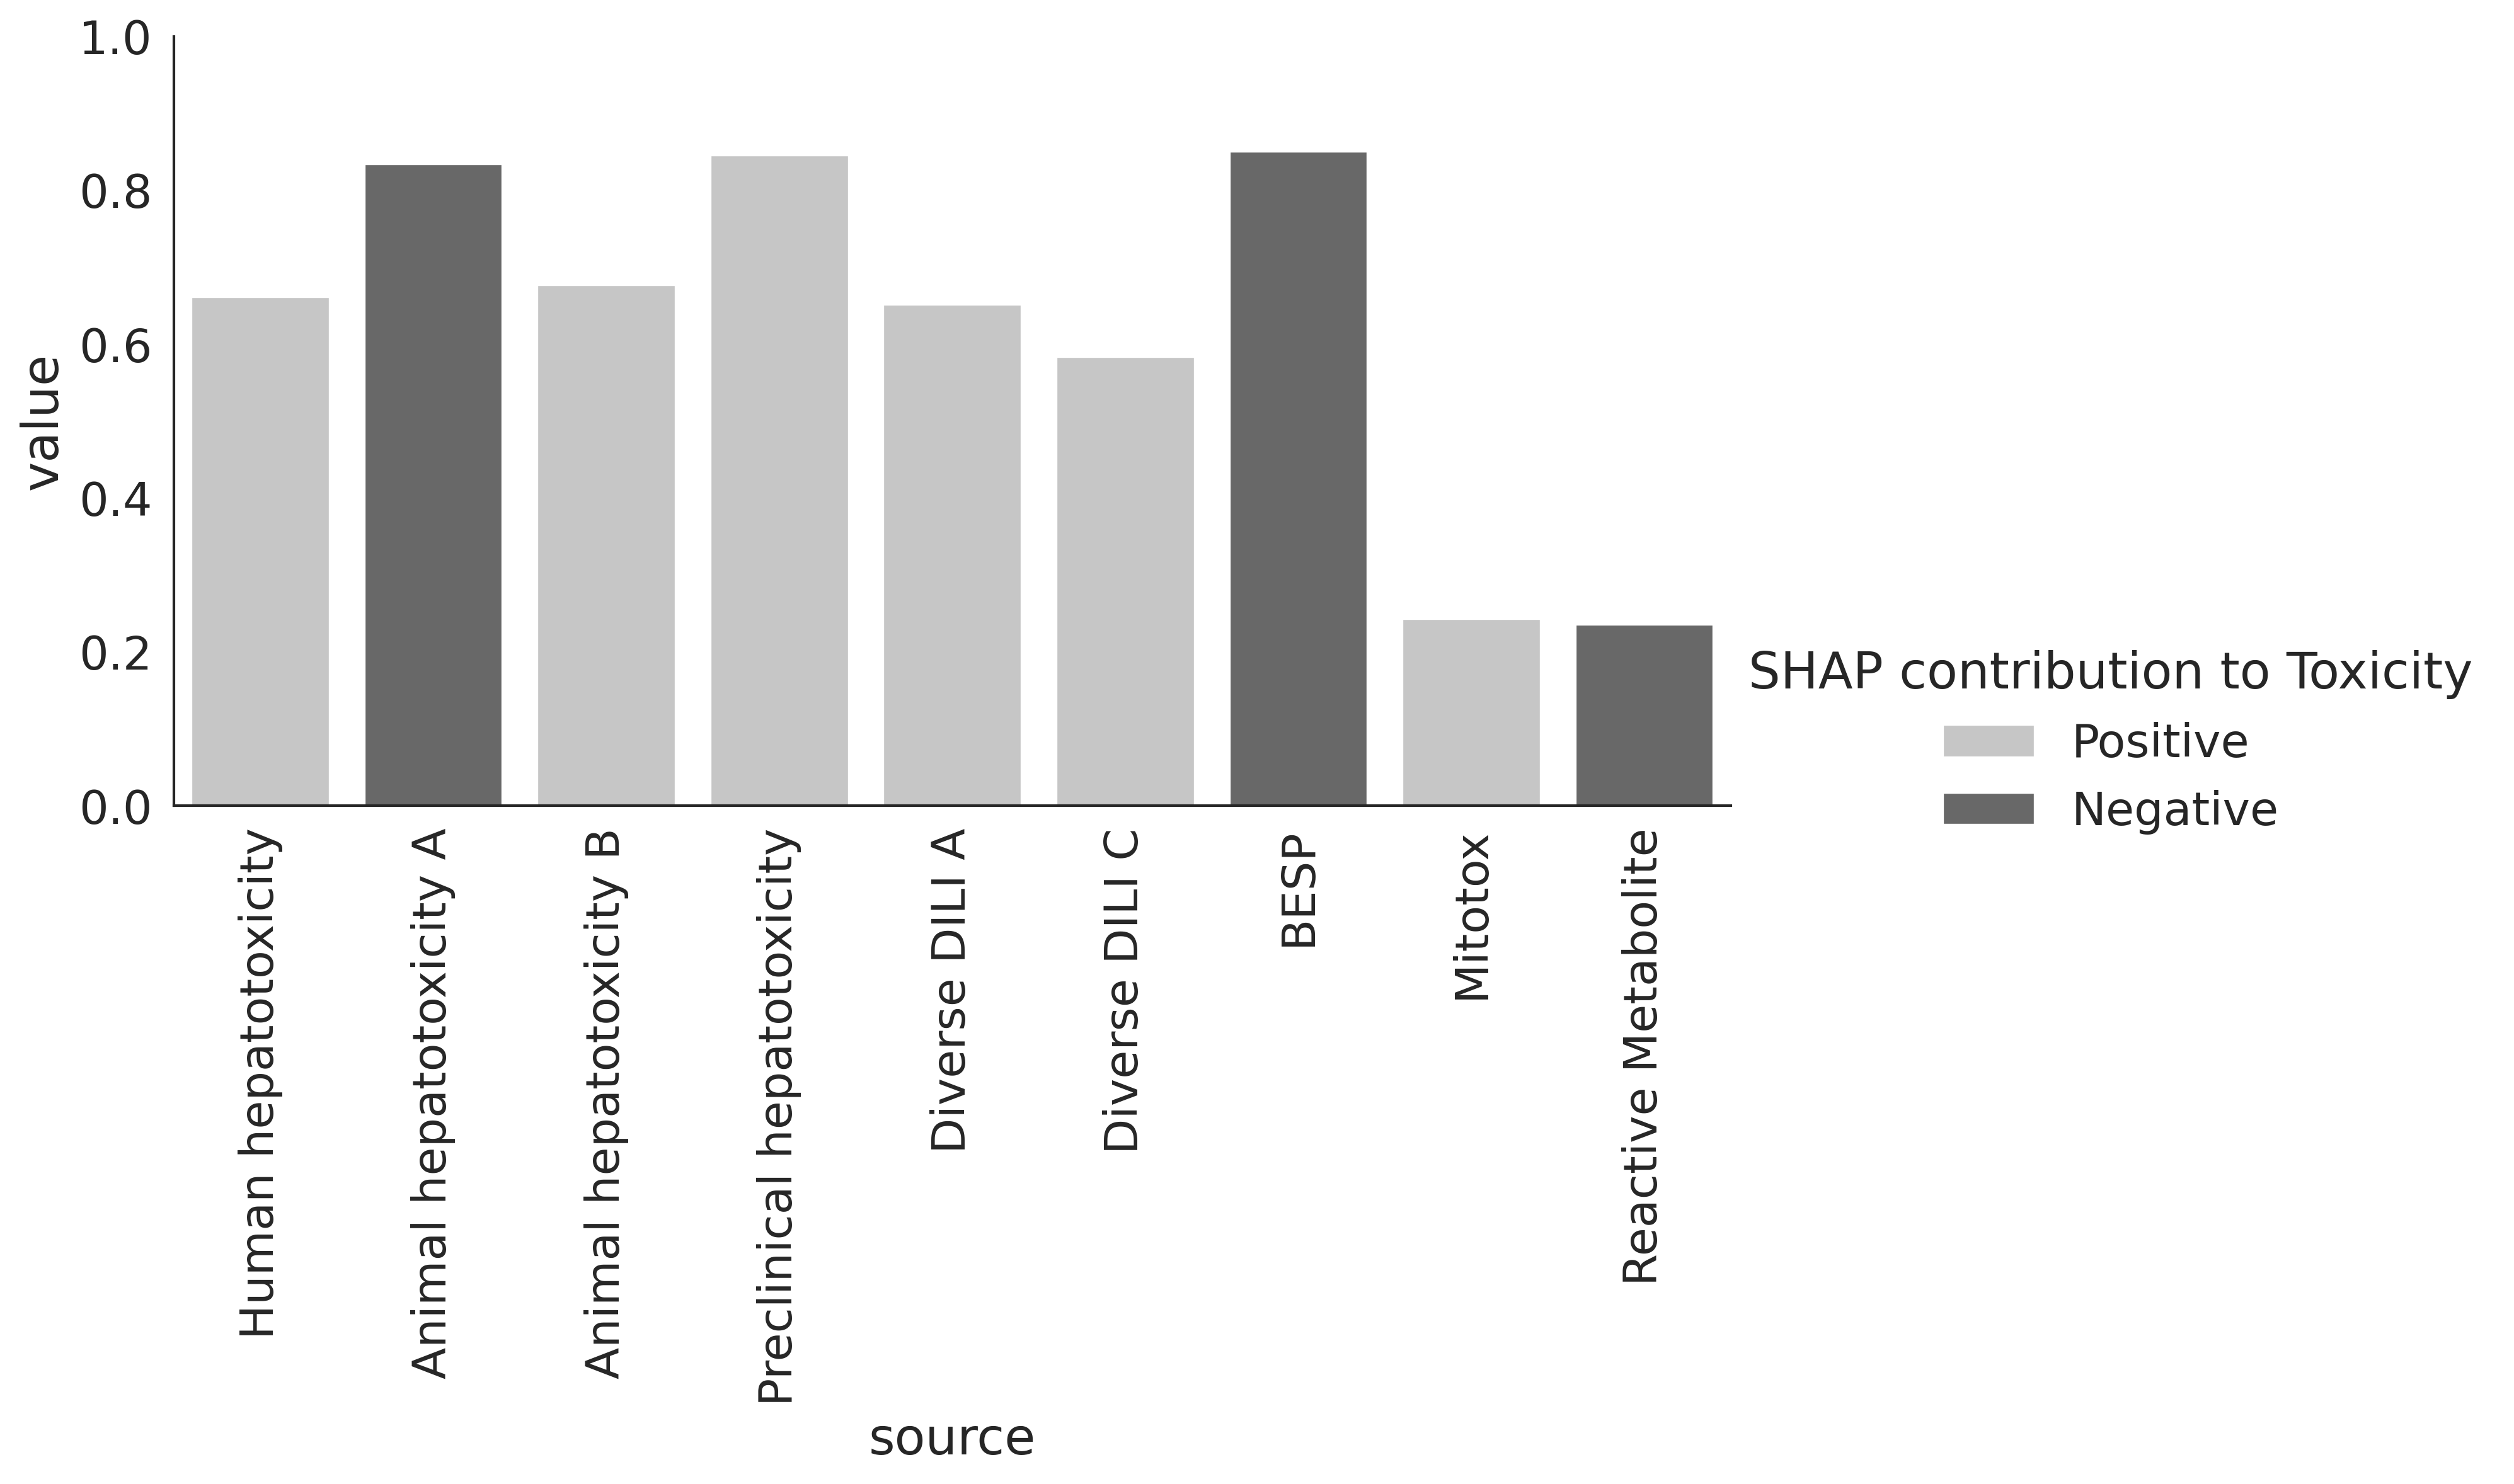

Docetaxel
9


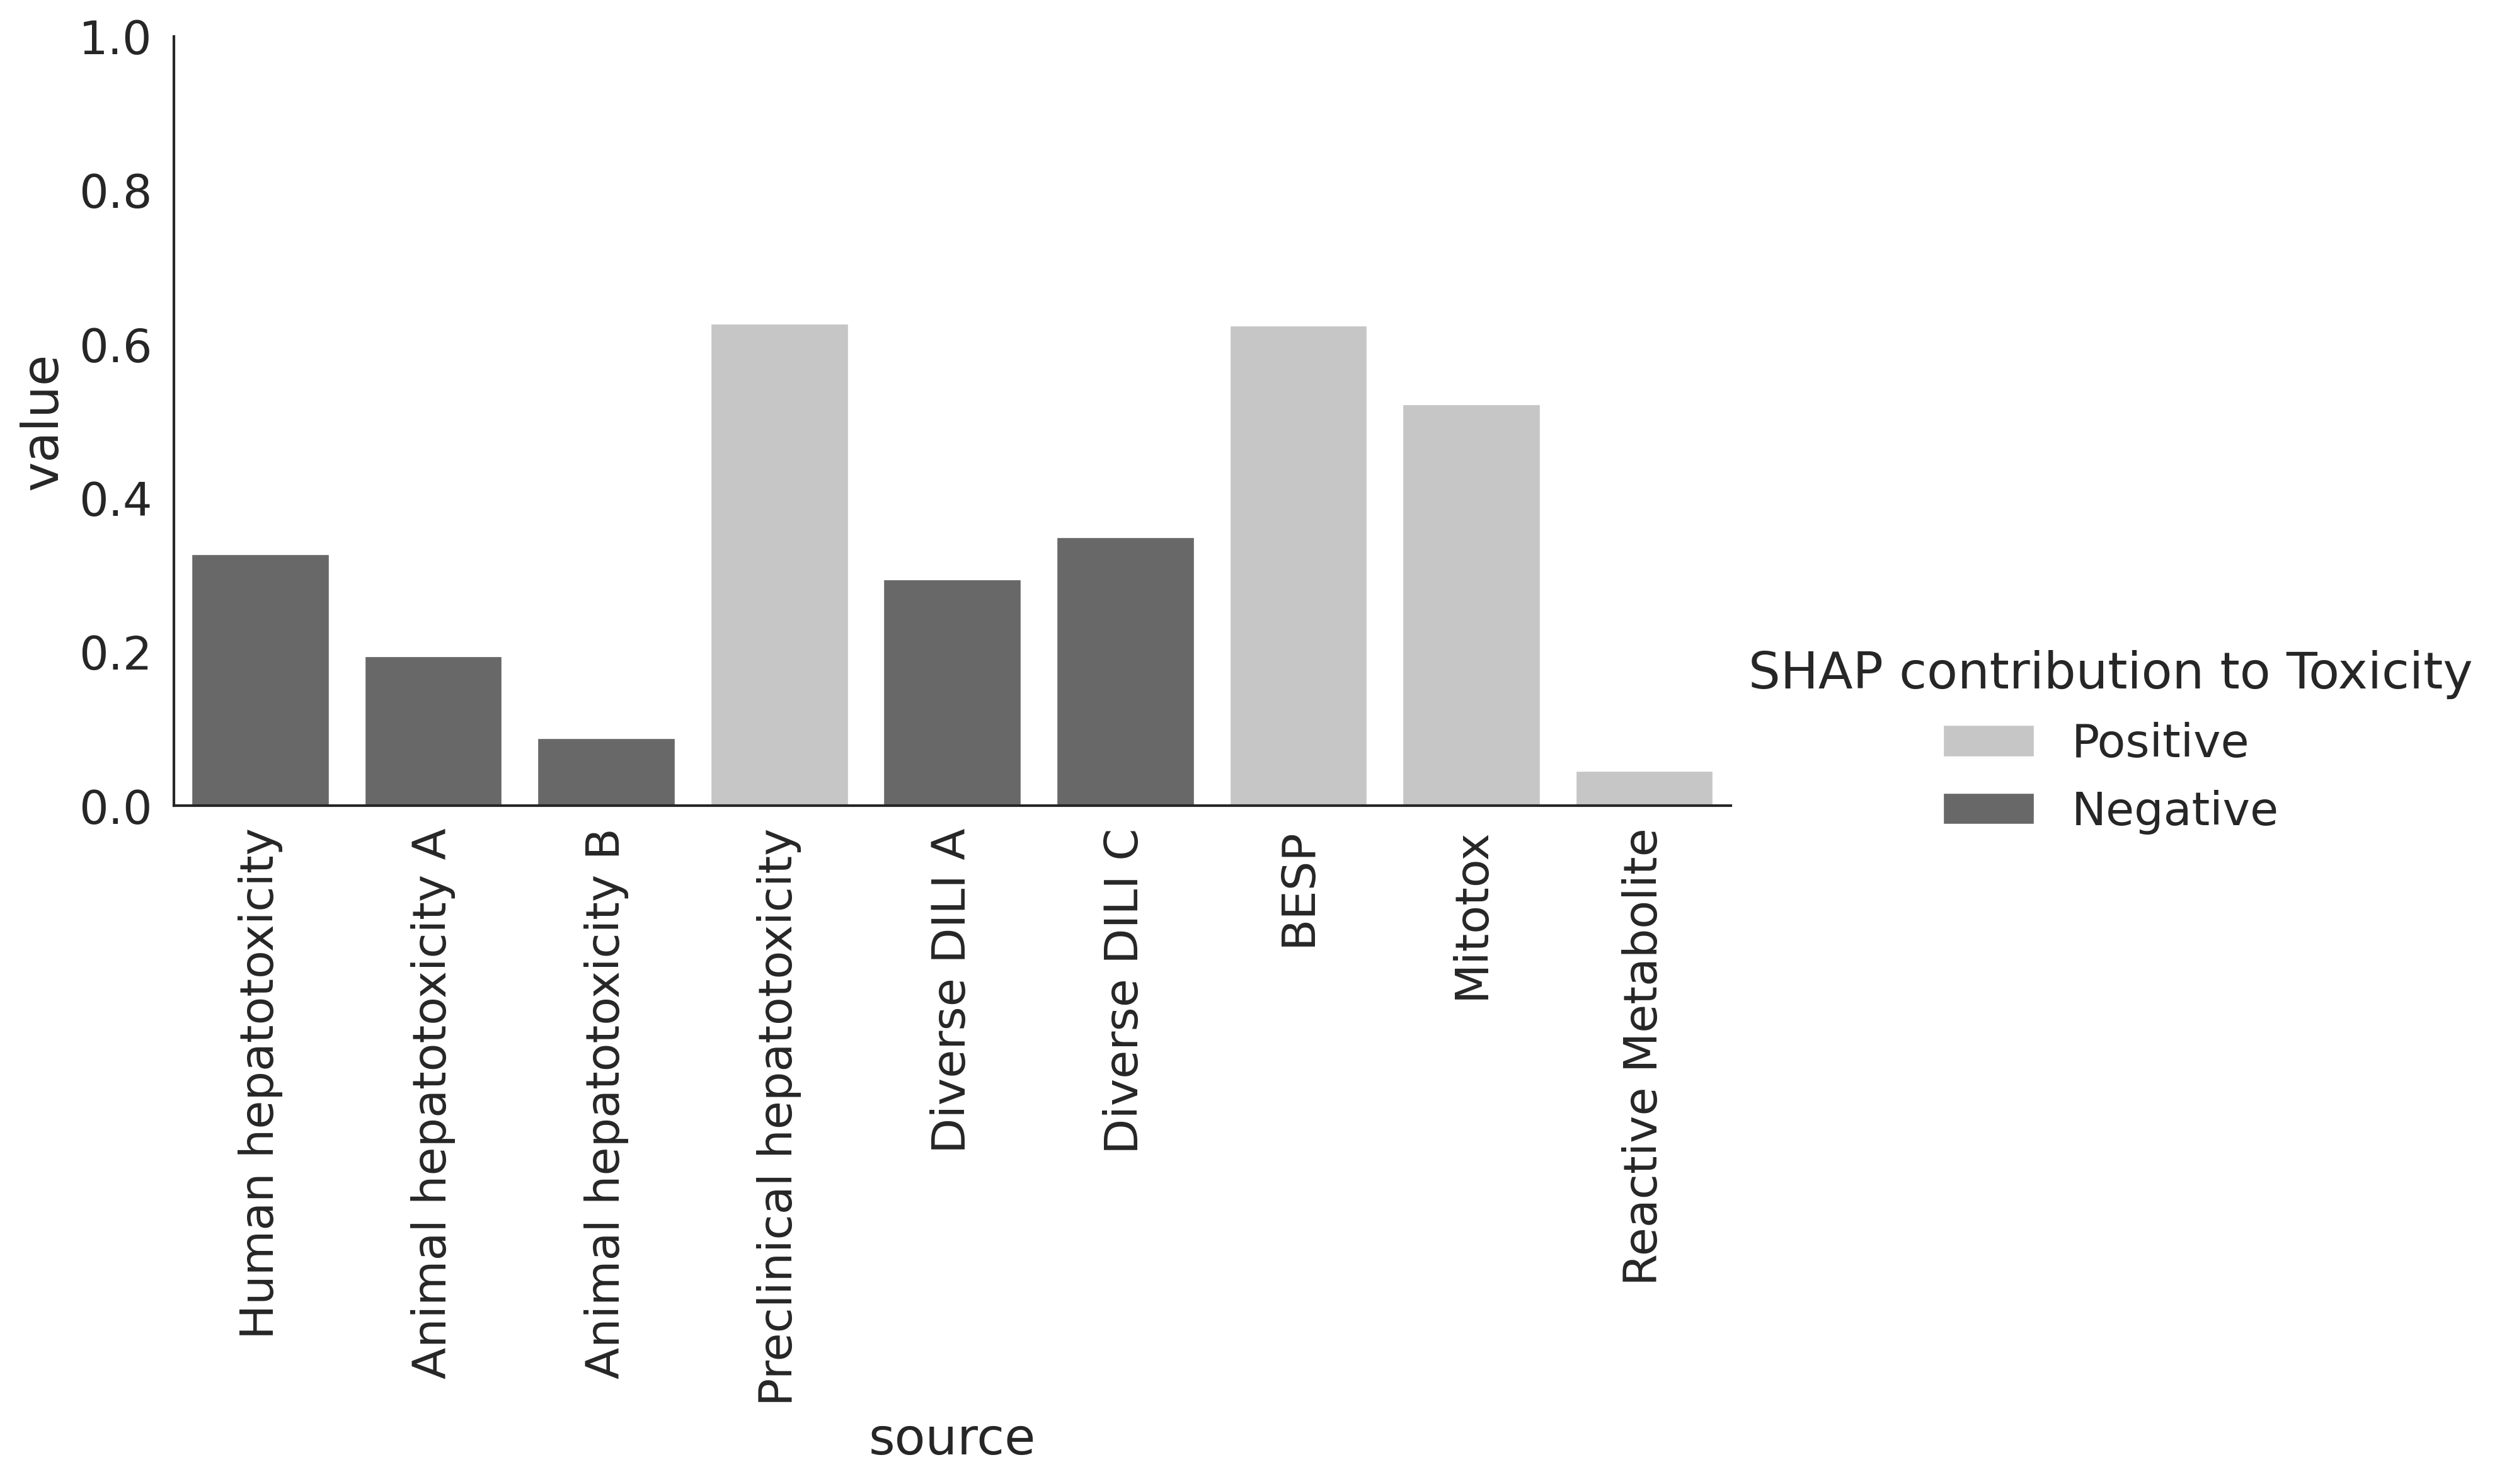

Doxycycline
9


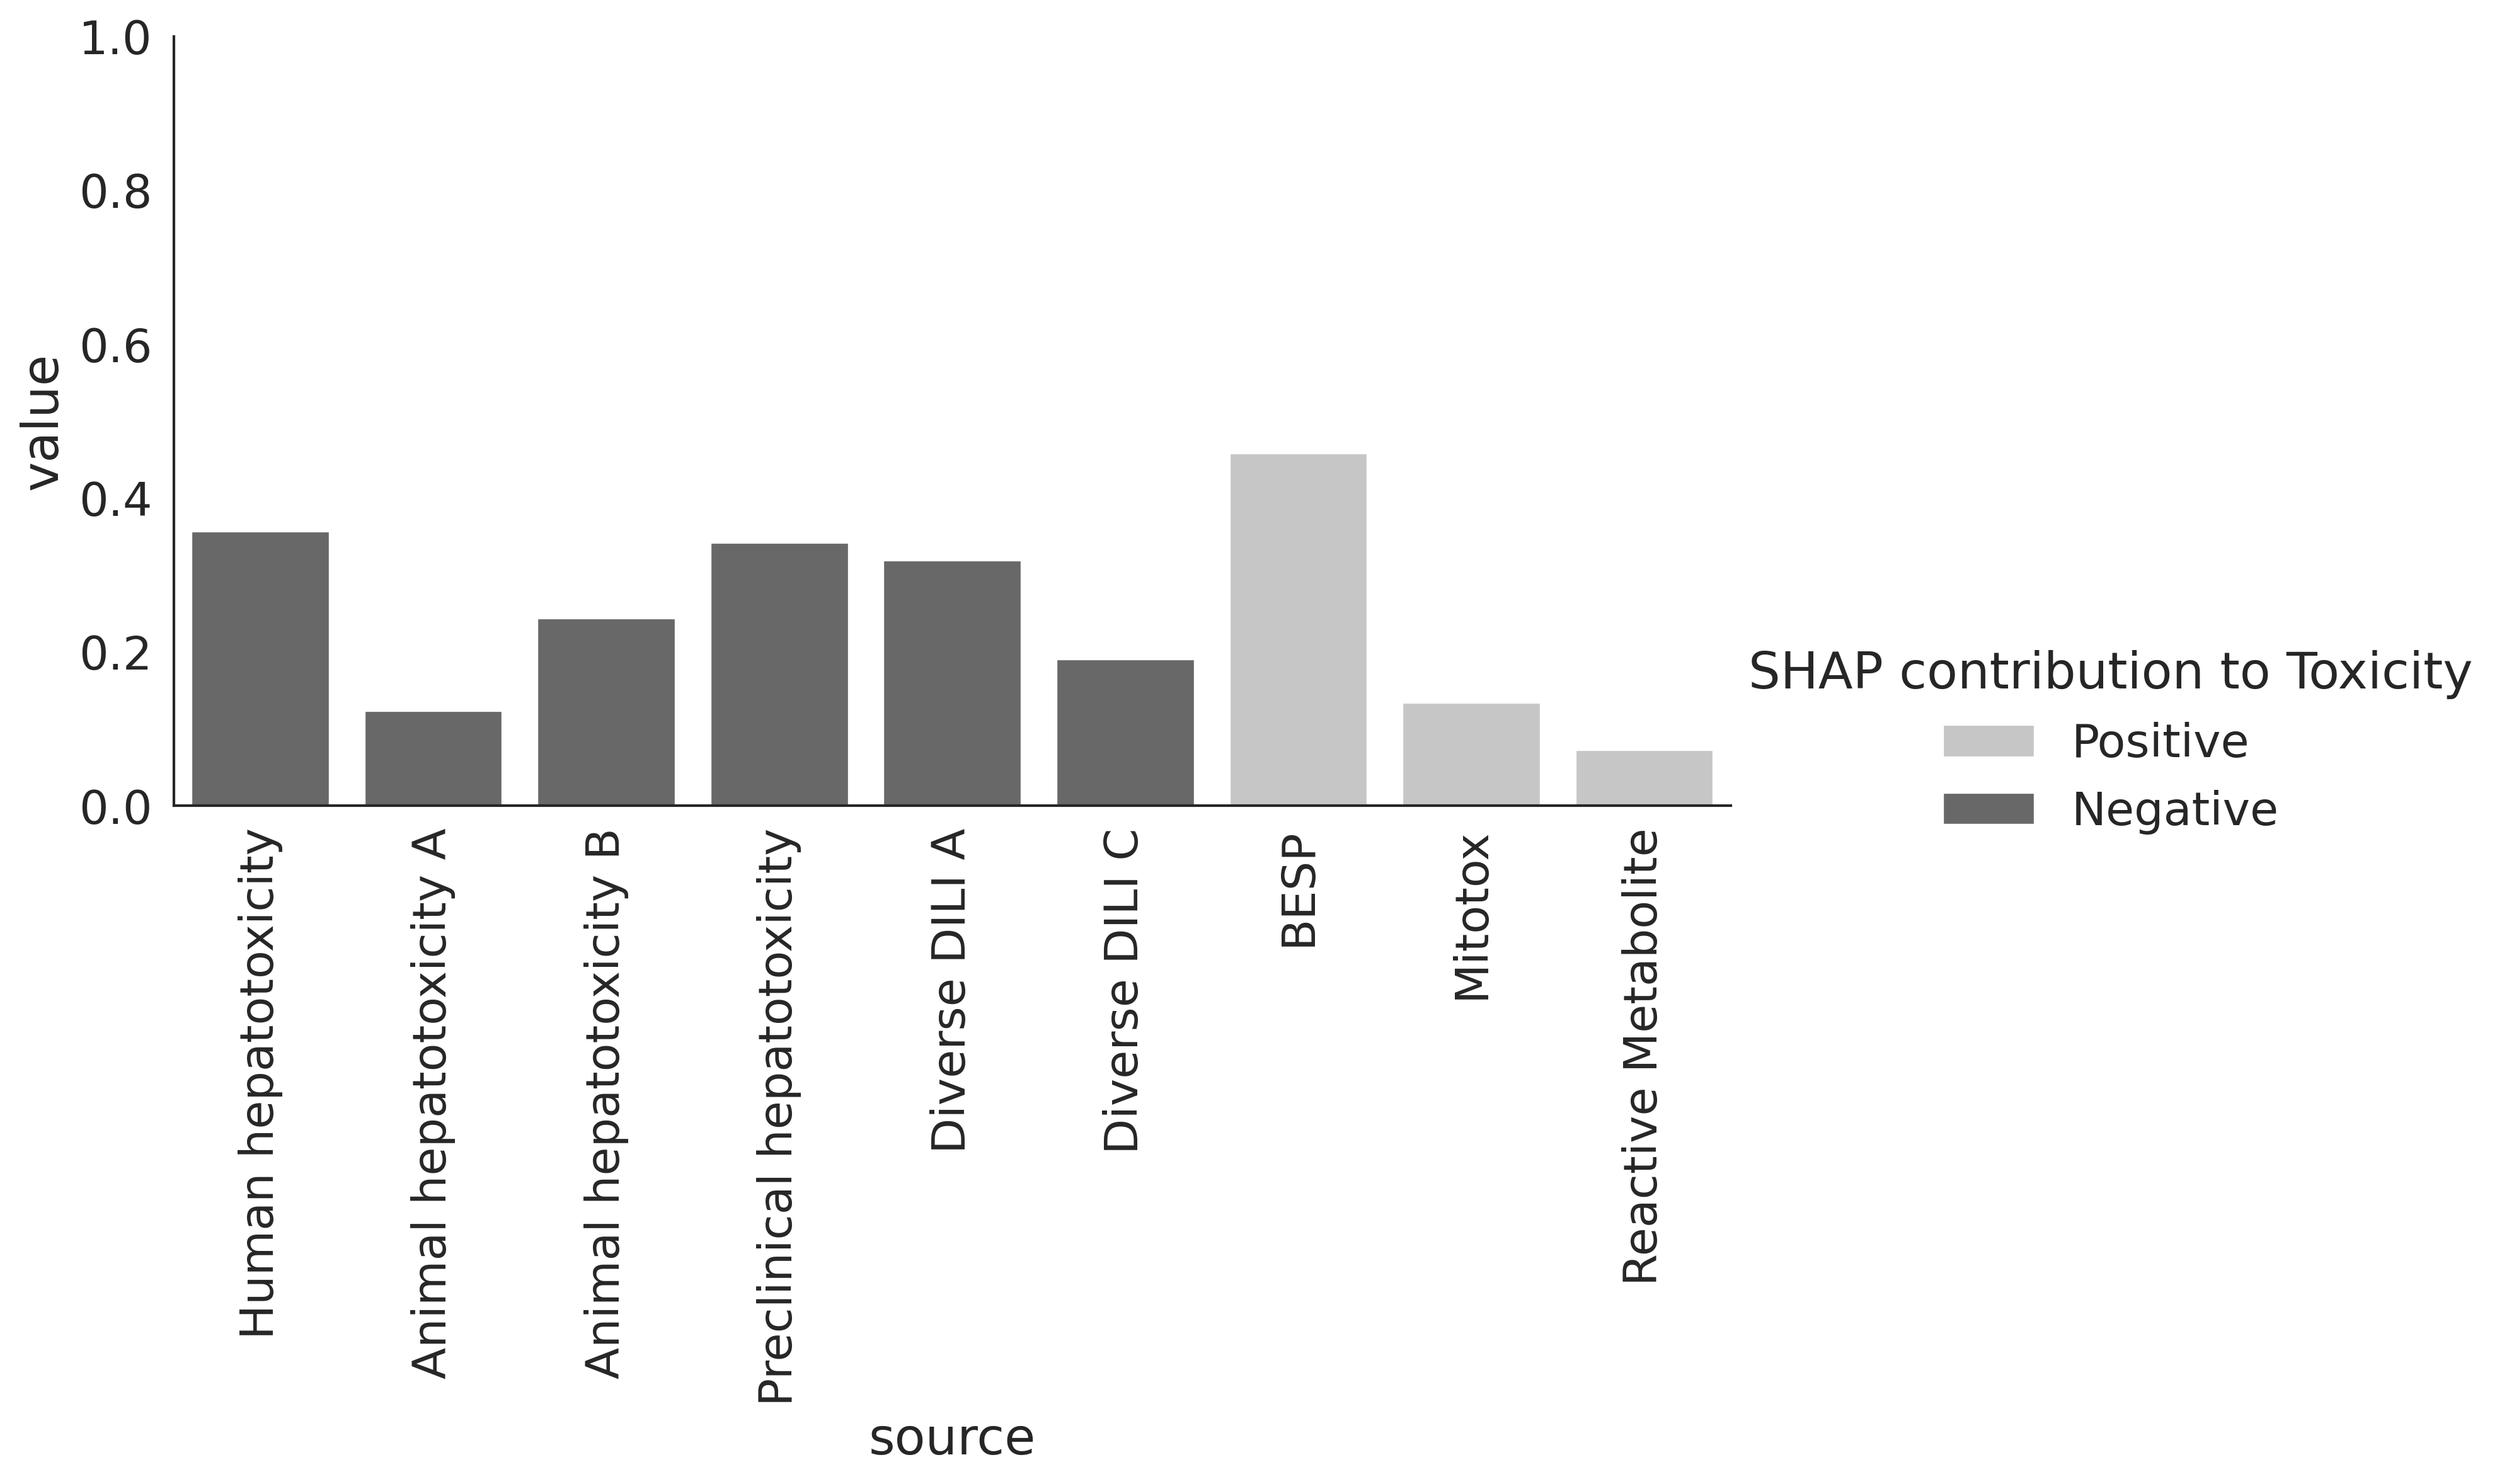

Entacapone
9


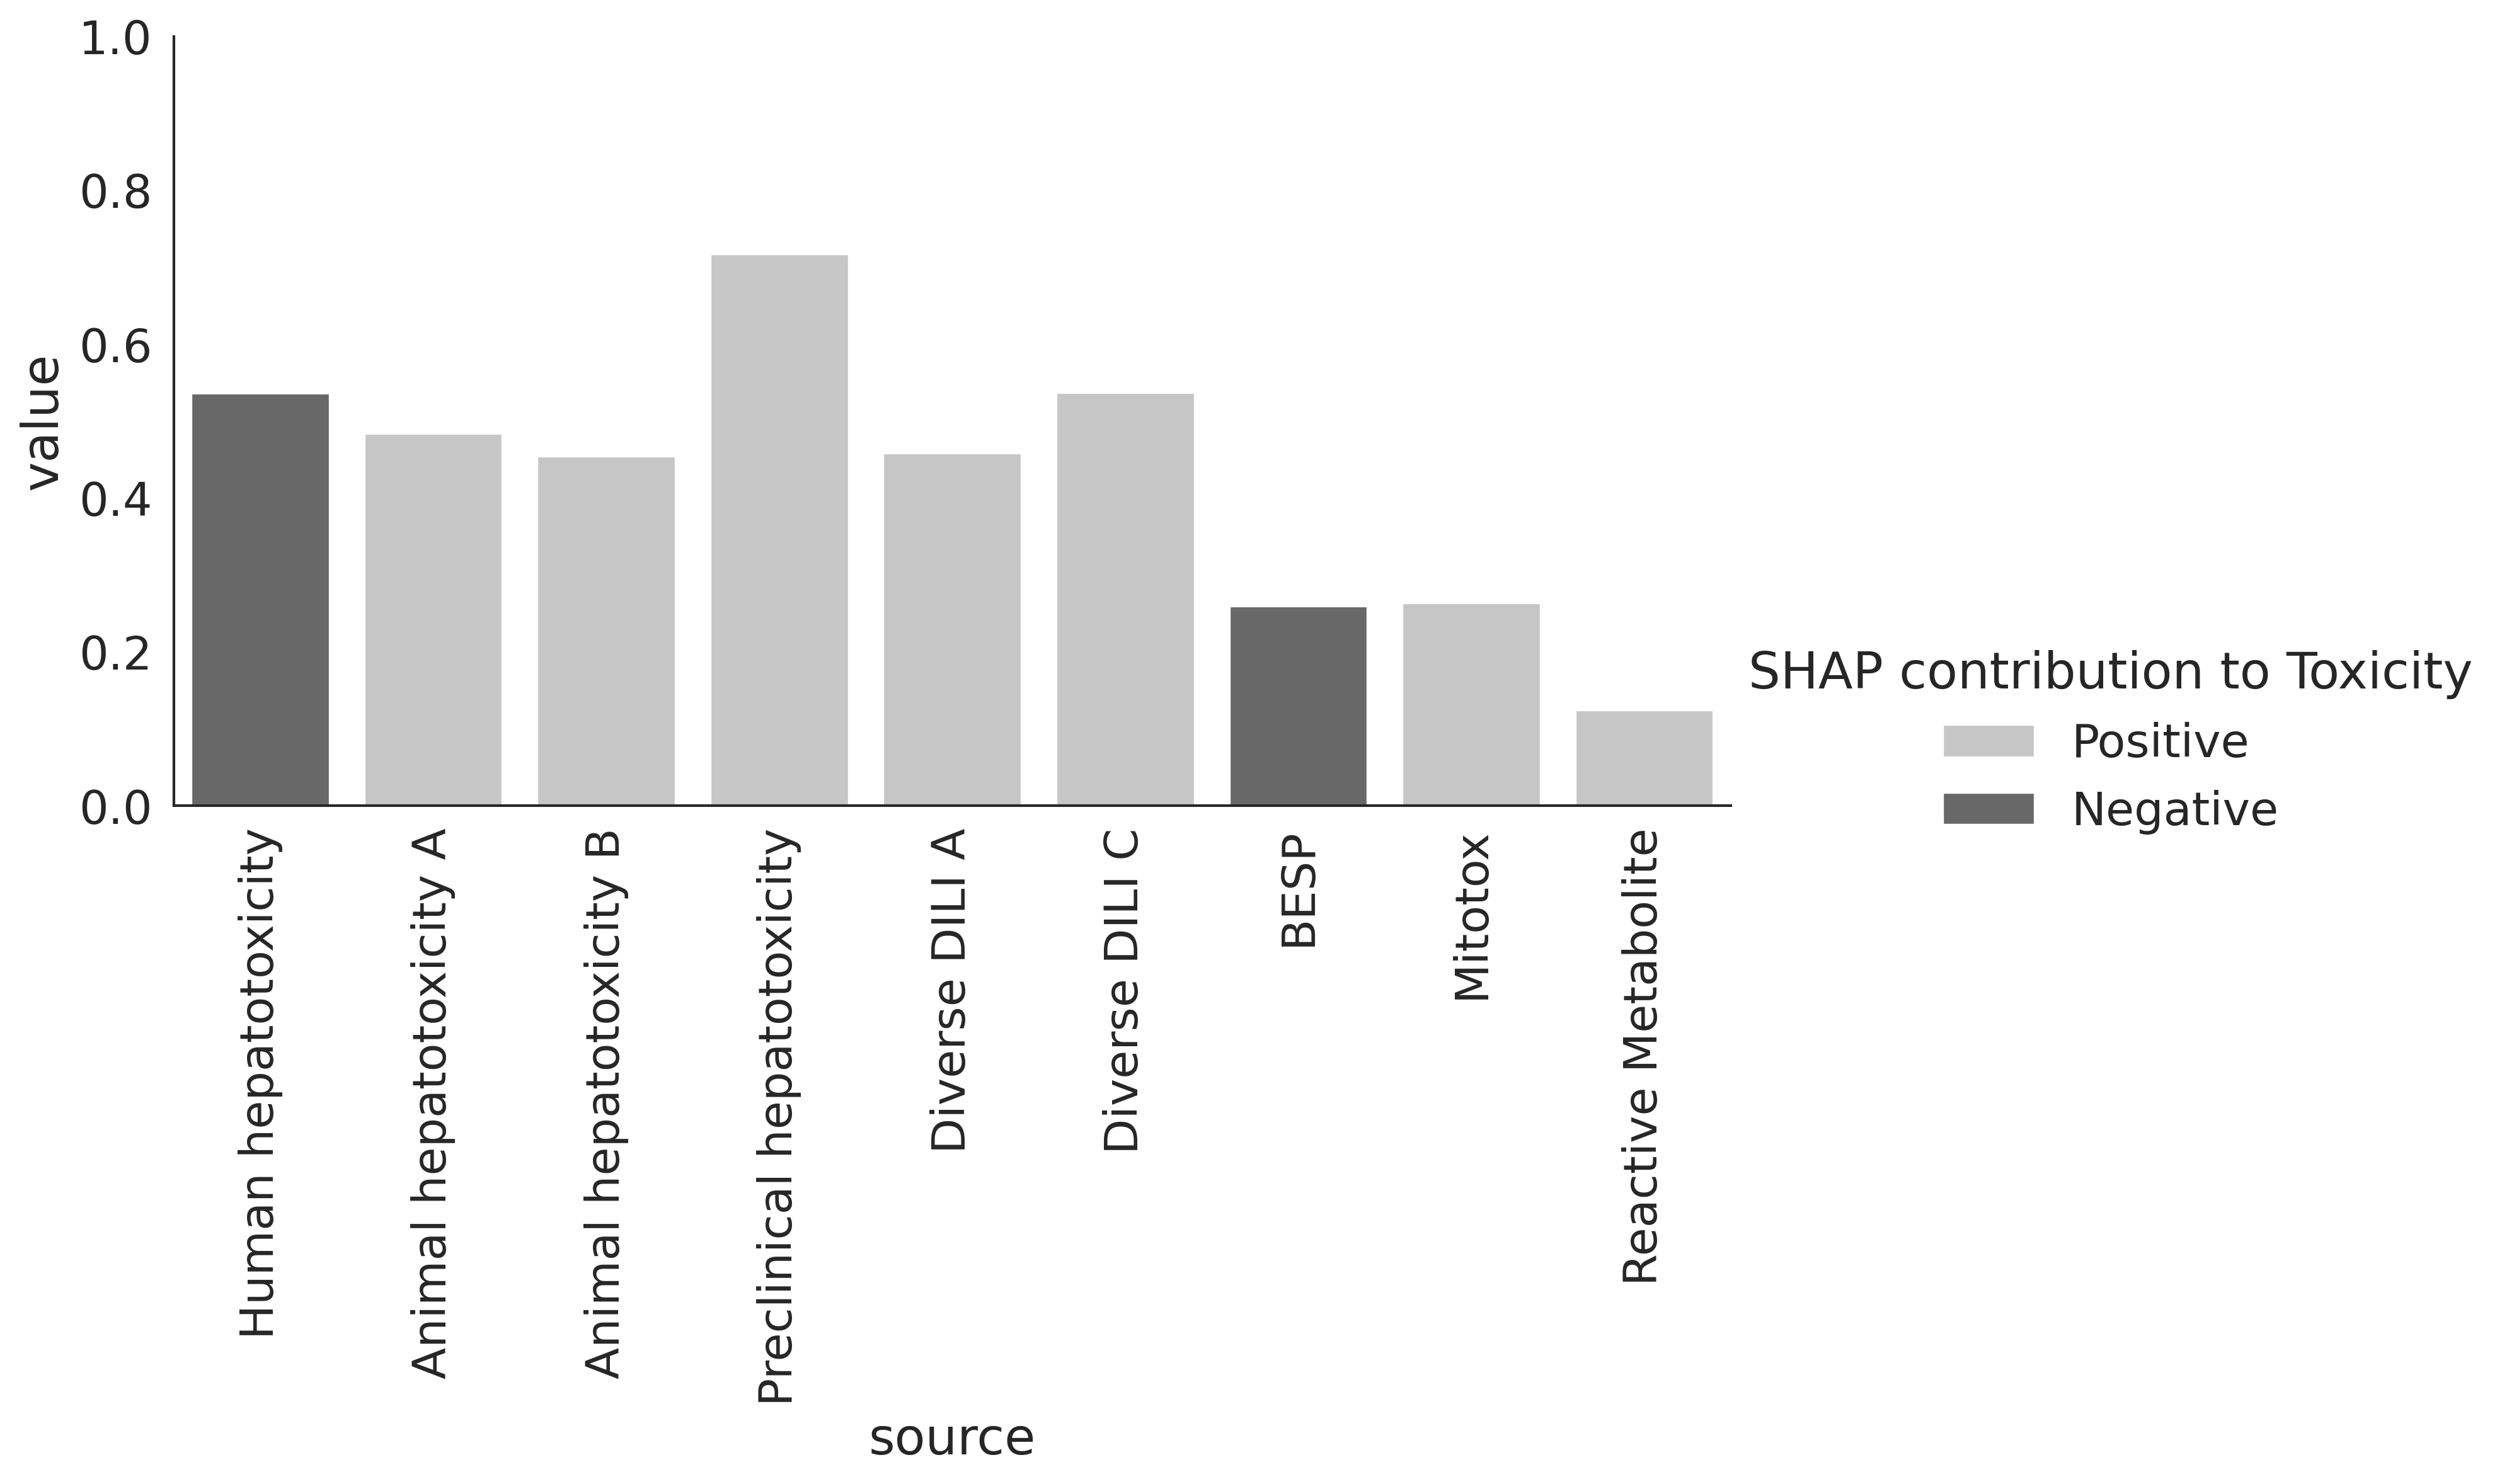

Gemcitabine
9


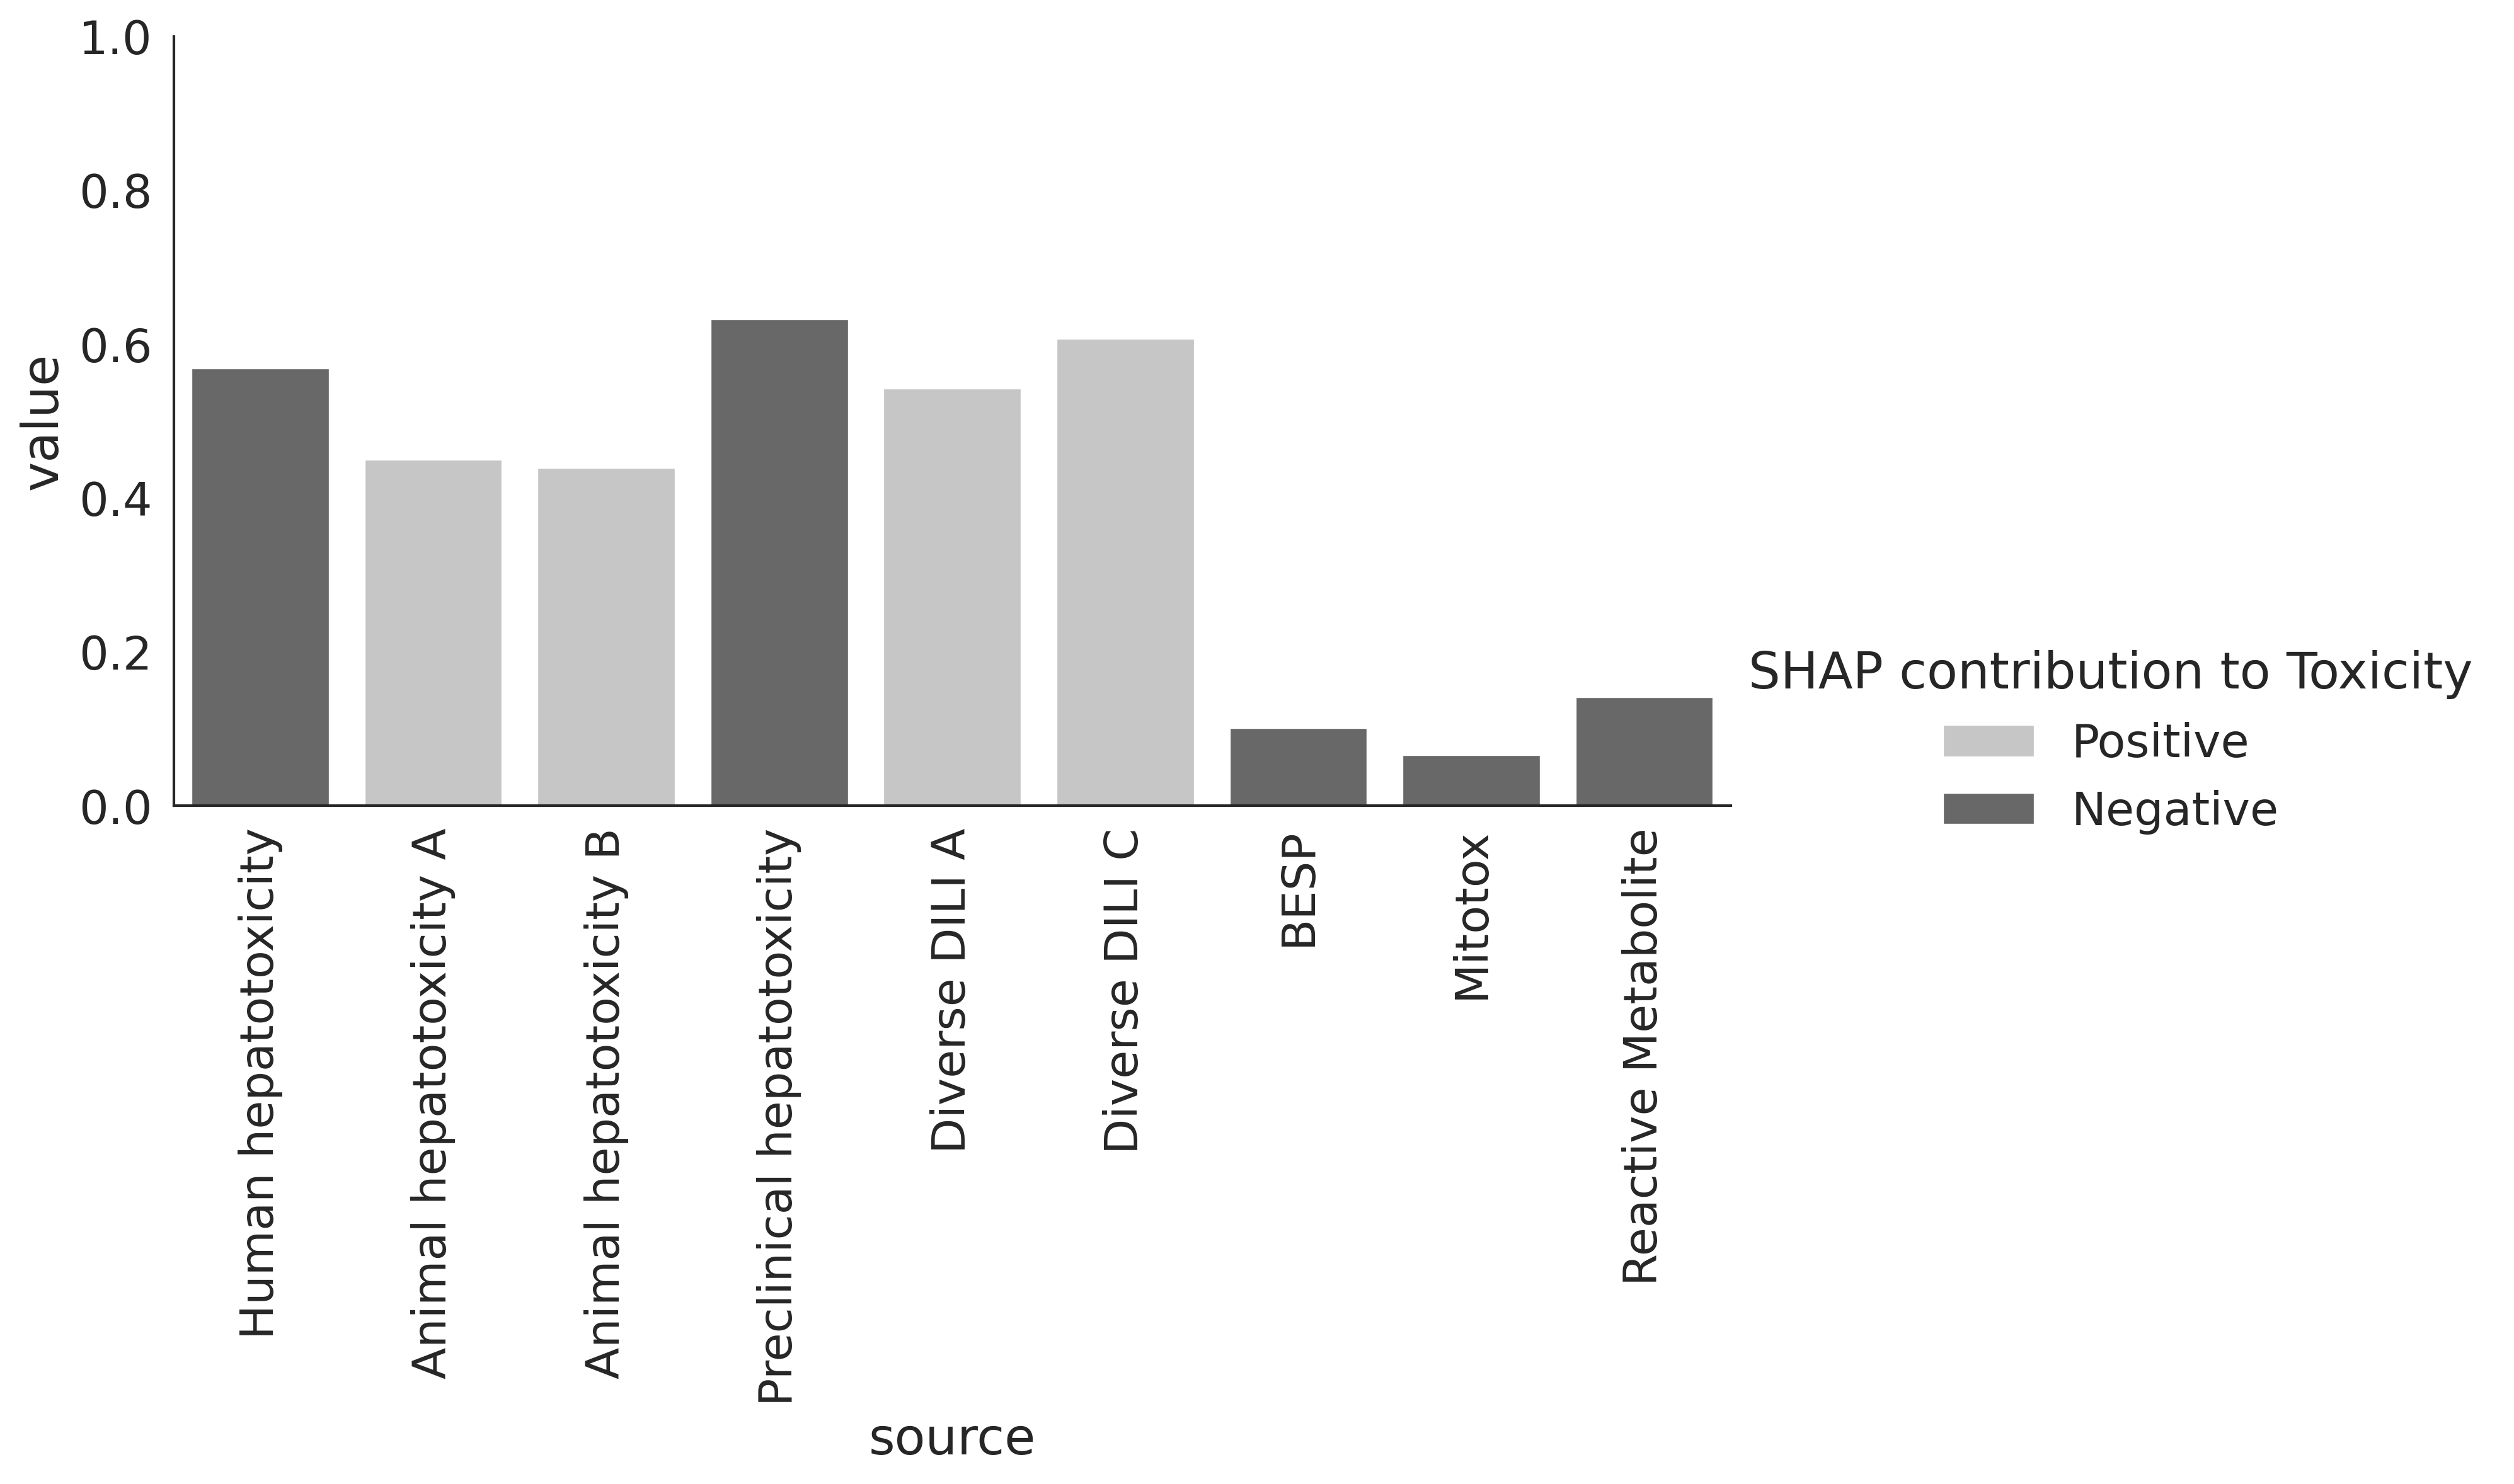

Minocycline
9


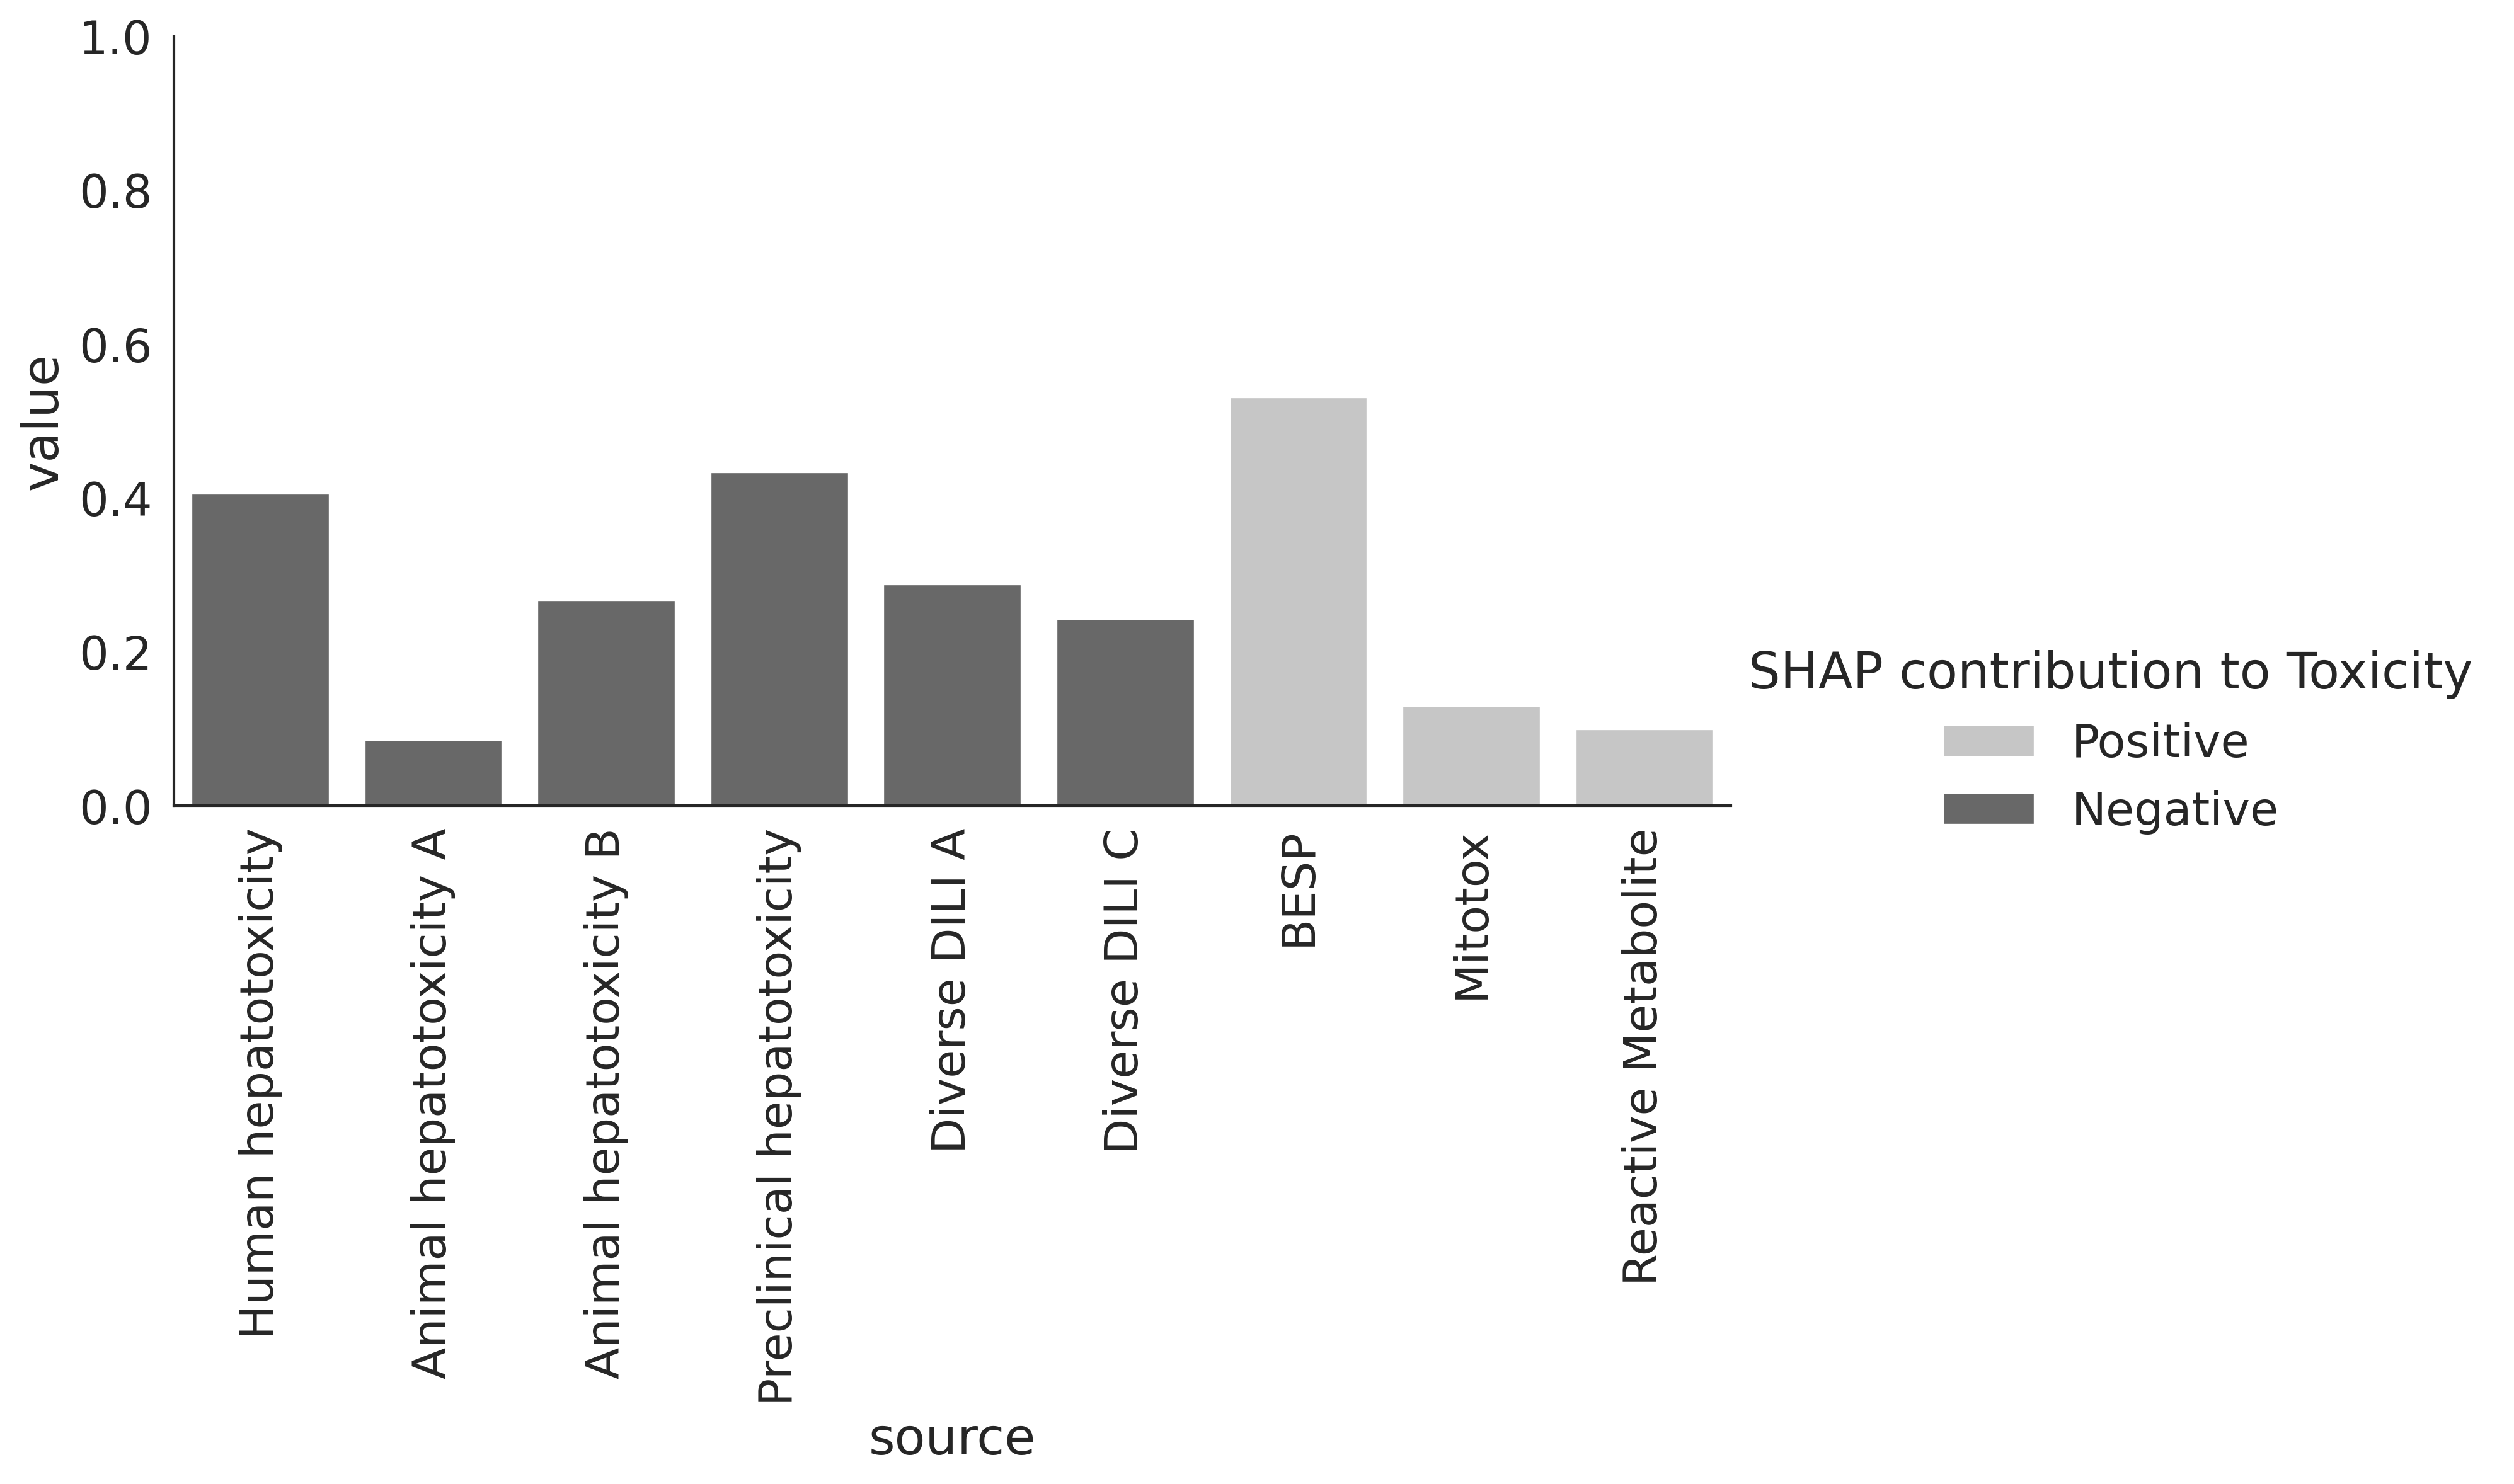

Moxifloxacin
9


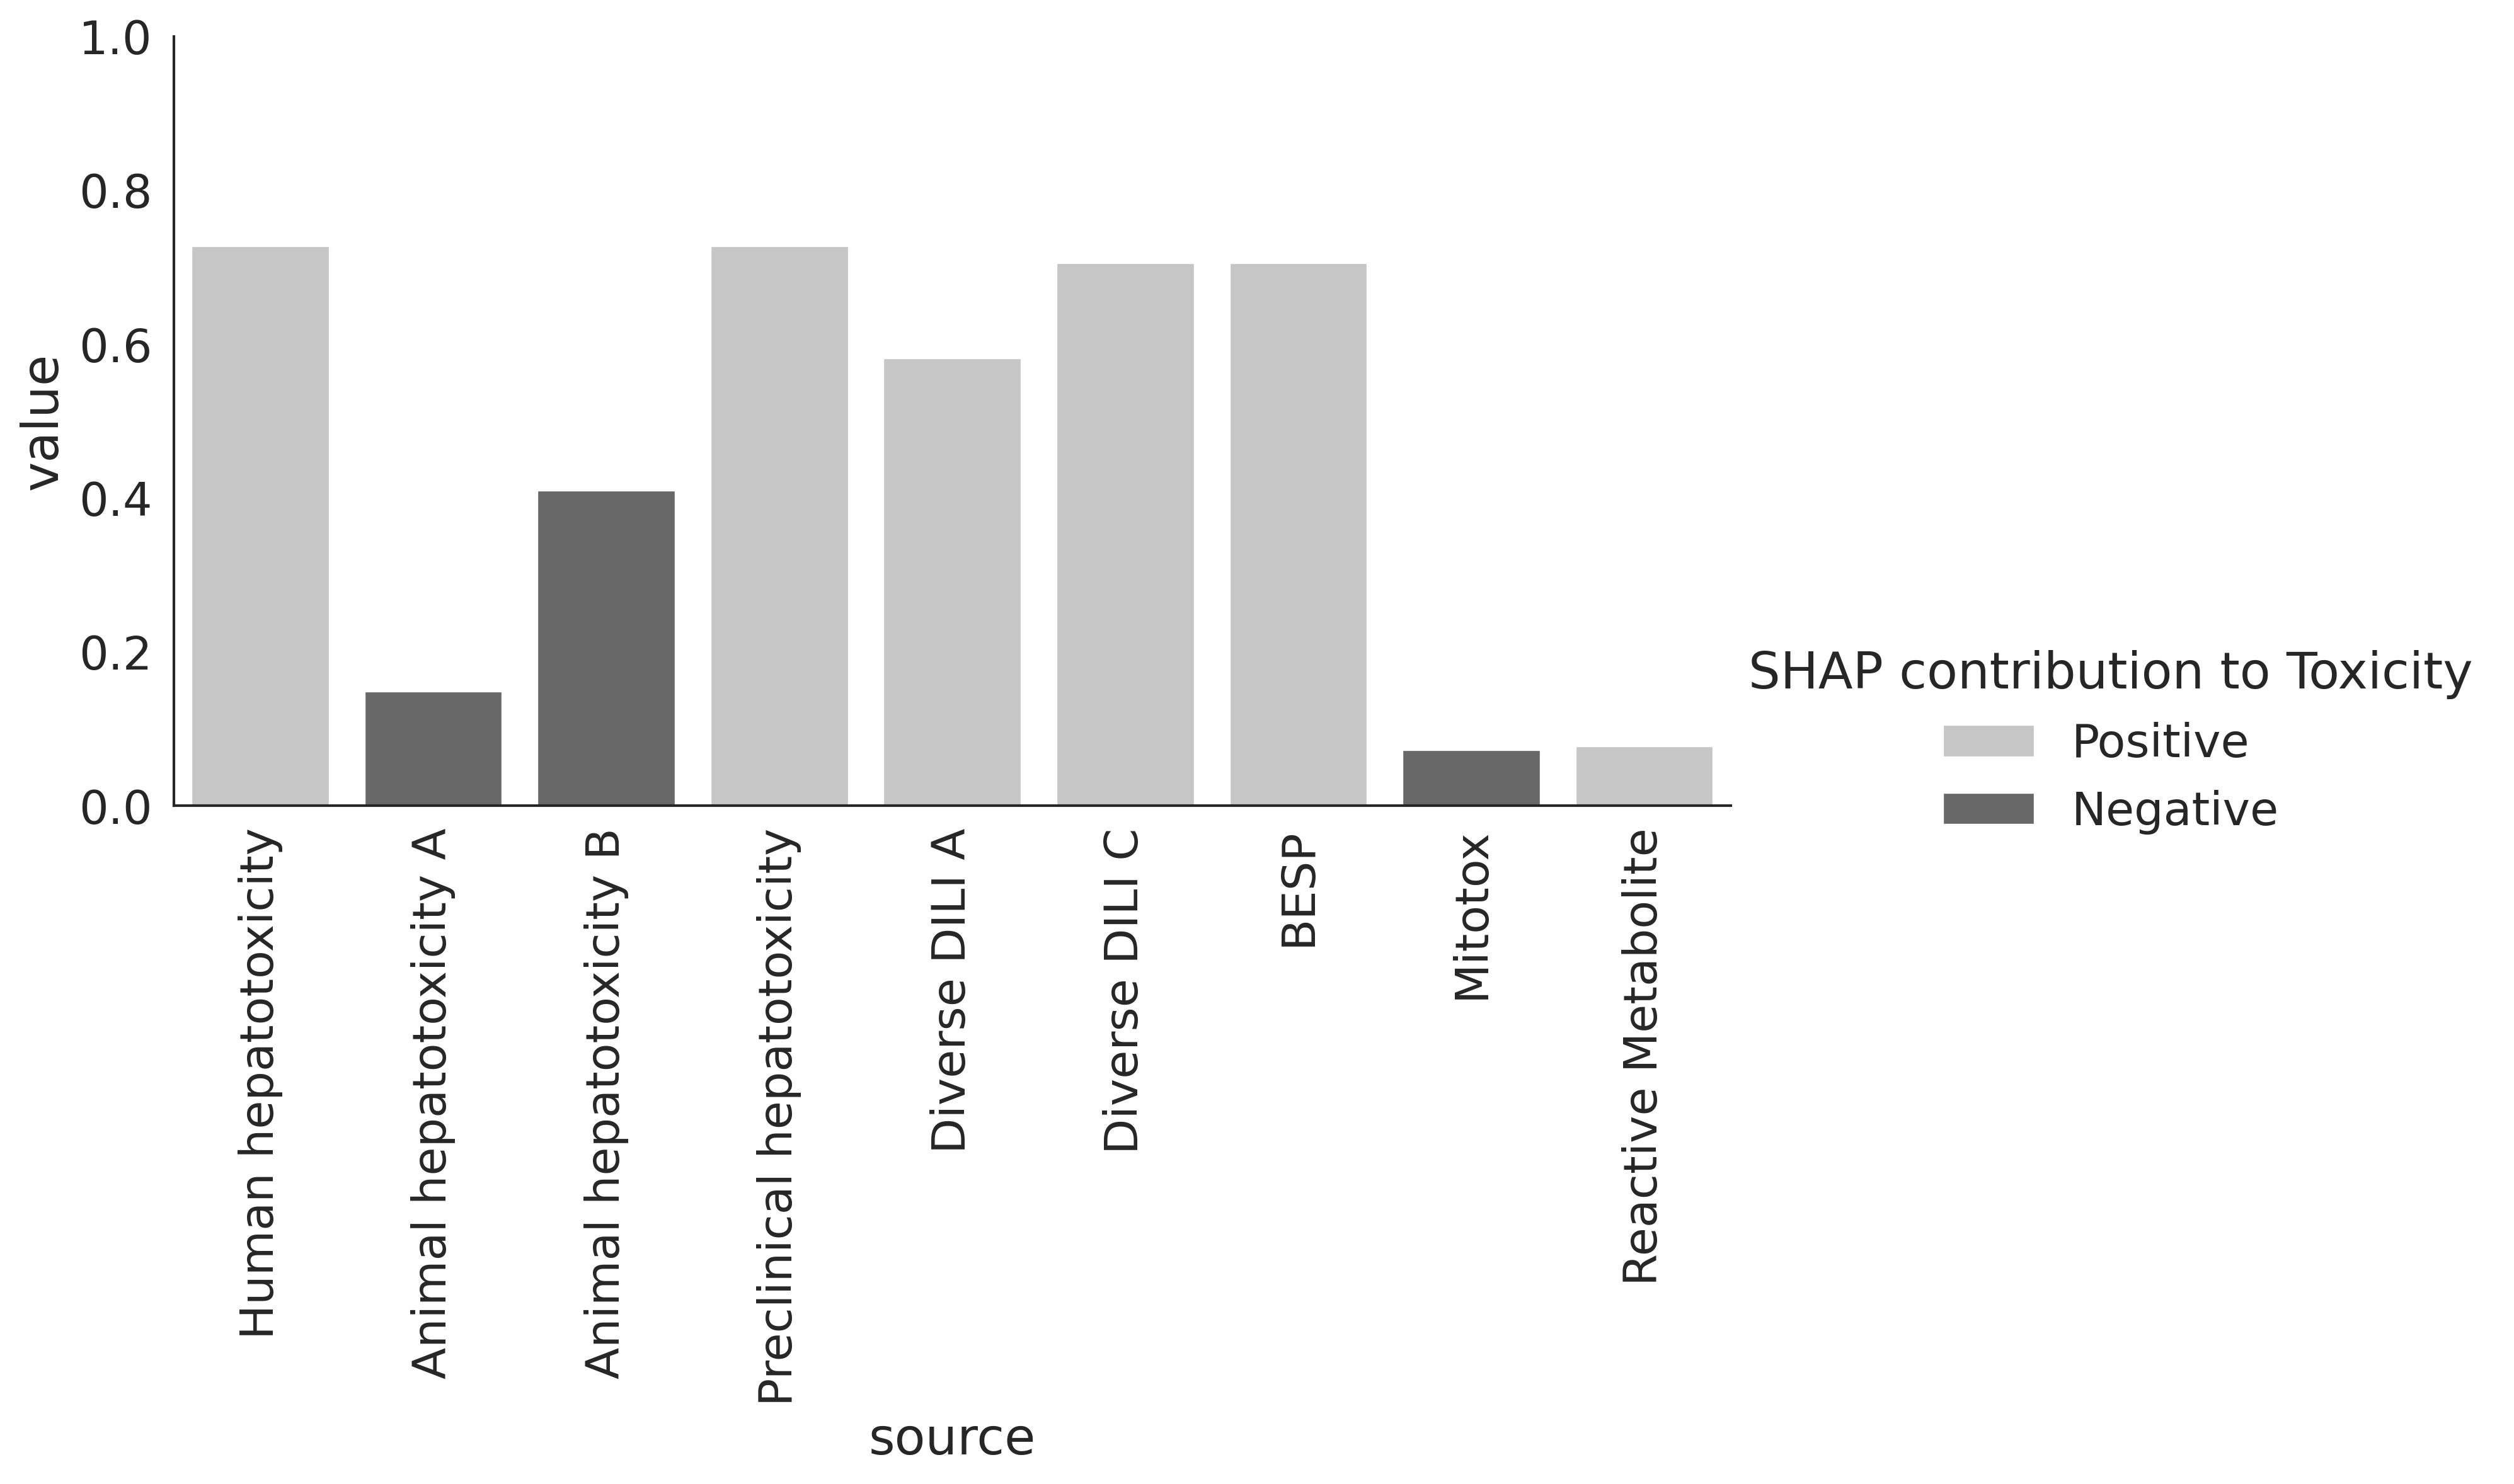

Paclitaxel
9


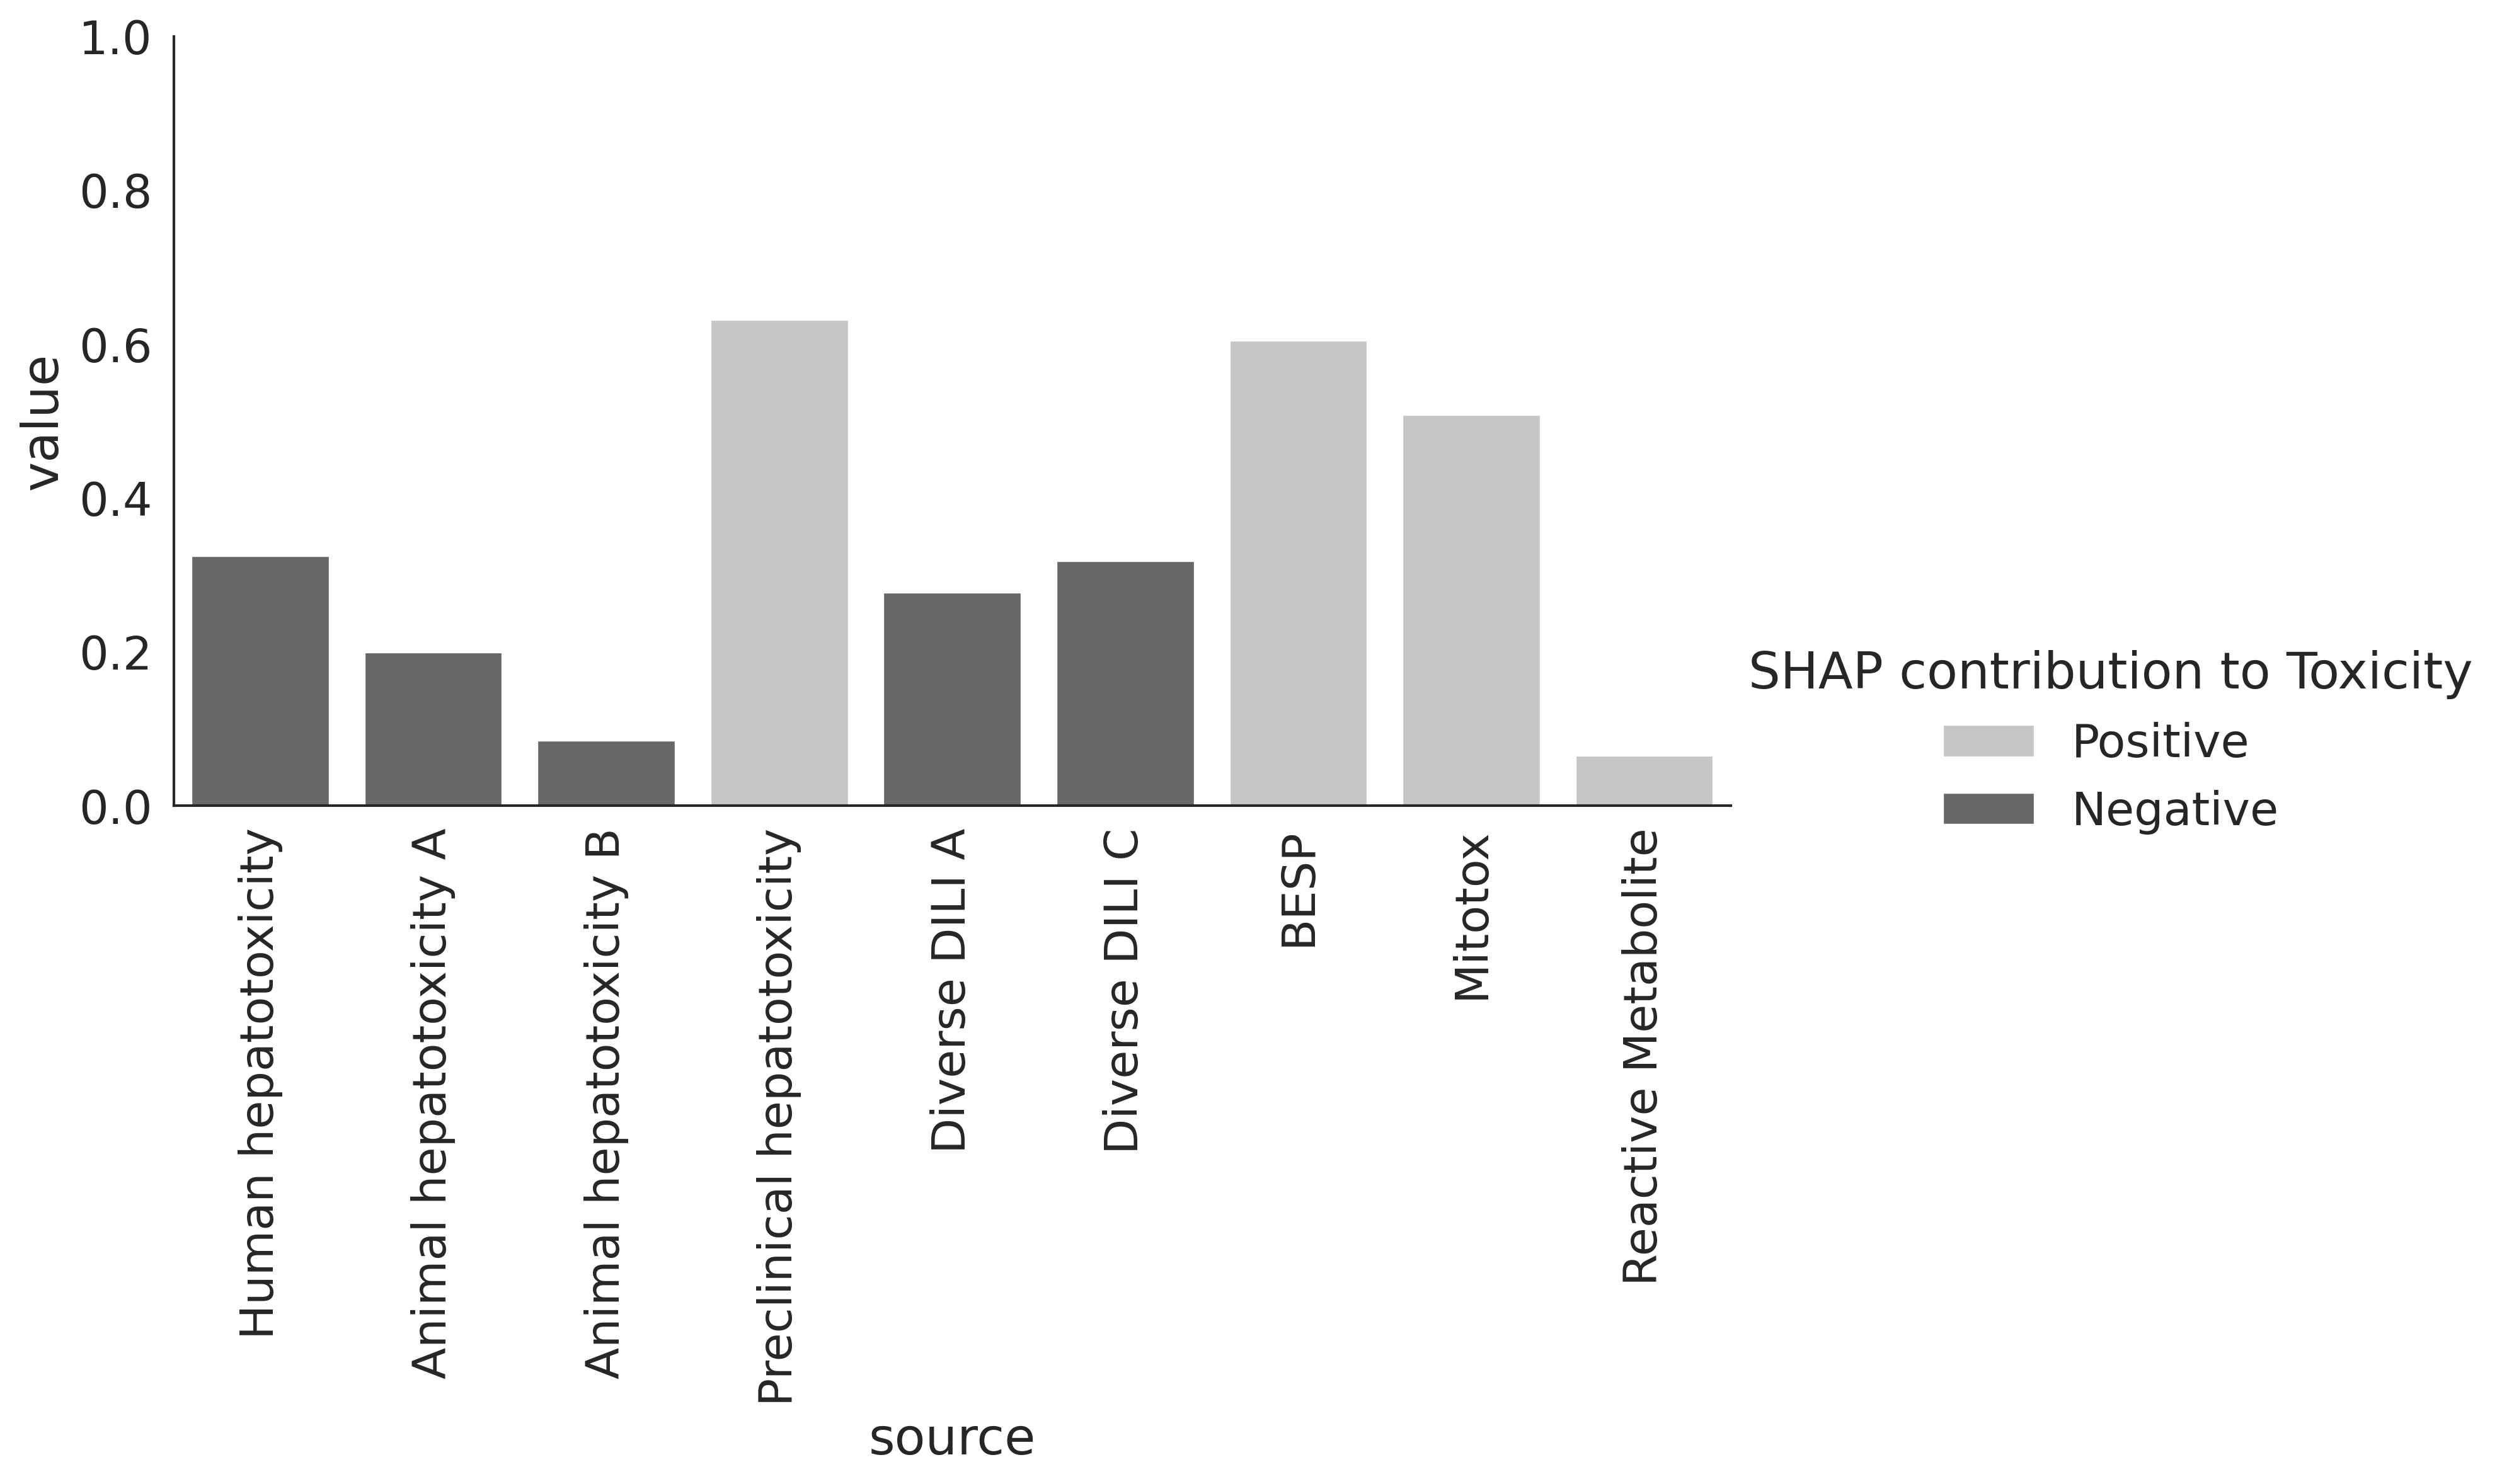

Trovafloxacin
9


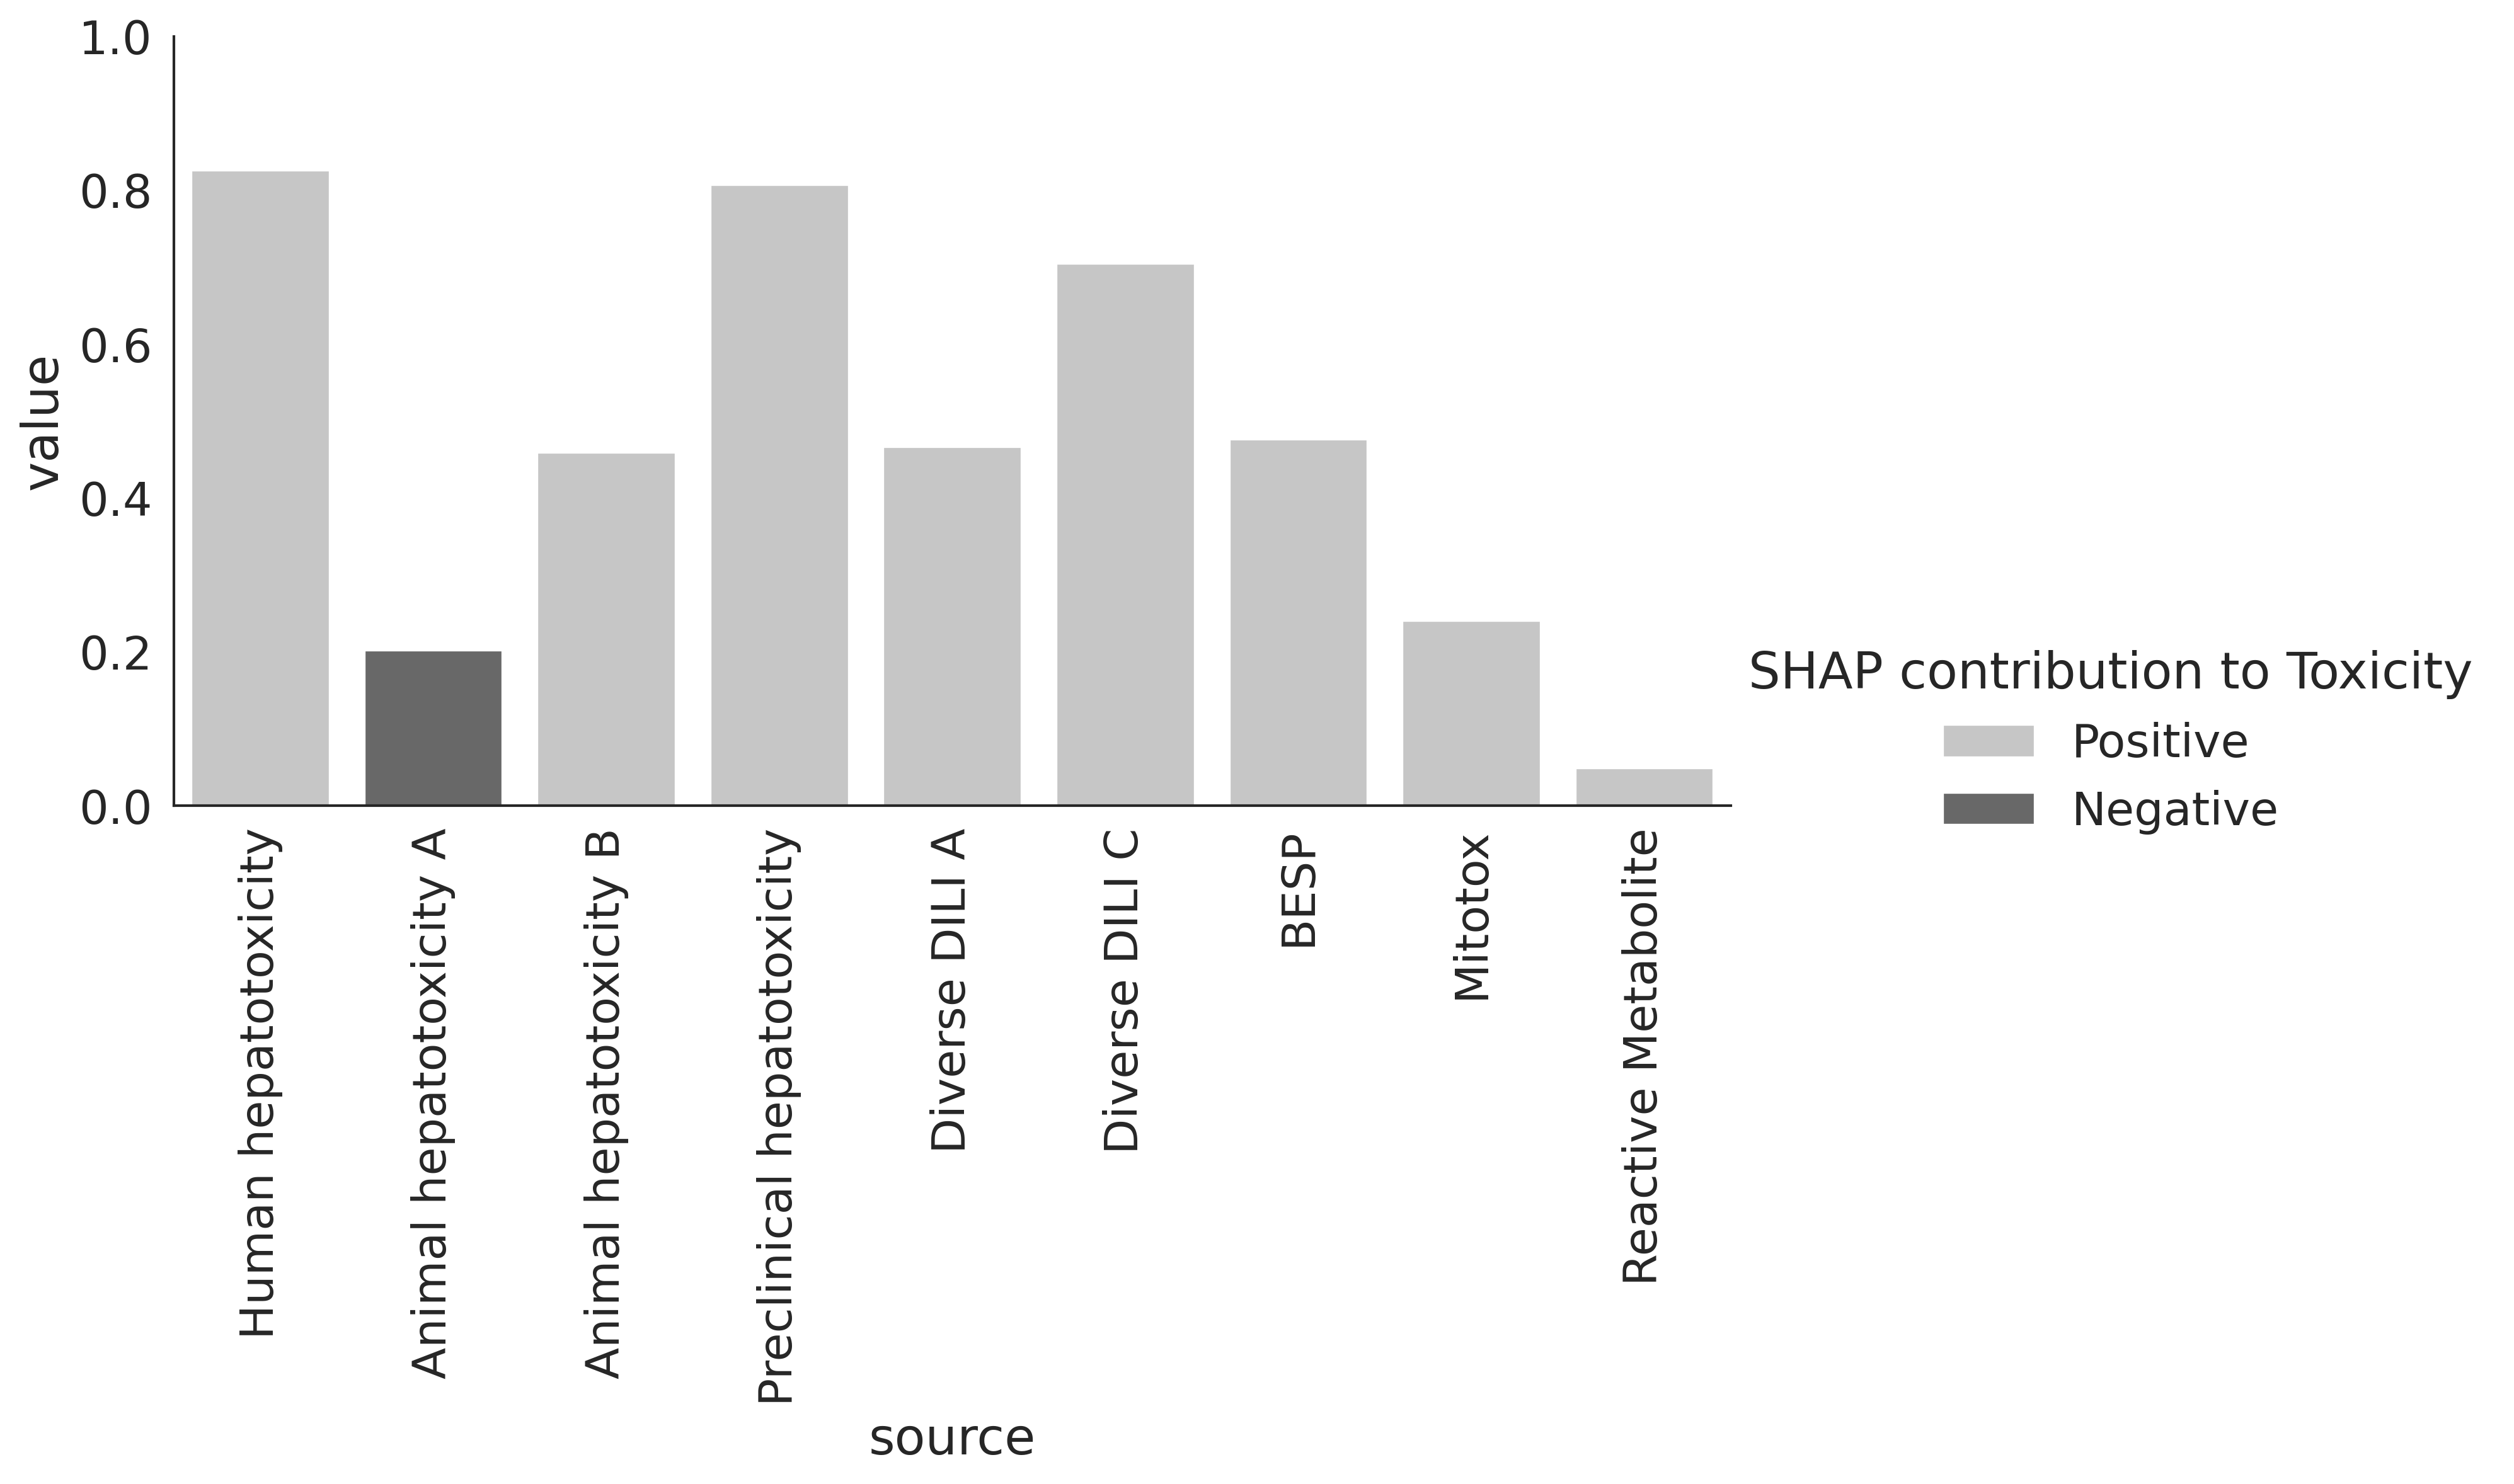

Ximelagatran
9


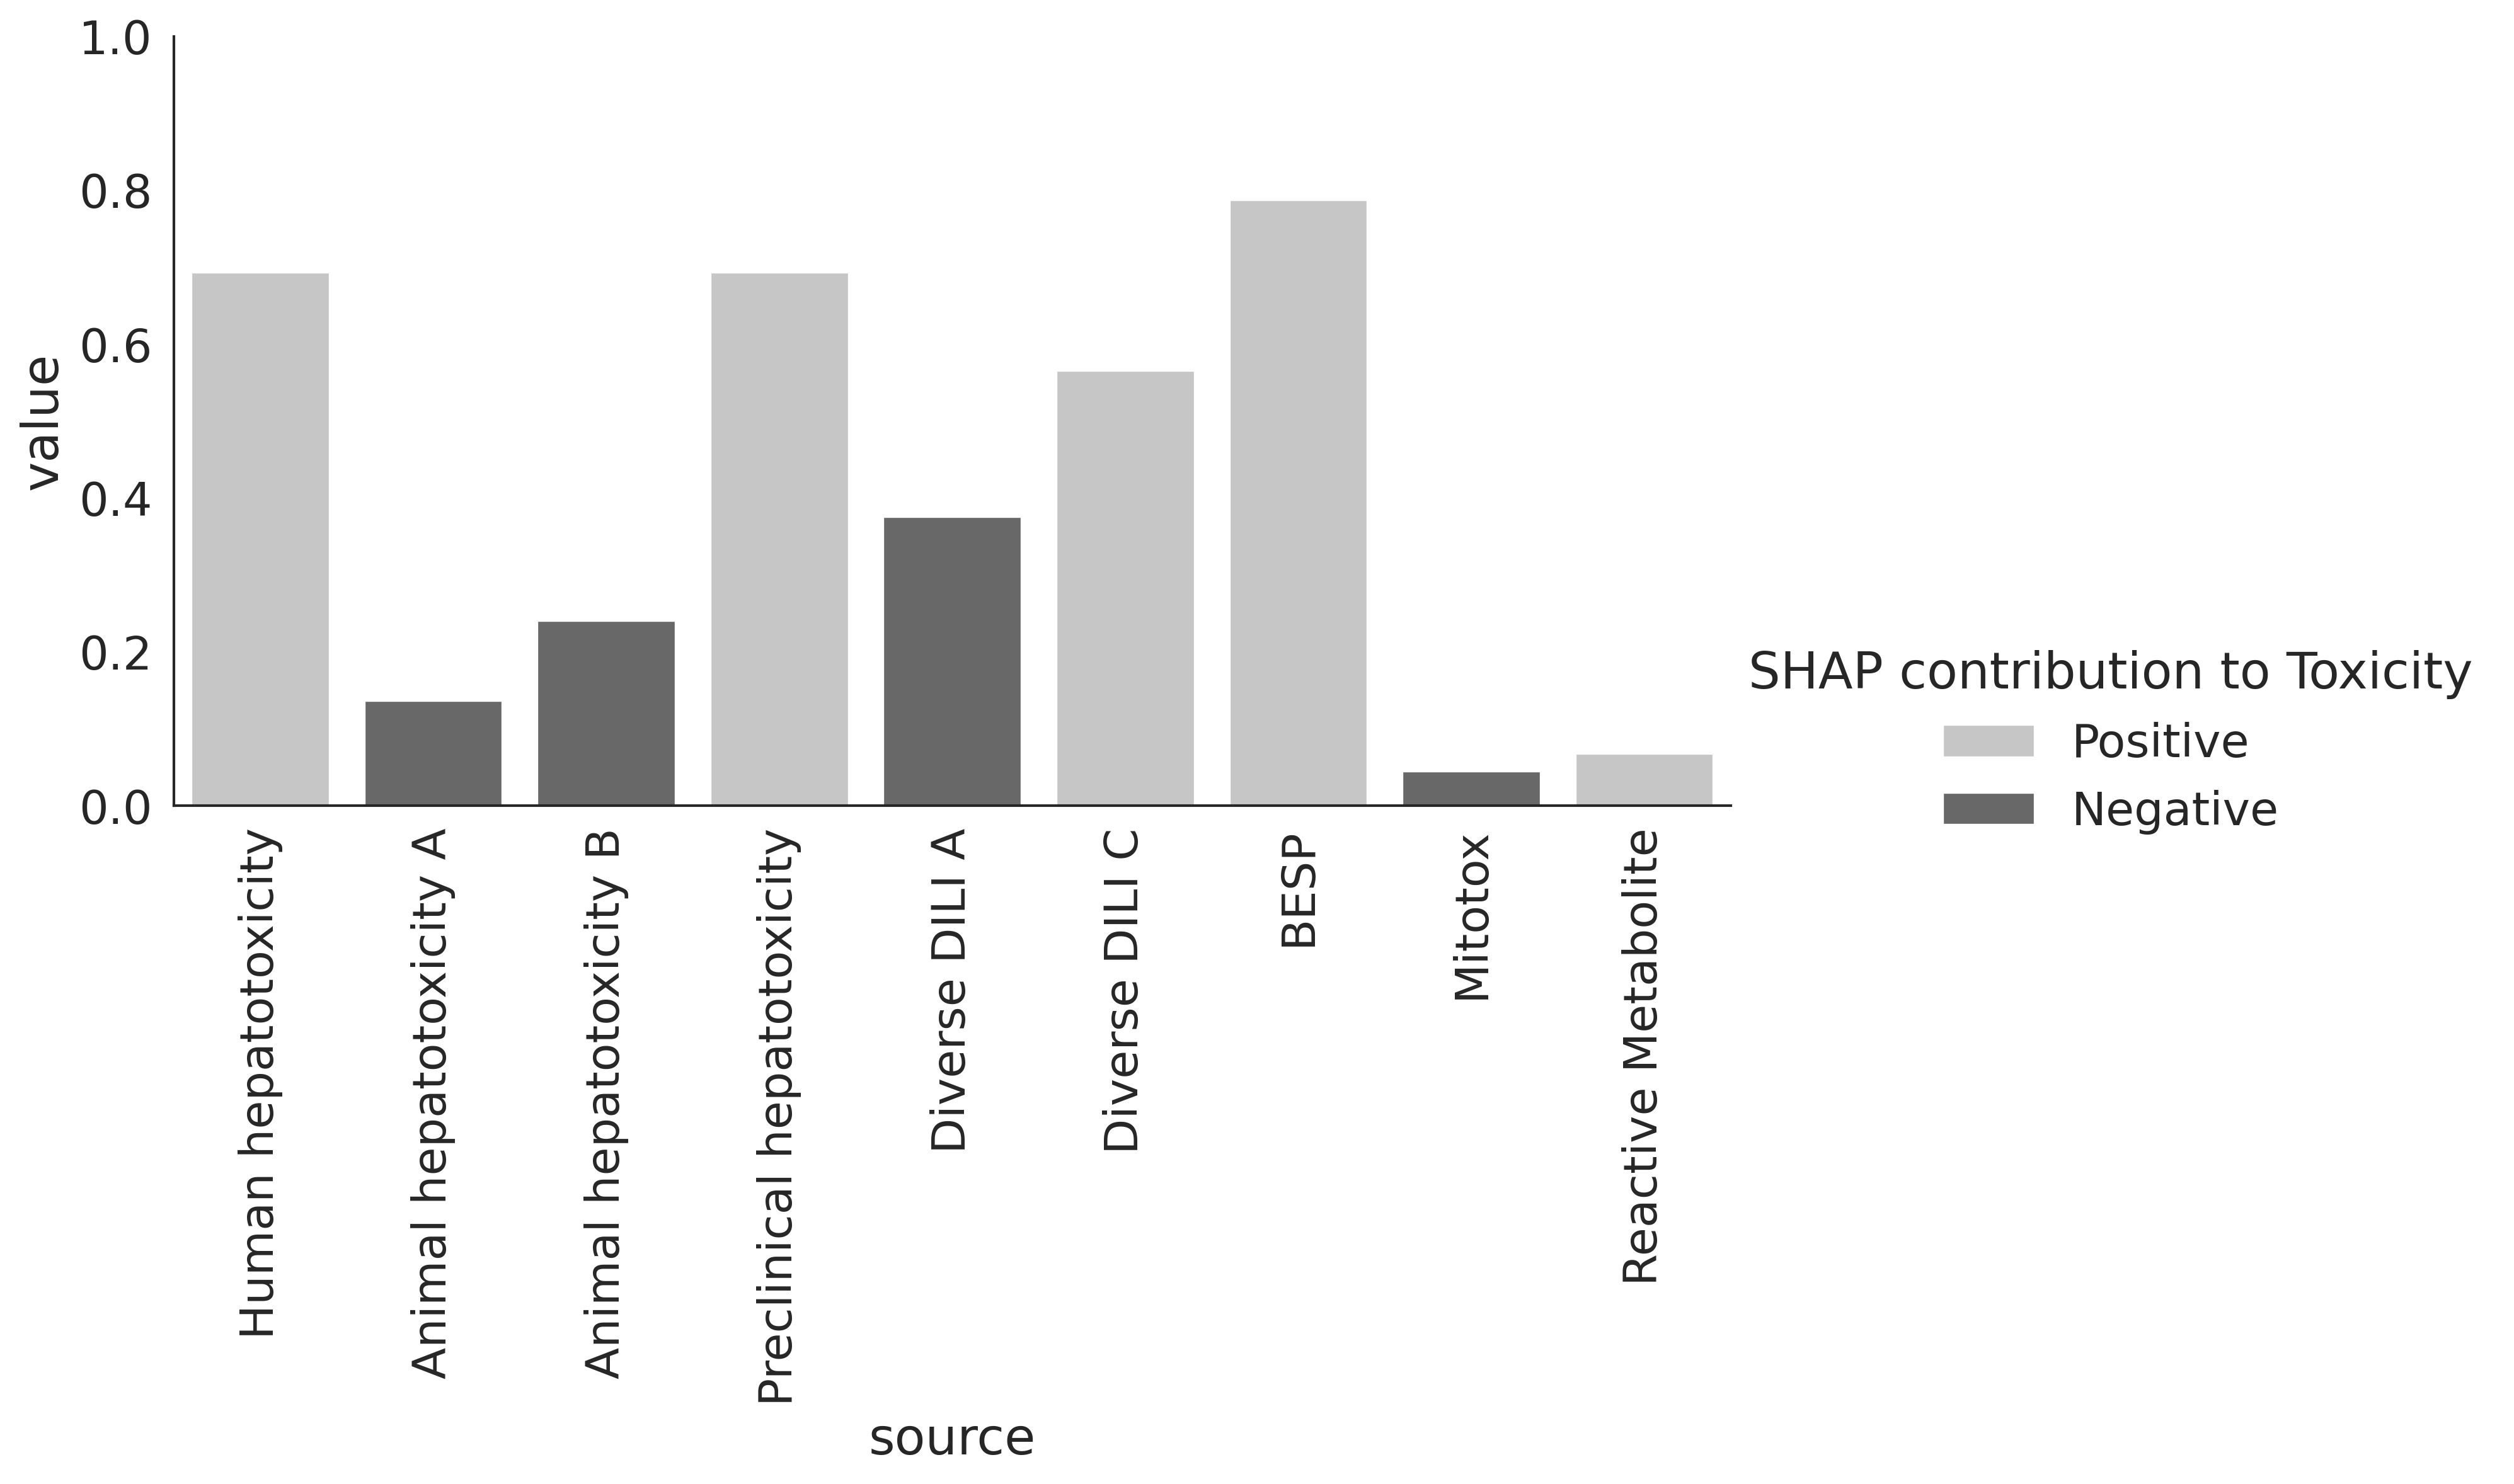

In [39]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

for compound_name in SHAP.compound.unique():
    print(compound_name)
    
    compound = SHAP[SHAP["compound"]==compound_name].sort_values(by=["name"], ascending=True)
    print(len(compound))
    

    #fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
    sns.set_style('white')
    sns.set_context('paper', font_scale=2)
    hue_order = ['Positive', 'Negative']
    #sns.barplot(data=compound, x="source", y="value", color='grey')
    g = sns.catplot(data=compound, x="source", y="value", kind="bar",hue_order=hue_order,  hue="SHAP contribution to Toxicity",  
                    palette="Greys", 
                    height=5, aspect=2, dodge=False)
    #plt.axhline(y=0.5, color='r', linestyle='--')
    g.set_xticklabels(rotation=90)
    g.set(ylim=(0, 1))
    plt.show()

In [40]:
compound = SHAP[SHAP["compound"]=="Acitretin"].sort_values(by=["name"], ascending=True)
compound.sort_values(by="SHAP", ascending=False)

name                      source                     assaytype      SHAP  \
2     7  Preclinical hepatotoxicity         Animal hepatotoxicity  0.015049   
4    15                     Mitotox  Mechanisms of Liver Toxicity  0.009352   
0     5     Animal hepatotoxicity A         Animal hepatotoxicity  0.002067   
1     6     Animal hepatotoxicity B         Animal hepatotoxicity   0.00145   
3    14                        BESP  Mechanisms of Liver Toxicity  0.000195   
3    16         Reactive Metabolite  Mechanisms of Liver Toxicity -0.000182   
0     3        Human hepatotoxicity          Human hepatotoxicity -0.002804   
1     8              Diverse DILI A            Heterogenous Data  -0.004488   
2    11              Diverse DILI C            Heterogenous Data  -0.004658   

                                         description     value   pred  \
2  Preclinical hepatotoxicity data from PharmaPen...  0.842213   True   
4                                           Mitotox   0.357161  False   
0  Rat, chronic oral administration, Hepatic hist...  0.449865  False   
1       Hepatocellular hypertrophy, rats, ORAD, HESS  0.665545   True   
3              BESP Bile Salt Export Pump Inhibition  0.727052   True   
3                      Reactive Metabolite Formation  0.176949  False   
0                Human hepatotoxicity, hepatobiallry  0.397658  False   
1  Large-scale and diverse ddrug induced liver in...  0.261737  False   
2  Transient liver function abnormalities, advers...  0.291598  False   

  influence                                       smiles  \
2       NaN  COc1cc(C)c(C=CC(C)=CC=CC(C)=CC(=O)O)c(C)c1C   
4       NaN  COc1cc(C)c(C=CC(C)=CC=CC(C)=CC(=O)O)c(C)c1C   
0       NaN  COc1cc(C)c(C=CC(C)=CC=CC(C)=CC(=O)O)c(C)c1C   
1       NaN  COc1cc(C)c(C=CC(C)=CC=CC(C)=CC(=O)O)c(C)c1C   
3       NaN  COc1cc(C)c(C=CC(C)=CC=CC(C)=CC(=O)O)c(C)c1C   
3       NaN  COc1cc(C)c(C=CC(C)=CC=CC(C)=CC(=O)O)c(C)c1C   
0       NaN  COc1cc(C)c(C=CC(C)=CC=CC(C)=CC(=O)O)c(C)c1C   
1       NaN  COc1cc(C)c(C=CC(C)=CC=CC(C)=CC(=O)O)c(C)c1C   
2       NaN  COc1cc(C)c(C=CC(C)=CC=CC(C)=CC(=O)O)c(C)c1C   

  SHAP contribution to Toxicity   compound  
2                      Positive  Acitretin  
4                      Positive  Acitretin  
0                      Positive  Acitretin  
1                      Positive  Acitretin  
3                      Positive  Acitretin  
3                      Negative  Acitretin  
0                      Negative  Acitretin  
1                      Negative  Acitretin  
2                      Negative  Acitretin

In [41]:
for name in SHAP["compound"].unique():
    print(name)
    compound = SHAP[SHAP["compound"]==name].sort_values(by=["name"], ascending=True)
    pos= compound[compound["SHAP"]>0].sort_values(by="SHAP", ascending=False)
    neg = compound[compound["SHAP"]<0].sort_values(by="SHAP", ascending=True)
    
    #print(compound)
    
    if (name=="2-Butoxyethanol"):
    
        print(neg.source.to_list()[:3])
        
    elif (name=="Astaxanthin"):  
        
        print(neg.source.to_list()[:3])
        
    else:
        
        print(pos.source.to_list()[:3])

Acitretin
['Preclinical hepatotoxicity', 'Mitotox', 'Animal hepatotoxicity A']
Cabazitaxel
['Mitotox', 'Preclinical hepatotoxicity', 'Reactive Metabolite']
Clopidogrel
['Preclinical hepatotoxicity', 'Mitotox', 'Diverse DILI C']
Docetaxel
['Mitotox', 'Preclinical hepatotoxicity', 'Reactive Metabolite']
Doxycycline
['Reactive Metabolite', 'Mitotox', 'BESP']
Entacapone
['Preclinical hepatotoxicity', 'Mitotox', 'Animal hepatotoxicity A']
Gemcitabine
['Diverse DILI A', 'Diverse DILI C', 'Animal hepatotoxicity A']
Minocycline
['BESP', 'Reactive Metabolite', 'Mitotox']
Moxifloxacin
['Human hepatotoxicity', 'Preclinical hepatotoxicity', 'Diverse DILI C']
Paclitaxel
['Mitotox', 'Reactive Metabolite', 'Preclinical hepatotoxicity']
Trovafloxacin
['Preclinical hepatotoxicity', 'Human hepatotoxicity', 'Mitotox']
Ximelagatran
['Human hepatotoxicity', 'Preclinical hepatotoxicity', 'Diverse DILI C']


In [42]:
compound.source.to_list()[-3:]

['BESP', 'Mitotox', 'Reactive Metabolite']

In [43]:
maccsshap = pd.DataFrame(list_of_lists, columns=["SMILES", "name", "topMACCS", "bottomMACCS"])
maccsshap

SMILES           name  \
0         COc1cc(C)c(C=CC(C)=CC=CC(C)=CC(=O)O)c(C)c1C      Acitretin   
1   COC1=C2C(C)C(OC(=O)C(O)C(NC(=O)OC(C)(C)C)c3ccc...    Cabazitaxel   
2                   COC(=O)C(c1ccccc1Cl)N1CCc2sccc2C1    Clopidogrel   
3   CC(=O)OC12COC1CC(O)C1(C)C(=O)C(=O)C3C(C)C(OC(=...      Docetaxel   
4   CC1c2cccc(O)c2C(=O)C2C(=O)C3(O)C(=O)C(C(N)=O)C...    Doxycycline   
5    CCN(CC)C(=O)C(C#N)=Cc1cc(O)c(O)c([N+](=O)[O-])c1     Entacapone   
6               N=c1ccn(C2OC(CO)C(O)C2(F)F)c(=O)[nH]1    Gemcitabine   
7   CN(C)c1ccc(O)c2c1CC1CC3C(N(C)C)C(=O)C(C(N)=O)C...    Minocycline   
8   COc1c(N2CC3CCCNC3C2)c(F)cc2c(=O)c(C(=O)O)cn(C3...   Moxifloxacin   
9   CC(=O)OC1=C2C(C)C(OC(=O)C(O)C(NC(=O)c3ccccc3)c...     Paclitaxel   
10  NC1C2CN(c3nc4c(cc3F)c(=O)c(C(=O)O)cn4-c3ccc(F)...  Trovafloxacin   
11  CCOC(=O)CNC(C(=O)N1CCC1C(=O)NCc1ccc(C(N)=NO)cc...   Ximelagatran   

         topMACCS                        bottomMACCS  
0       *!@*@*!@*                            [O;!H0]  
1       *!@*@*!@*            [!#6;!#1;!H0]~*~[CH2]~*  
2           [#16]                       *~[CH2]~[#7]  
3       *!@*@*!@*            [!#6;!#1;!H0]~*~[CH2]~*  
4       *!@*@*!@*  [!#6;!#1;!H0]~*~*~*~[!#6;!#1;!H0]  
5       *@*!@[#7]                       *~[CH2]~[#7]  
6       *@*!@[#7]              *~[CH2]~[!#6;!#1;!H0]  
7       *!@*@*!@*              [#6]~[#7](~[#6])~[#6]  
8       *!@*@*!@*              *~[CH2]~[!#6;!#1;!H0]  
9       *!@*@*!@*            [!#6;!#1;!H0]~*~[CH2]~*  
10      *@*!@[#7]                       *~[CH2]~[#7]  
11  [CH3]~[CH2]~*              *~[CH2]~[!#6;!#1;!H0]

Acitretin
*!@*@*!@*


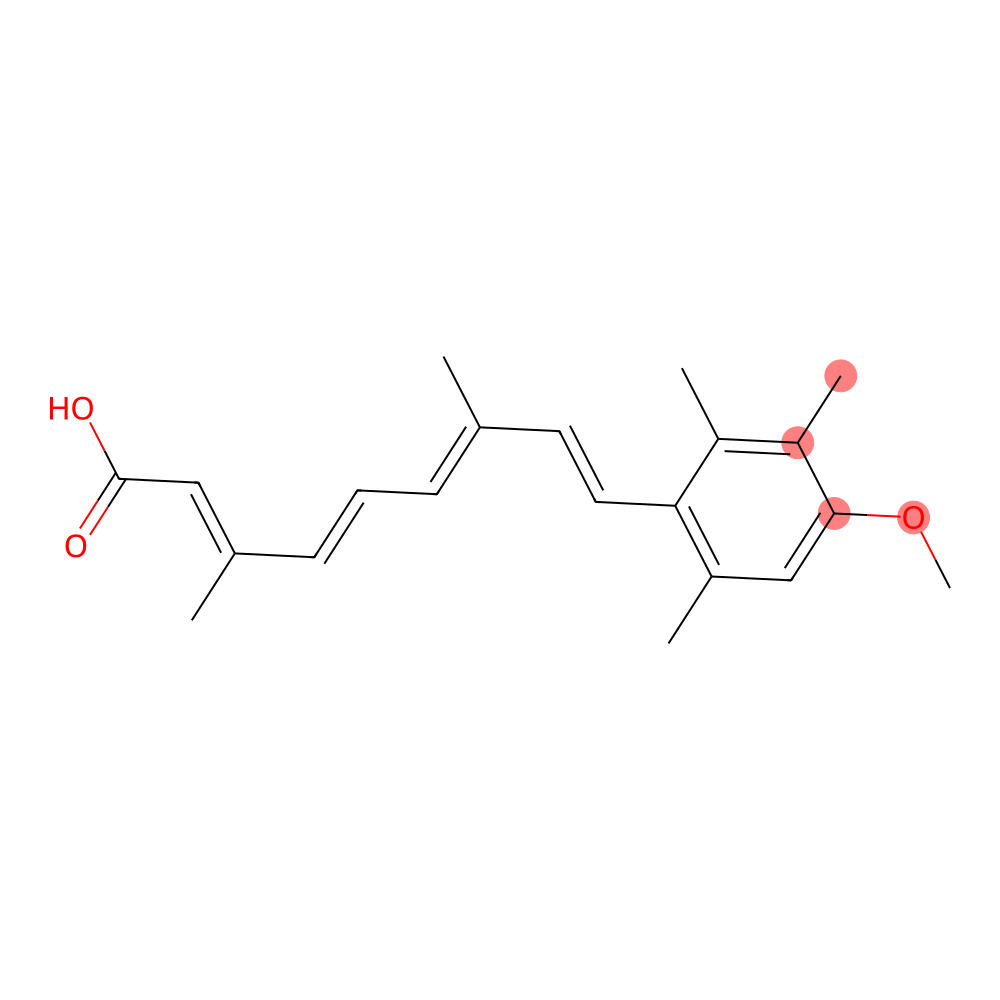

Cabazitaxel
*!@*@*!@*


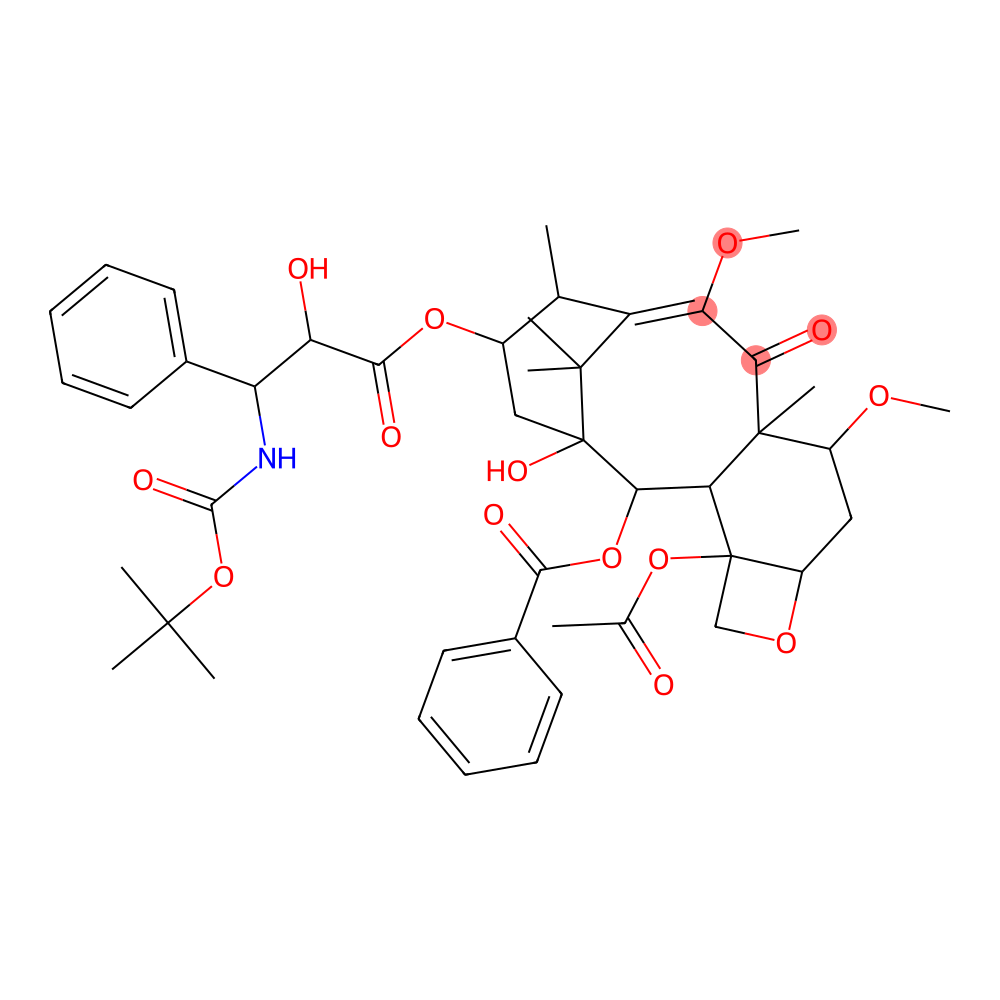

Clopidogrel
[#16]


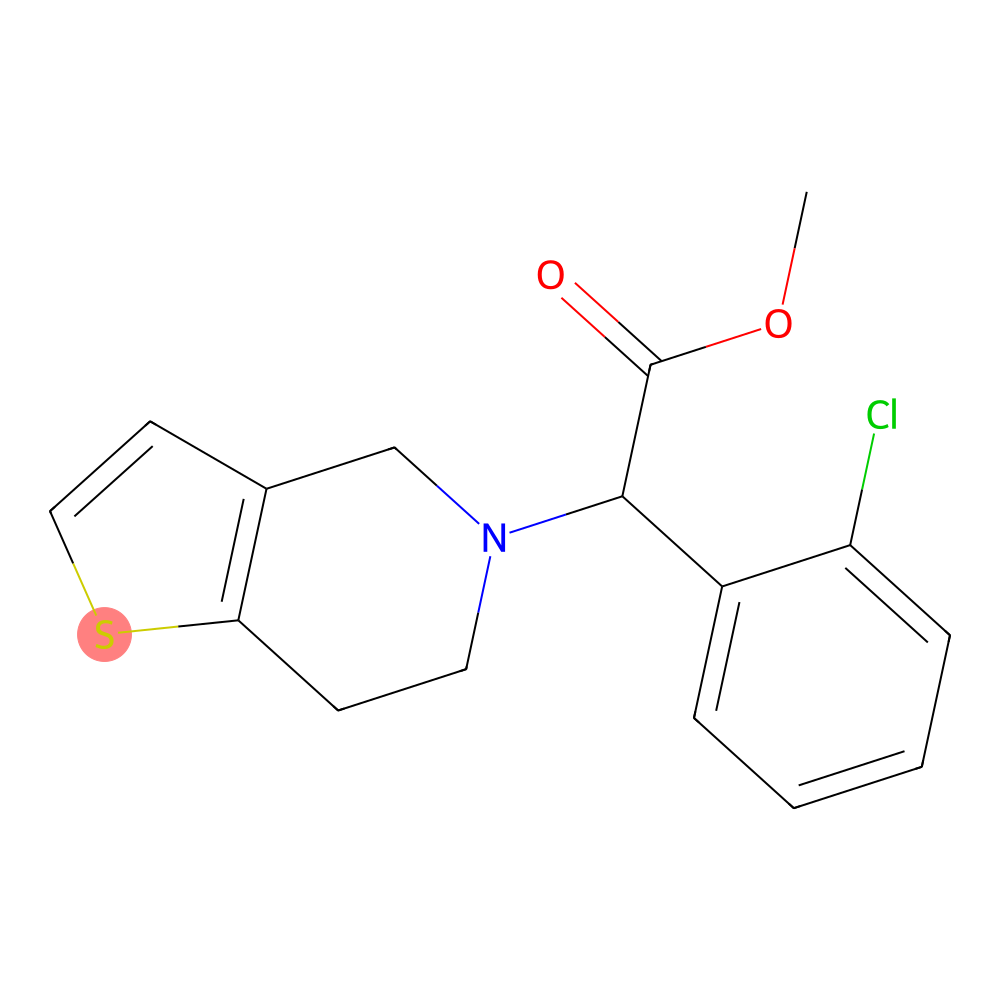

Docetaxel
*!@*@*!@*


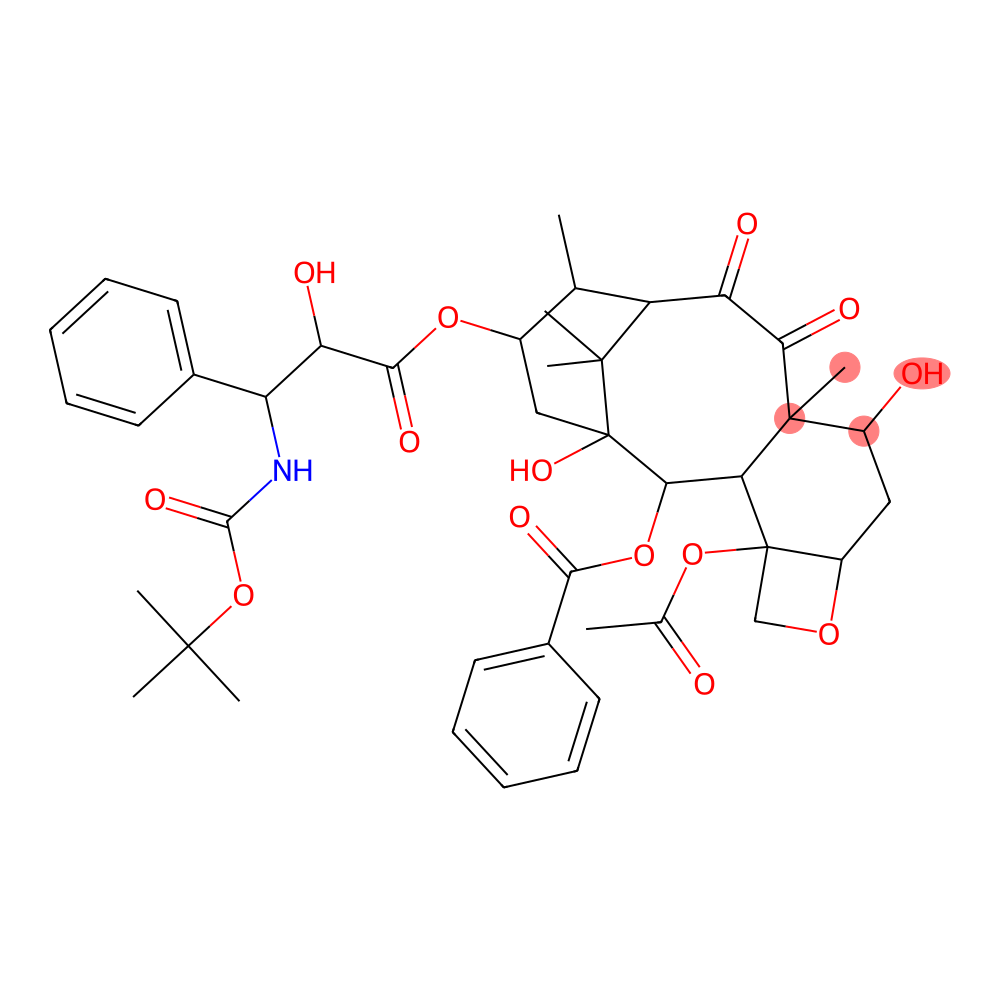

Doxycycline
*!@*@*!@*


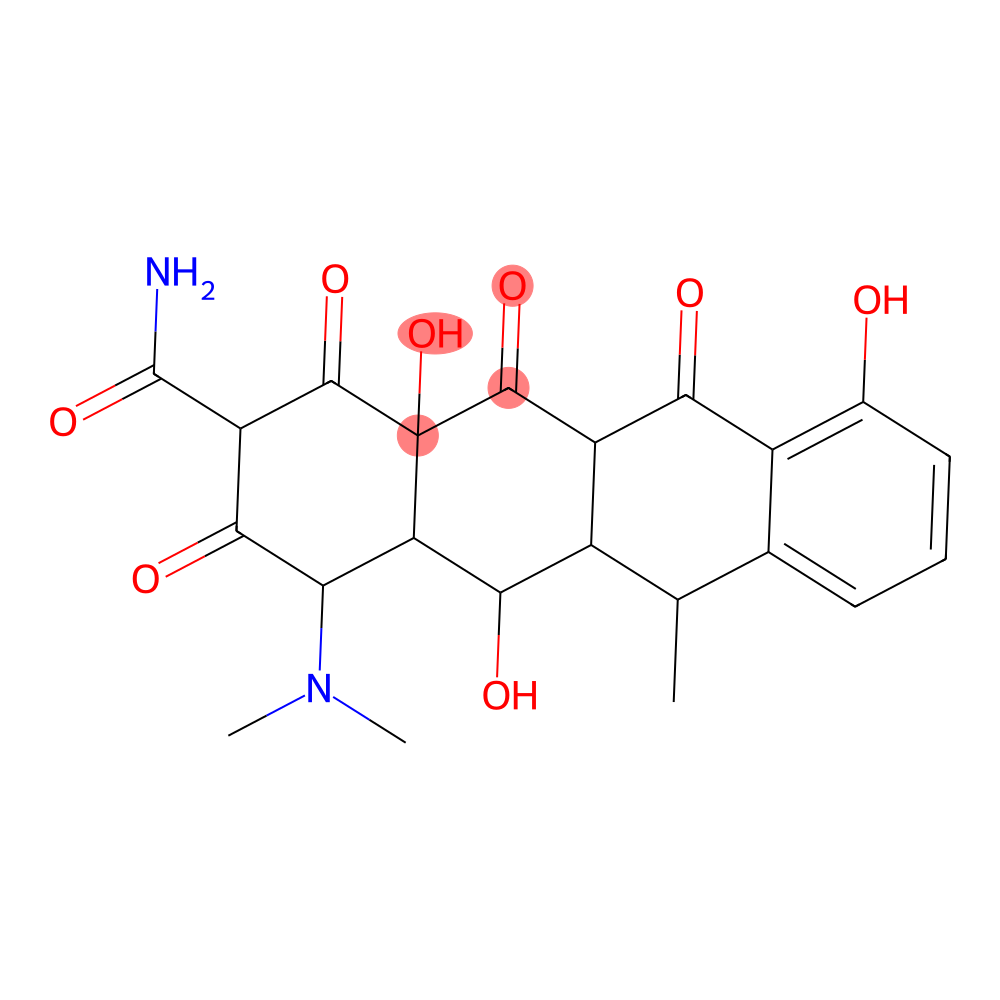

Entacapone
*@*!@[#7]


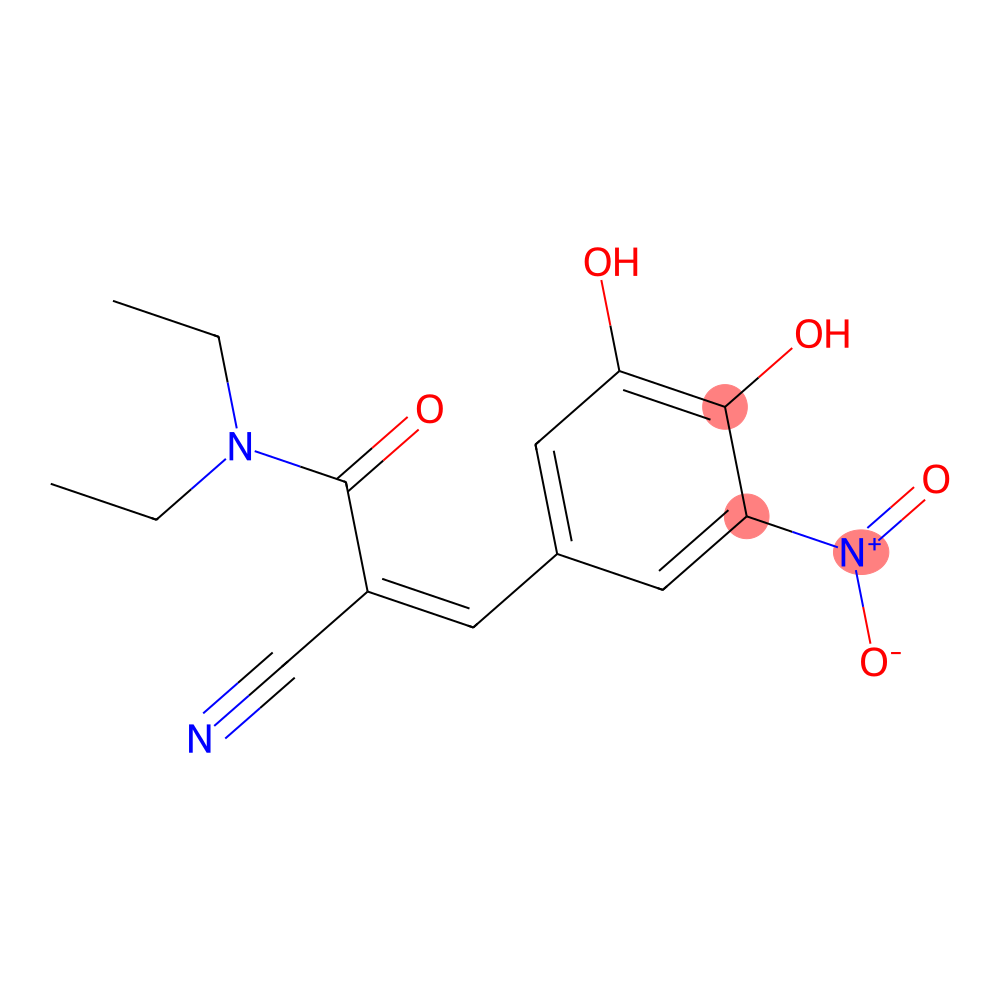

Gemcitabine
*@*!@[#7]


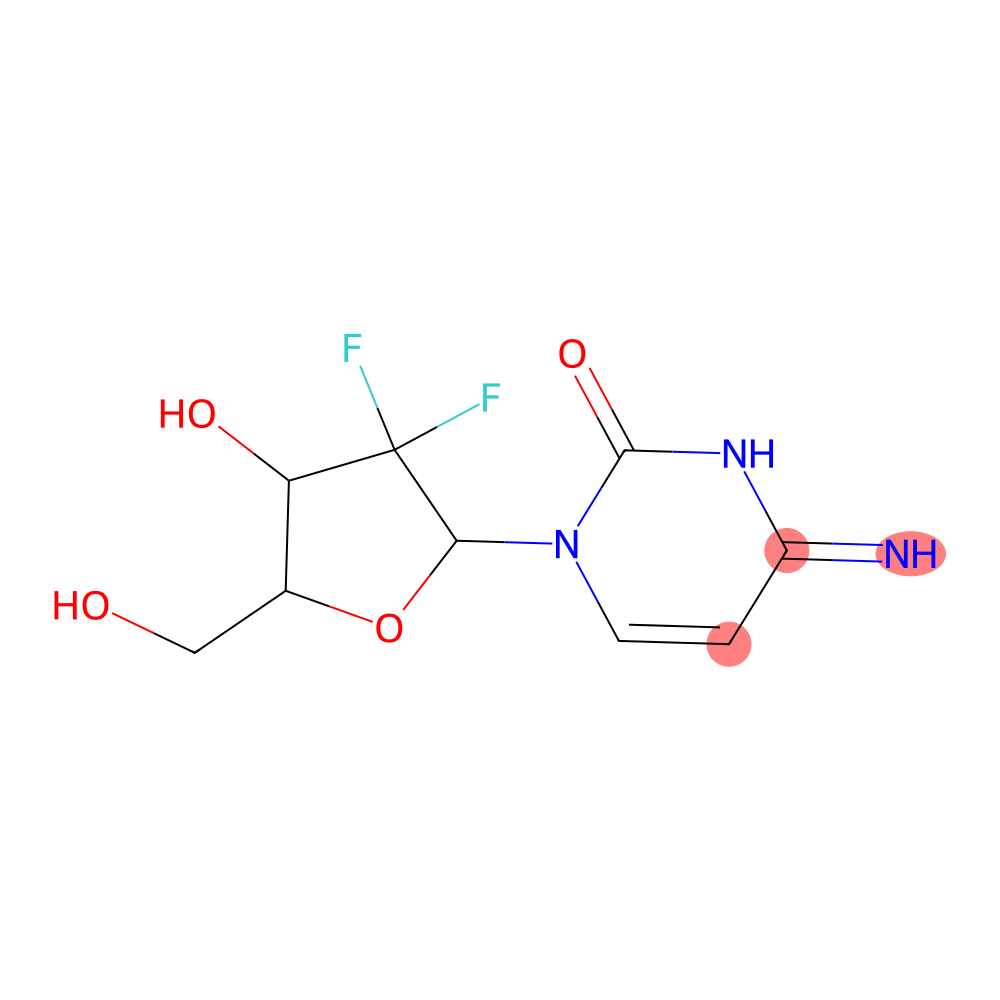

Minocycline
*!@*@*!@*


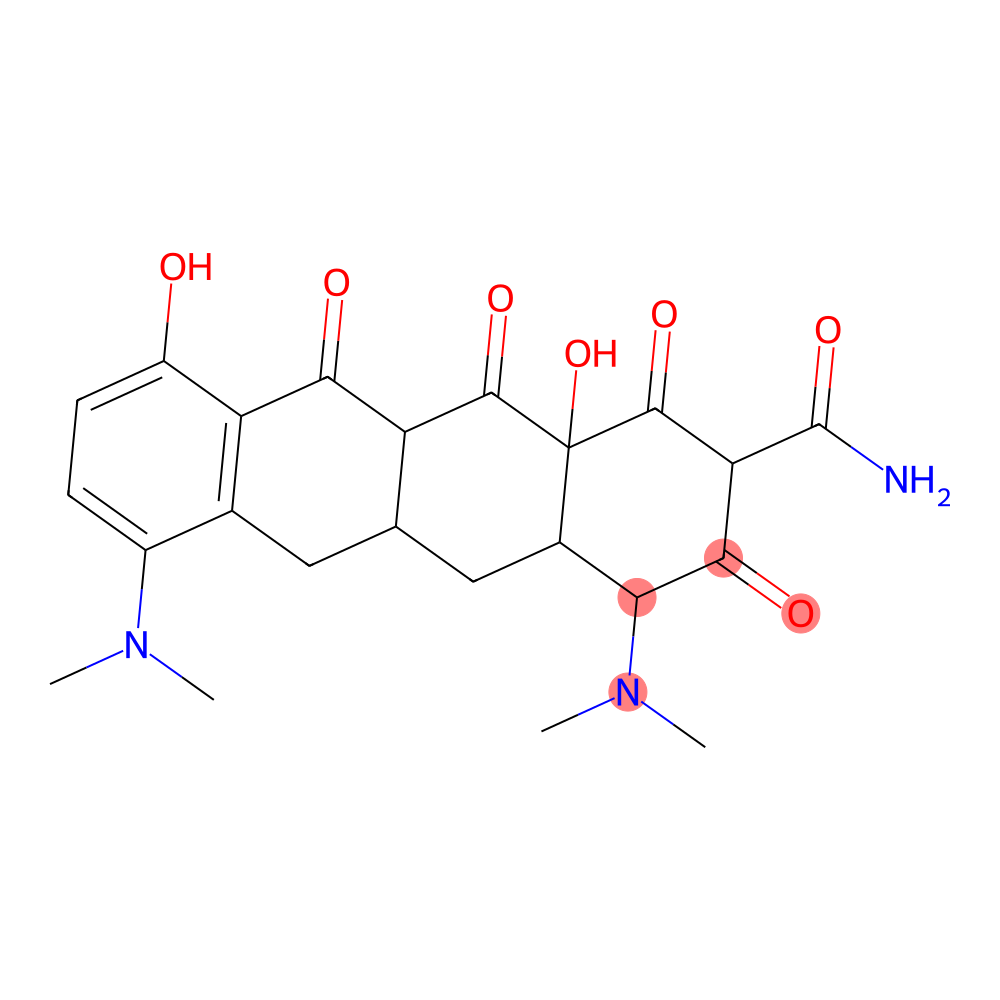

Moxifloxacin
*!@*@*!@*


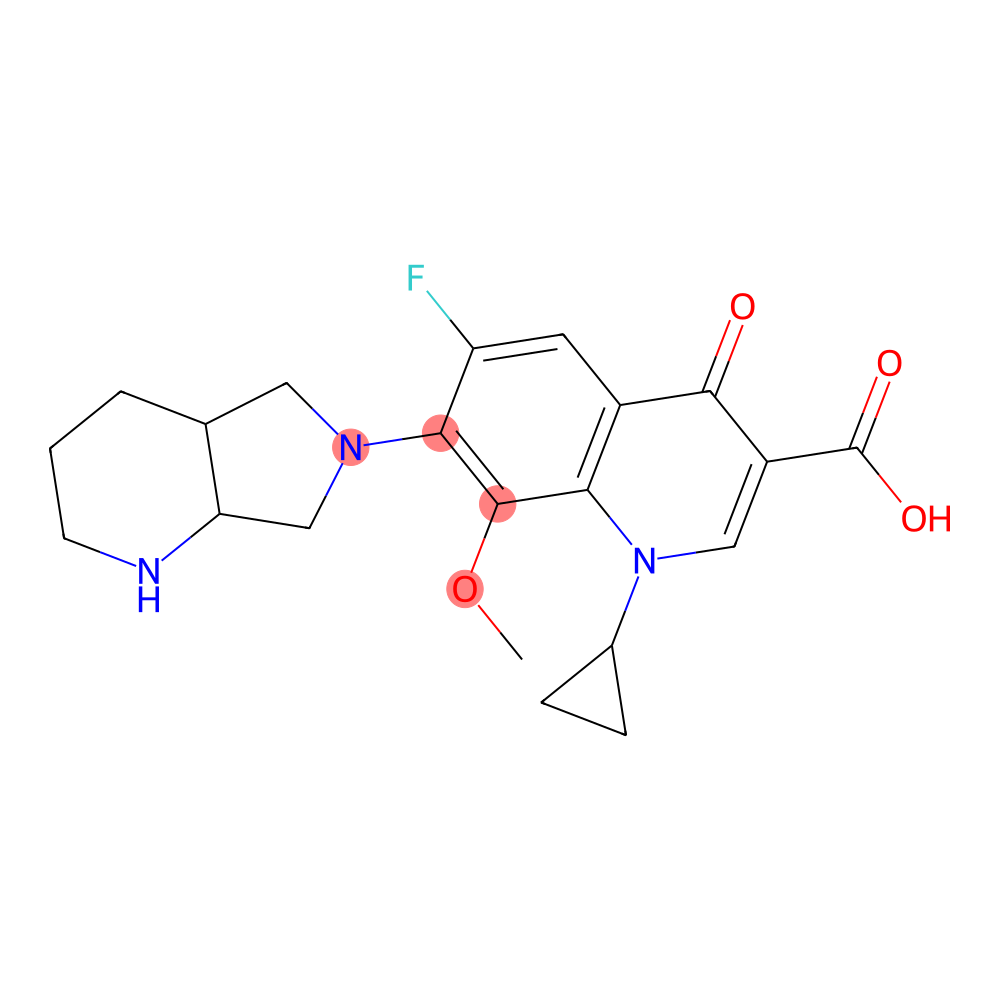

Paclitaxel
*!@*@*!@*


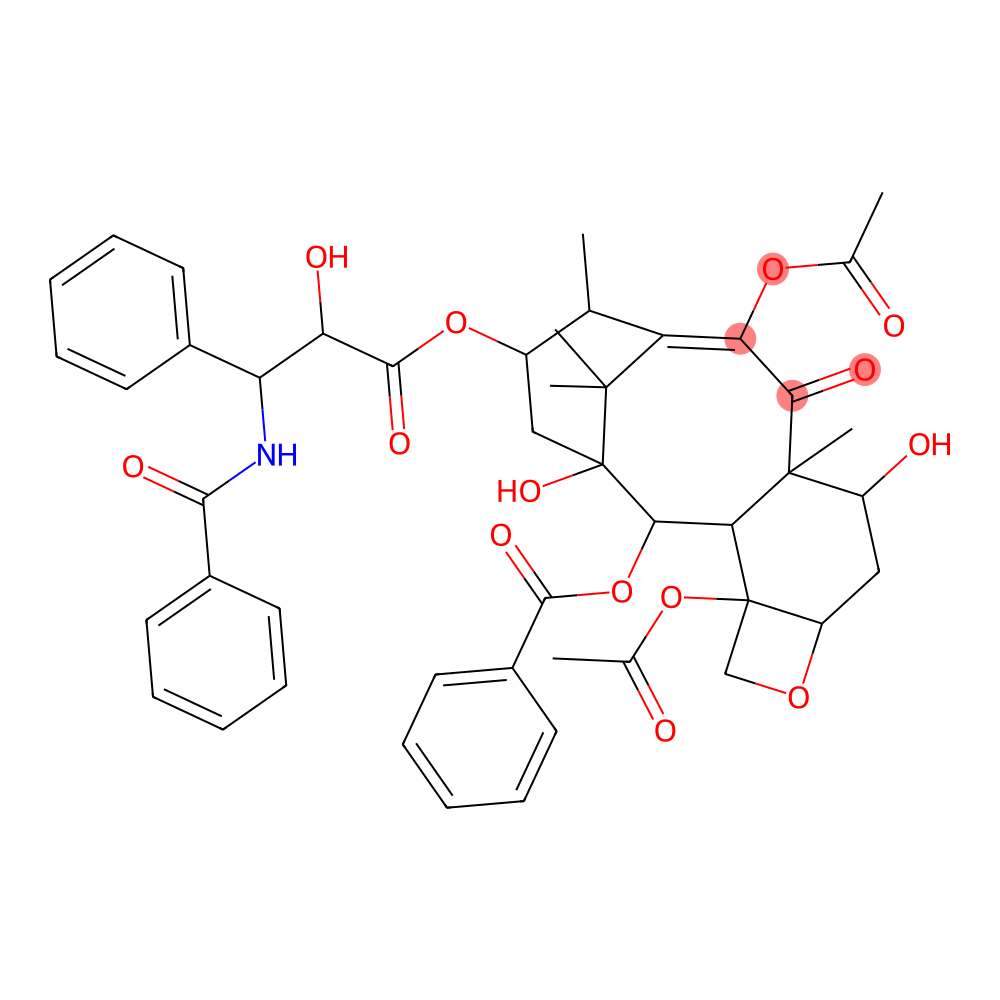

Trovafloxacin
*@*!@[#7]


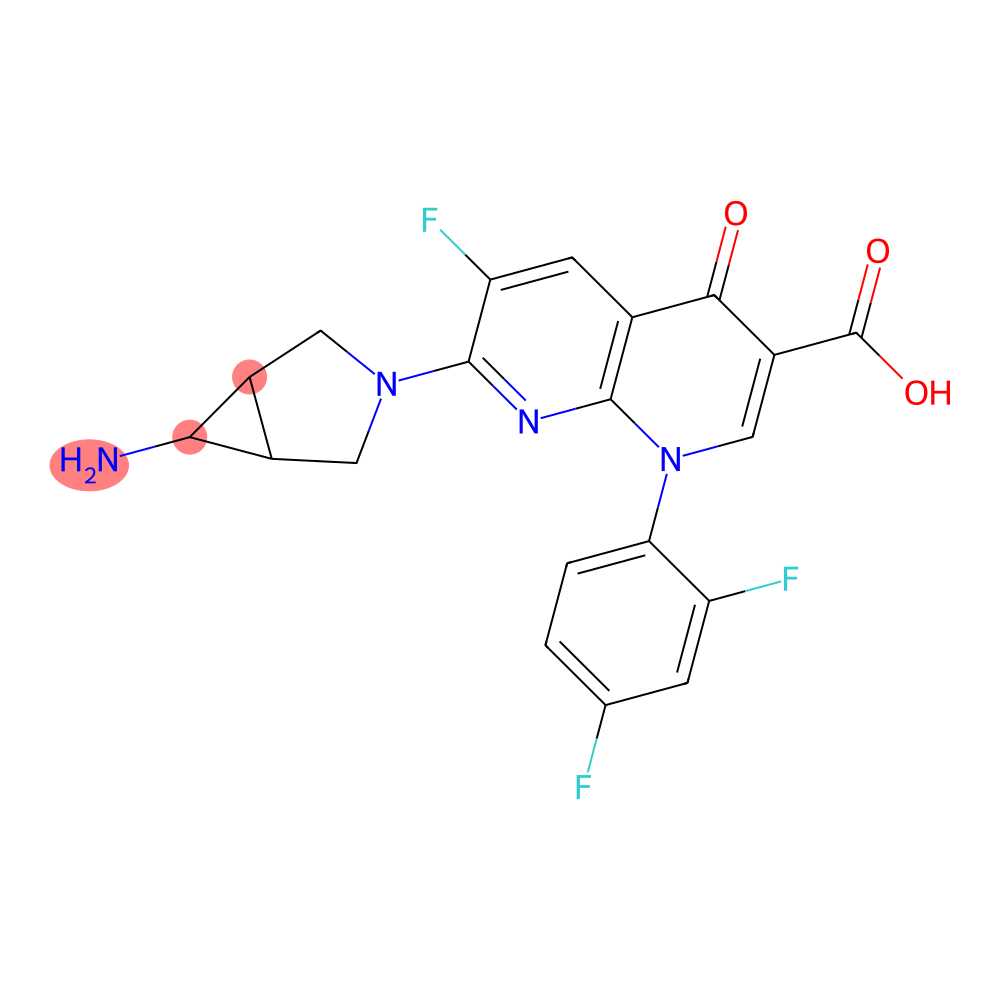

Ximelagatran
[CH3]~[CH2]~*


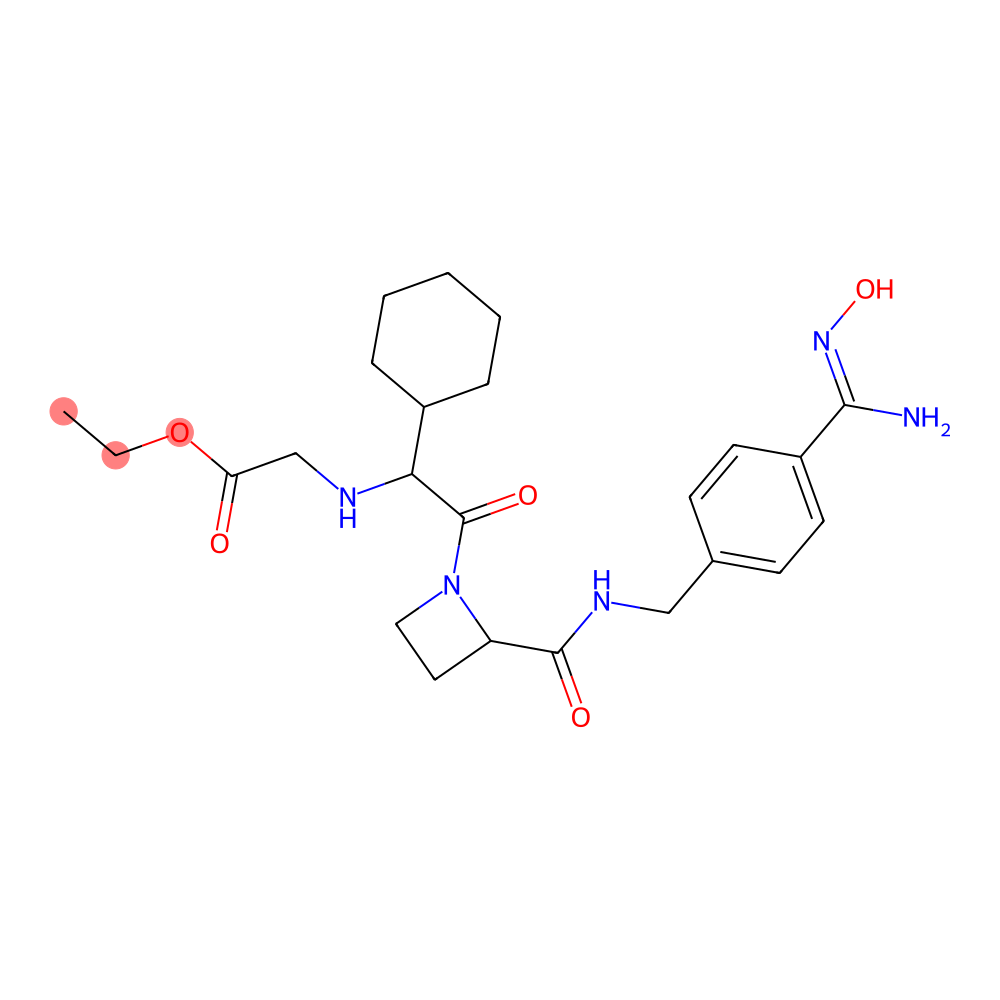

In [44]:
from IPython.display import display, Image
import os

# Assuming the rest of your setup code is already in place

for index, row in maccsshap.iterrows():
    name = row["name"]
    print(name)
    smiles = row["SMILES"]
    top_MACCS = row["topMACCS"]
    print(top_MACCS)
    
    m = Chem.MolFromSmiles(smiles)
    data = Draw.MolToImage(m, highlightAtoms=m.GetSubstructMatch(Chem.MolFromSmarts(top_MACCS)), size=(1000, 1000),
                          returnPNG=True)

    # Save the image
    image_path = f"./SHAP_molecules/{name}.png"
    data.save(image_path)
    
    # Display the image in the notebook
    if os.path.exists(image_path):
        display(Image(filename=image_path))


In [45]:
top_MACCS

'[CH3]~[CH2]~*'